In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

### Complex Linear Layers

In [2]:
class RealToComplexLinear(nn.Module):
    """
    Implements the linear transformation L^R->C(Z) that maps a real-valued 
    D-dimensional feature vector Z to a 2D-dimensional real vector 
    representing a complex D-vector (Z_r, Z_i).

    The operation is:
         [ W_r ] Z + [ b_r ]
    Y =  [ W_i ]     [ b_i ]
    
    The result Y is stacked along the first dimension, giving shape (2, ..., D).
    Y[0] = Z_r (Real part), Y[1] = Z_i (Imaginary part).
    """
    def __init__(self, d_model: int):
        """
        Args:
            d_model (int): The dimension (d) of the feature vector.
        """
        super().__init__()
        self.d_model = d_model
        
        # W_r, W_i are D x D matrices, implemented as standard Linear layers 
        self.W_r = nn.Linear(d_model, d_model)
        self.W_i = nn.Linear(d_model, d_model)
        
    def forward(self, Z: torch.Tensor) -> torch.Tensor:
        """
        Maps Z (..., D) to Y (2, ..., D).
        """
        # Compute the real part: Z_r = Z * W_r + b_r
        Z_r = self.W_r(Z)
        
        # Compute the imaginary part: Z_i = Z * W_i + b_i
        Z_i = self.W_i(Z)
        
        # --- MODIFICATION ---
        # Stack the real (Z_r) and imaginary (Z_i) parts along a new first dimension (dim=0).
        # Input shapes: (N, D), Output shape: (2, N, D)
        Y = torch.stack([Z_r, Z_i], dim=0)
        
        return Y

In [3]:
class ComplexToRealLinear(nn.Module):
    """
    Implements the linear transformation L^C->R(Z_plus) that maps a complex D-vector 
    (represented as a stacked real tensor Z_plus) back to a real D-vector Y.

    The operation is the complex projection:
    Y = Z_r * W_r^T - Z_i * W_i^T + b_r
    
    The input Z_plus is assumed to be stacked: Z_plus[0] = Z_r, Z_plus[1] = Z_i.
    """
    def __init__(self, d_model: int):
        """
        Args:
            d_model (int): The dimension (d) of the feature vector.
        """
        super().__init__()
        self.d_model = d_model
        
        # W_r and W_i parameters (D x D matrices) for the projection
        self.W_r_weight = nn.Parameter(torch.Tensor(d_model, d_model))
        self.W_i_weight = nn.Parameter(torch.Tensor(d_model, d_model))
        self.b_r = nn.Parameter(torch.Tensor(d_model))
        
        self._reset_parameters()

    def _reset_parameters(self):
        # Initialize parameters similarly to nn.Linear for stability
        nn.init.kaiming_uniform_(self.W_r_weight, a=np.sqrt(5))
        nn.init.kaiming_uniform_(self.W_i_weight, a=np.sqrt(5))
        
        # Initialize bias
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_r_weight)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.b_r, -bound, bound)
        
    def forward(self, Z_plus: torch.Tensor) -> torch.Tensor:
        """
        Maps Z_plus (2, ..., D) to Y (..., D).
        
        Args:
            Z_plus (torch.Tensor): Stacked input, Z_plus[0]=Z_r, Z_plus[1]=Z_i.
            
        Returns:
            torch.Tensor: Real-valued projected output Y.
        """
        # 1. Extract the real and imaginary parts from the stacked input
        # Z_r, Z_i shape: (..., D)
        Z_r, Z_i = torch.unbind(Z_plus, dim=0)
        
        # 2. Compute the projection: Y = Z_r @ W_r^T - Z_i @ W_i^T + b_r
        
        # Real Projection: Z_r @ W_r^T
        Y_r_proj = F.linear(Z_r, self.W_r_weight, bias=None) 
        
        # Imaginary Projection: Z_i @ (-W_i)^T
        Y_i_proj = F.linear(Z_i, -self.W_i_weight, bias=None)

        # Combine and add bias
        Y = Y_r_proj + Y_i_proj + self.b_r
        
        return Y

In [4]:

# --- Example Usage (Rigorous Complex Inversion Test) ---
if __name__ == '__main__':
    print("--- Complex Linear Inversion Test (Stacked Format) ---")
    
    d = 2  # Small dimension for easy inverse calculation
    
    # 1. Setup the Forward (R2C) Layer parameters (Matrix A)
    r2c_layer = RealToComplexLinear(d_model=d)
    
    with torch.no_grad():
        # W_r (Real part of A): [[2, 1], [1, 1]] (det=1)
        W_r_data = torch.tensor([[2.0, 1.0], [1.0, 1.0]], dtype=torch.float32)
        r2c_layer.W_r.weight.copy_(W_r_data)
        b_r_data = torch.tensor([3.0, -2.0], dtype=torch.float32)
        r2c_layer.W_r.bias.copy_(b_r_data)
        
        # W_i (Imaginary part of A): [[0.5, 0.5], [-0.5, 0.5]] (Non-zero, non-trivial)
        W_i_data = torch.tensor([[0.5, 0.5], [-0.5, 0.5]], dtype=torch.float32)
        r2c_layer.W_i.weight.copy_(W_i_data)
        b_i_data = torch.tensor([1.0, 1.0], dtype=torch.float32)
        r2c_layer.W_i.bias.copy_(b_i_data)
        
    # Input real tensor Z (shape: [1, D])
    Z_input = torch.tensor([[10.0, 5.0]], dtype=torch.float32)
    print(f"\nOriginal Z input: {Z_input.squeeze()}")
    
    # R2C Forward Pass: Output shape is (2, 1, D)
    Z_q_output = r2c_layer(Z_input)
    
    # Extract parts from the STACKED output: Z_q_output[0] is real, Z_q_output[1] is imaginary
    Z_q_r_check, Z_q_i_check = Z_q_output[0], Z_q_output[1]
    
    print(f"R2C Output Stacked shape (2, N, D): {Z_q_output.shape}")
    print(f"R2C Real part (Y_r): {Z_q_r_check.squeeze()}")
    print(f"R2C Imaginary part (Y_i): {Z_q_i_check.squeeze()}")


    # 2. Compute the Complex Inverse A^-1 = W_r' + iW_i'
    
    # Define the complex matrix A (D x D)
    A = torch.complex(W_r_data, W_i_data)

    # Compute the complex inverse A^-1 = W_r' + iW_i'
    A_inv = torch.linalg.inv(A)
    
    # Extract the real and imaginary components for the C2R layer
    W_r_prime = A_inv.real # This is W_r'
    W_i_prime = A_inv.imag # This is W_i'

    # Calculate the inverse bias b_r' using the Bias Condition:
    # b_r' = - (W_r' @ b_r - W_i' @ b_i)
    # We use unsqueeze(1) and squeeze to handle the 1D bias vectors correctly in matmul
    b_r_prime_calc = - (W_r_prime @ b_r_data.unsqueeze(1) - W_i_prime @ b_i_data.unsqueeze(1)).squeeze(1)


    # 3. Setup the Inverse (C2R) Layer
    c2r_layer = ComplexToRealLinear(d_model=d)
    
    with torch.no_grad():
        c2r_layer.W_r_weight.copy_(W_r_prime) # Set W_r'
        c2r_layer.W_i_weight.copy_(W_i_prime) # Set W_i' (Non-zero!)
        c2r_layer.b_r.copy_(b_r_prime_calc)    # Set b_r'

    print(f"\nInverse W_r' (Real part of A^-1): \n{c2r_layer.W_r_weight}")
    print(f"Inverse W_i' (Imaginary part of A^-1, non-zero): \n{c2r_layer.W_i_weight}")

    # C2R Forward Pass: Input is (2, 1, D), Output is (1, D)
    Y_output = c2r_layer(Z_q_output)
    print(f"\nC2R output Y (final real): {Y_output.squeeze()}")

    # 4. Verification
    if torch.allclose(Z_input, Y_output, atol=1e-5):
        print("\nSUCCESS: Input recovered. The C2R layer is the true inverse of the R2C layer based on A^-1.")
    else:
        print(f"\nFAILURE: Input not recovered. Difference: {Z_input - Y_output}")

--- Complex Linear Inversion Test (Stacked Format) ---

Original Z input: tensor([10.,  5.])
R2C Output Stacked shape (2, N, D): torch.Size([2, 1, 2])
R2C Real part (Y_r): tensor([28., 13.], grad_fn=<SqueezeBackward0>)
R2C Imaginary part (Y_i): tensor([ 8.5000, -1.5000], grad_fn=<SqueezeBackward0>)

Inverse W_r' (Real part of A^-1): 
Parameter containing:
tensor([[ 0.5000, -0.5000],
        [ 0.1000,  0.7000]], requires_grad=True)
Inverse W_i' (Imaginary part of A^-1, non-zero): 
Parameter containing:
tensor([[-0.5000,  0.5000],
        [ 0.7000, -1.1000]], requires_grad=True)

C2R output Y (final real): tensor([10.0000,  5.0000], grad_fn=<SqueezeBackward0>)

SUCCESS: Input recovered. The C2R layer is the true inverse of the R2C layer based on A^-1.


### Spatial Coordinate Transformation

In [5]:
class SpatialCoordinateTransformer(nn.Module):
    """
    Computes the transformed relative spatial coordinates (Delta x', Delta y') 
    for all pairs of positions in a 2D feature map of size H x W.
    
    The transformation is defined by:
    [Delta x', Delta y']^T = T @ [Delta x, Delta y]^T + b
    
    where T is a 2x2 matrix and b is a 2x1 vector of learnable parameters.
    """
    def __init__(self):
        super().__init__()
        
        # T: 2x2 transformation matrix
        # Initialized close to Identity for stability
        self.T = nn.Parameter(torch.zeros(2, 2))
        
        # b: 2x1 bias vector
        self.b = nn.Parameter(torch.zeros(2))
        
        self._reset_parameters()

    def _reset_parameters(self):
        """Initializes T close to the identity matrix."""
        # Initialize T as a slight perturbation of the Identity matrix
        nn.init.eye_(self.T)
        self.T.data += torch.randn_like(self.T.data) * 0.01
        
        # Initialize b to zero
        nn.init.constant_(self.b, 0.0)

    def forward(self, H: int, W: int, input_coords: torch.Tensor = None) -> torch.Tensor:
        """
        Calculates the transformed relative displacement matrix.
        
        Args:
            H (int): Height of the feature map. (Only used if input_coords is None)
            W (int): Width of the feature map. (Only used if input_coords is None)
            input_coords (torch.Tensor, optional): Pre-calculated displacement matrix (N, N, 2)
                                                   to transform, used for composition tests. Defaults to None.
            
        Returns:
            torch.Tensor: Transformed relative coordinates (N, N, 2), 
                          where N = H * W.
        """
        
        if input_coords is not None:
            # If coordinates are provided (for the inverse pass), use them directly
            Delta_P = input_coords
        else:
            # Otherwise, calculate initial Delta_P from H and W (Forward pass)
            N = H * W
            
            # 1. Generate 2D grid coordinates (x, y)
            y_coords, x_coords = torch.meshgrid(
                torch.arange(H, dtype=torch.float32), 
                torch.arange(W, dtype=torch.float32),
                indexing='ij'
            )
            
            # P_coords: (H, W, 2) where last dim is [x, y]
            P_coords = torch.stack([x_coords, y_coords], dim=-1)
            
            # 2. Flatten coordinates: P (N, 2)
            P = P_coords.reshape(N, 2)
            
            # 3. Calculate all pairwise differences (Delta P)
            # Delta_P: (N, N, 2) where Delta_P[a, b] = P_a - P_b
            Delta_P = P.unsqueeze(1) - P.unsqueeze(0)
            
        # 4. Apply the linear transformation T
        # We perform Delta_P @ T.T
        T_mat = self.T.transpose(0, 1)

        # Delta_P_prime (N, N, 2)
        Delta_P_prime = torch.matmul(Delta_P, T_mat)
        
        # 5. Add the bias b (broadcasted)
        # Bias b is (2,) and is added to the last dimension
        Delta_P_final = Delta_P_prime + self.b
        
        return Delta_P_final

In [6]:
# --- Helper function to compute Delta_P for testing ---
def get_delta_p(H, W):
    """Calculates the original, untransformed pairwise displacement matrix."""
    y_coords, x_coords = torch.meshgrid(
        torch.arange(H, dtype=torch.float32), 
        torch.arange(W, dtype=torch.float32),
        indexing='ij'
    )
    P_coords = torch.stack([x_coords, y_coords], dim=-1)
    P = P_coords.reshape(H * W, 2)
    # Delta_P[a, b] = P_a - P_b
    Delta_P = P.unsqueeze(1) - P.unsqueeze(0)
    return Delta_P

# --- Test 1: Scaling and Translation (Original Test) ---
def test_scaling_translation(H_val, W_val):
    print("\n" + "="*50)
    print("Test 1: Scaling and Translation Verification")
    print("="*50)
    
    coord_mapper = SpatialCoordinateTransformer()
    
    # Manually set T and b for predictable output
    with torch.no_grad():
        # T = [[2, 0], [0, 3]] -> Scale x by 2, y by 3
        coord_mapper.T.data = torch.tensor([[2.0, 0.0], [0.0, 3.0]], dtype=torch.float32)
        # b = [10, 0] -> Shift x' by 10
        coord_mapper.b.data = torch.tensor([10.0, 0.0], dtype=torch.float32)
        
    Delta_P_prime = coord_mapper(H_val, W_val)
    Delta_P = get_delta_p(H_val, W_val)
    
    # Verification: Check a single, known displacement (e.g., pixel (1, 0) relative to (0, 0))
    # Original Delta_P[1, 0] = [1, 0]
    # Expected Transformed Delta_P'[1, 0] = [12, 0]
    
    idx_a = 1 # Pixel (1, 0)
    idx_b = 0 # Pixel (0, 0)
    
    transformed_val = Delta_P_prime[idx_a, idx_b]
    expected_val = torch.tensor([12.0, 0.0])
    
    print(f"Checking displacement from P_b(0,0) to P_a(1,0):")
    print(f"Original Delta [1, 0]: {Delta_P[idx_a, idx_b]}")
    print(f"Transformed Delta': {transformed_val.squeeze()}")
    
    if torch.allclose(transformed_val, expected_val, atol=1e-5):
        print("\nVerification successful: Transformed coordinate calculation is correct.")
    else:
        print(f"\nVerification failed: Expected {expected_val}, Got {transformed_val}")

# --- Test 2: Rotation and Inverse Composition ---
def test_inverse_rotation(H_val, W_val):
    print("\n" + "="*50)
    print("Test 2: Rotation & Inverse Composition (Identity Check)")
    print("="*50)

    # 1. Define Rotation Matrix R (45 degrees = pi/4 radians)
    theta = np.pi / 4.0
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    
    # R (Rotation matrix for T)
    R = torch.tensor([
        [cos_t, -sin_t],
        [sin_t, cos_t]
    ], dtype=torch.float32)
    
    # R_inv (Inverse Rotation matrix for T_inv), which is R^T
    R_inv = R.transpose(0, 1)

    # 2. Define non-zero bias for the forward pass
    b_forward = torch.tensor([5.0, -3.0], dtype=torch.float32)

    # 3. Calculate compensation bias for the inverse pass
    # Required inverse bias: b_inverse = - (b_forward @ R)
    b_inverse = -torch.matmul(b_forward, R)

    # --- Pass 1: Forward Rotation ---
    mapper_forward = SpatialCoordinateTransformer()
    with torch.no_grad():
        mapper_forward.T.data = R
        mapper_forward.b.data = b_forward
    
    Delta_P = get_delta_p(H_val, W_val)
    Delta_P_prime = mapper_forward(H_val, W_val)

    # --- Pass 2: Inverse Rotation ---
    mapper_inverse = SpatialCoordinateTransformer()
    with torch.no_grad():
        mapper_inverse.T.data = R_inv
        mapper_inverse.b.data = b_inverse
    
    # Apply inverse transformation to the rotated coordinates
    # The fix is applied here: the forward method now accepts input_coords
    Delta_P_double_prime = mapper_inverse.forward(H_val, W_val, input_coords=Delta_P_prime)
    
    # Check if the final result is close to the original Delta_P
    is_close = torch.allclose(Delta_P_double_prime, Delta_P, atol=1e-5)

    if is_close:
        print("Verification successful: The rotation and inverse rotation composed into the identity function (with bias compensation).")
    else:
        print("Verification failed: Forward and inverse transformations did not compose to identity.")
        print(f"Error magnitude (Max Abs Diff): {torch.max(torch.abs(Delta_P_double_prime - Delta_P))}")
        
    # Example comparison for a non-zero coordinate [1, 1]
    idx_a = W_val + 1 # Pixel (1, 1)
    idx_b = 0         # Pixel (0, 0)
    print(f"\nExample Check (P_b(0,0) to P_a(1,1)):")
    print(f"Original Delta: {Delta_P[idx_a, idx_b]}")
    print(f"Final Delta'': {Delta_P_double_prime[idx_a, idx_b]}")

# --- Example Usage ---
if __name__ == '__main__':
    H_val, W_val = 3, 4 # Small 3x4 image for demonstration (N=12)
    
    print(f"Input spatial dimensions: H={H_val}, W={W_val} (Total Pixels N={H_val*W_val})")
    
    test_scaling_translation(H_val, W_val)
    test_inverse_rotation(H_val, W_val)

Input spatial dimensions: H=3, W=4 (Total Pixels N=12)

Test 1: Scaling and Translation Verification
Checking displacement from P_b(0,0) to P_a(1,0):
Original Delta [1, 0]: tensor([1., 0.])
Transformed Delta': tensor([12.,  0.], grad_fn=<SqueezeBackward0>)

Verification successful: Transformed coordinate calculation is correct.

Test 2: Rotation & Inverse Composition (Identity Check)
Verification successful: The rotation and inverse rotation composed into the identity function (with bias compensation).

Example Check (P_b(0,0) to P_a(1,1)):
Original Delta: tensor([1., 1.])
Final Delta'': tensor([1., 1.], grad_fn=<SelectBackward0>)


### Covariance Kernel

In [7]:
def _compute_integral_term(alpha_raw: torch.Tensor, delta_t: torch.Tensor) -> torch.Tensor:
    """
    Computes the integral part of the variance: 
    (e^(-2 * alpha^2 * |delta_t|) - 1) / (-2 * alpha^2)
    
    Implements L'Hôpital's rule for stability when alpha^2 is small (<= EPS).
    If alpha^2 <= EPS, the integral limit is |delta_t|.
    
    Args:
        alpha_raw (torch.Tensor): The raw alpha parameter (1,).
        delta_t (torch.Tensor): The displacement tensor (N, N).
        
    Returns:
        torch.Tensor: The integral term kappa (N, N).
    """
    EPS = 1e-6
    
    # 1. Get alpha^2 (Positivity enforced by squaring)
    alpha_sq = alpha_raw ** 2
    
    abs_delta_t = torch.abs(delta_t)
    
    # 2. Case for alpha_sq > EPS (Standard Formula)
    exponent = -2.0 * alpha_sq * abs_delta_t
    numerator = torch.exp(exponent) - 1.0
    denominator = -2.0 * alpha_sq
    
    # Standard formula calculation, avoiding division by zero via masking
    standard_integral = numerator / denominator

    # 3. Case for alpha_sq <= EPS (L'Hôpital limit: |Delta t|)
    limit_integral = abs_delta_t
    
    # 4. Masked expression: kappa = standard_integral if alpha_sq > EPS else |Delta t|
    mask = alpha_sq > EPS
    kappa = torch.where(mask, standard_integral, limit_integral)
    
    return kappa

def sde_variance_calculator_fn(
    delta_p_prime: torch.Tensor, 
    alpha_x_raw: torch.Tensor, 
    alpha_y_raw: torch.Tensor, 
    sigma_x_raw: torch.Tensor, 
    sigma_y_raw: torch.Tensor, 
    eta_raw: torch.Tensor, 
    gamma_raw: torch.Tensor
) -> torch.Tensor:
    """
    Calculates the SDE variance term sigma_V^2 functionally, based on externally provided parameters.

    Formula: 
    sigma_V^2 = ( sigma_x^2 * integral_x ) * ( sigma_y^2 * integral_y ) 
              + eta^2 * decay_term + gamma^2
    
    Args:
        delta_p_prime (torch.Tensor): Transformed relative coordinates (N, N, 2).
        [...raw parameters...]: Raw, learned parameters (1,) that are squared internally.

    Returns:
        torch.Tensor: The variance matrix sigma_V^2 (N, N).
    """
    
    # --- Enforce positivity on all parameters by squaring ---
    alpha_x_sq = alpha_x_raw ** 2
    alpha_y_sq = alpha_y_raw ** 2
    sigma_x_sq = sigma_x_raw ** 2
    sigma_y_sq = sigma_y_raw ** 2
    eta_sq = eta_raw ** 2
    gamma_sq = gamma_raw ** 2

    # Separate Delta x' and Delta y'
    delta_x_prime = delta_p_prime[..., 0]
    delta_y_prime = delta_p_prime[..., 1]

    # 1. Compute Integral Terms (Term 1 components)
    # NOTE: We pass the raw alpha to the helper function which handles the squaring internally
    integral_x = _compute_integral_term(alpha_x_raw, delta_x_prime)
    integral_y = _compute_integral_term(alpha_y_raw, delta_y_prime)

    term1 = (sigma_x_sq * integral_x) * (sigma_y_sq * integral_y)

    # 2. Compute Decay Term (Term 2 component)
    decay_exponent = (-2.0 * alpha_x_sq * torch.abs(delta_x_prime) 
                      - 2.0 * alpha_y_sq * torch.abs(delta_y_prime))
    
    decay_term = torch.exp(decay_exponent)
    term2 = eta_sq * decay_term

    # 3. Compute Final Variance: sigma_V^2 = Term1 + Term2 + gamma^2
    sigma_v_sq = term1 + term2 + gamma_sq
    
    return sigma_v_sq

In [8]:
# --- Example Usage for Verification ---
if __name__ == '__main__':
    print("--- SDE Variance Calculator (Functional) Verification ---")
    
    # 1. Setup: Define external parameters (e.g., from a main model's __init__)
    # We use tensors with requires_grad=False for simplicity in the test.
    
    # Target values for squared parameters: alpha^2=0.01, sigma^2=1.0, eta^2=0.5, gamma^2=0.1
    alpha_x_raw = torch.tensor([np.sqrt(0.01)], dtype=torch.float32)
    alpha_y_raw = torch.tensor([np.sqrt(1e-7)], dtype=torch.float32) # Limit case (alpha_y^2 < 1e-6)
    sigma_x_raw = torch.tensor([np.sqrt(1.0)], dtype=torch.float32)
    sigma_y_raw = torch.tensor([np.sqrt(1.0)], dtype=torch.float32)
    eta_raw = torch.tensor([np.sqrt(0.5)], dtype=torch.float32)
    gamma_raw = torch.tensor([np.sqrt(0.1)], dtype=torch.float32)
    
    alpha_x_sq_val = alpha_x_raw.square().item()
    alpha_y_sq_val = alpha_y_raw.square().item()
    eta_sq_val = eta_raw.square().item()
    gamma_sq_val = gamma_raw.square().item()

    # Define a simple input: N=3 (pixels), displacement matrix (3, 3, 2)
    delta_p_prime_data = torch.tensor([
        [[ 0.0, 0.0], [ 1.0, 0.0], [ 2.0, 0.0]], 
        [[-1.0, 0.0], [ 0.0, 0.0], [ 1.0, 0.0]], 
        [[-2.0, 0.0], [-1.0, 0.0], [ 0.0, 0.0]], 
    ], dtype=torch.float32)
    
    # 2. Function Call
    sigma_v_sq_output = sde_variance_calculator_fn(
        delta_p_prime_data,
        alpha_x_raw, alpha_y_raw,
        sigma_x_raw, sigma_y_raw,
        eta_raw, gamma_raw
    )
    
    print(f"\nParameters (Squared values):")
    print(f"  alpha_x^2 (Standard): {alpha_x_sq_val:.8f}")
    print(f"  alpha_y^2 (Limit): {alpha_y_sq_val:.8f}")
    print(f"  eta^2: {eta_sq_val:.4f}, gamma^2: {gamma_sq_val:.4f}")
    
    # 3. Verification Check 1: Zero Displacement (Diagonal Element)
    # Expected: 0 + eta^2 * 1 + gamma^2
    expected_zero_distance = eta_sq_val + gamma_sq_val
    actual_zero_distance = sigma_v_sq_output[0, 0] # Any diagonal element
    
    print("\nCheck 1: Zero Displacement [0, 0]")
    print(f"  Actual sigma_V^2[0, 0]: {actual_zero_distance.item():.6f}")
    print(f"  Expected (eta^2 + gamma^2): {expected_zero_distance:.6f}")
    
    if torch.allclose(actual_zero_distance, torch.tensor(expected_zero_distance, dtype=actual_zero_distance.dtype), atol=1e-5):
        print("  Status: SUCCESS (Zero displacement result is correct)")
    else:
        print("  Status: FAILURE (Zero displacement result is incorrect)")
        
    # 4. Verification Check 2: Non-zero Distance Case (Delta x' = 1, Delta y' = 0)
    # integral_y (alpha_y^2 = 1e-7) uses L'Hôpital Limit: |Delta y'| = 0, so integral_y = 0.
    term1_expected = 0.0
    
    # Decay Term: exp(-2*alpha_x^2*|1| - 2*alpha_y^2*|0|) = exp(-2*0.01)
    decay_expected = np.exp(-2 * alpha_x_sq_val * 1.0 - 2 * alpha_y_sq_val * 0.0)
    term2_expected = eta_sq_val * decay_expected
    
    expected_non_zero_distance = term1_expected + term2_expected + gamma_sq_val
    actual_non_zero_distance = sigma_v_sq_output[1, 0]
    
    print("\nCheck 2: Non-Zero Displacement (Delta x' = 1, Delta y' = 0)")
    print(f"  Actual sigma_V^2[1, 0]: {actual_non_zero_distance.item():.6f}")
    print(f"  Expected (Term2 + gamma^2): {expected_non_zero_distance:.6f}")
    
    if torch.allclose(actual_non_zero_distance, torch.tensor(expected_non_zero_distance, dtype=actual_non_zero_distance.dtype), atol=1e-5):
        print("  Status: SUCCESS (Non-zero displacement result is correct)")
    else:
        print("  Status: FAILURE (Non-zero displacement result is incorrect)")

--- SDE Variance Calculator (Functional) Verification ---

Parameters (Squared values):
  alpha_x^2 (Standard): 0.01000000
  alpha_y^2 (Limit): 0.00000010
  eta^2: 0.5000, gamma^2: 0.1000

Check 1: Zero Displacement [0, 0]
  Actual sigma_V^2[0, 0]: 0.600000
  Expected (eta^2 + gamma^2): 0.600000
  Status: SUCCESS (Zero displacement result is correct)

Check 2: Non-Zero Displacement (Delta x' = 1, Delta y' = 0)
  Actual sigma_V^2[1, 0]: 0.590099
  Expected (Term2 + gamma^2): 0.590099
  Status: SUCCESS (Non-zero displacement result is correct)


In [9]:
# # --- Example Usage for Verification ---
# if __name__ == '__main__':
#     print("--- SDE Variance Calculator Verification ---")
    
#     # 1. Setup
#     calc = SDEVarianceCalculator()
    
#     # Manually set parameters for predictable output (using raw values to target squared values)
#     # Target values for squared parameters: alpha^2=0.01, sigma^2=1.0, eta^2=0.5, gamma^2=0.1
#     with torch.no_grad():
#         calc.alpha_x_raw.data.fill_(np.sqrt(0.01)) # alpha_x^2 = 0.01 (Uses standard formula)
#         calc.alpha_y_raw.data.fill_(np.sqrt(1e-7)) # alpha_y^2 = 1e-7 (Uses L'Hôpital limit, < 1e-6)
#         calc.sigma_x_raw.data.fill_(np.sqrt(1.0))  # sigma_x^2 = 1.0
#         calc.sigma_y_raw.data.fill_(np.sqrt(1.0))  # sigma_y^2 = 1.0
#         calc.eta_raw.data.fill_(np.sqrt(0.5))      # eta^2 = 0.5
#         calc.gamma_raw.data.fill_(np.sqrt(0.1))    # gamma^2 = 0.1
        
#     alpha_x_sq_val = calc.alpha_x_raw.data.square().item()
#     alpha_y_sq_val = calc.alpha_y_raw.data.square().item()
#     sigma_x_sq_val = calc.sigma_x_raw.data.square().item()
#     sigma_y_sq_val = calc.sigma_y_raw.data.square().item()
#     eta_sq_val = calc.eta_raw.data.square().item()
#     gamma_sq_val = calc.gamma_raw.data.square().item()

#     # Define a simple input: N=3 (pixels), displacement matrix (3, 3, 2)
#     # Positions: (0,0), (1,0), (2,0)
#     # Delta P' [a, b] = P_a - P_b
#     delta_p_prime_data = torch.tensor([
#         [[ 0.0, 0.0], [ 1.0, 0.0], [ 2.0, 0.0]], # Row for P_a=(0,0)
#         [[-1.0, 0.0], [ 0.0, 0.0], [ 1.0, 0.0]], # Row for P_a=(1,0)
#         [[-2.0, 0.0], [-1.0, 0.0], [ 0.0, 0.0]], # Row for P_a=(2,0)
#     ])
    
#     # 2. Forward Pass
#     sigma_v_sq_output = calc(delta_p_prime_data)
    
#     print(f"\nParameters (Squared values):")
#     print(f"  alpha_x^2 (Standard): {alpha_x_sq_val:.8f}")
#     print(f"  alpha_y^2 (Limit): {alpha_y_sq_val:.8f}")
#     print(f"  sigma_x^2 (Standard): {sigma_x_sq_val:.8f}")
#     print(f"  sigma_y^2 (Limit): {sigma_y_sq_val:.8f}")
#     print(f"  eta^2: {eta_sq_val:.4f}, gamma^2: {gamma_sq_val:.4f}")
    
#     # 3. Verification Check 1: Zero Displacement (Diagonal Element)
#     # Expected: 0 + eta^2 * 1 + gamma^2
#     expected_zero_distance = eta_sq_val + gamma_sq_val
#     actual_zero_distance = sigma_v_sq_output[0, 0] # Any diagonal element
    
#     print("\nCheck 1: Zero Displacement (Diagonal Element)")
#     print(f"  Actual sigma_V^2[0, 0]: {actual_zero_distance.item():.6f}")
#     print(f"  Expected (eta^2 + gamma^2): {expected_zero_distance:.6f}")
    
#     # FIX: Ensure expected tensor has the same dtype as actual tensor
#     if torch.allclose(actual_zero_distance, torch.tensor(expected_zero_distance, dtype=actual_zero_distance.dtype), atol=1e-5):
#         print("  Status: SUCCESS (Zero displacement result is correct)")
#     else:
#         print("  Status: FAILURE (Zero displacement result is incorrect)")
        
#     # 4. Verification Check 2: Non-zero Distance Case (Delta x' = 1, Delta y' = 0)
#     # P_a=(1,0) to P_b=(0,0) -> Delta P' = [1, 0]
    
#     # integral_x (alpha_x^2 = 0.01) uses Standard Formula
#     # integral_y (alpha_y^2 = 1e-7) uses L'Hôpital Limit: |Delta y'| = 0
    
#     # Term 1: (sigma_x^2 * integral_x) * (sigma_y^2 * integral_y)
#     # integral_y is 0 since Delta y' = 0 (L'Hôpital limit |0| = 0)
#     term1_expected = 0.0
    
#     # Decay Term: e^(-2*alpha_x^2*|1| - 2*alpha_y^2*|0|) = e^(-2*0.01)
#     decay_expected = np.exp(-2 * alpha_x_sq_val * 1.0 - 2 * alpha_y_sq_val * 0.0)
#     term2_expected = eta_sq_val * decay_expected
    
#     expected_non_zero_distance = term1_expected + term2_expected + gamma_sq_val
#     actual_non_zero_distance = sigma_v_sq_output[1, 0]
    
#     print("\nCheck 2: Non-Zero Displacement (Delta x' = 1, Delta y' = 0)")
#     print(f"  Actual sigma_V^2[1, 0]: {actual_non_zero_distance.item():.6f}")
#     print(f"  Expected (Term2 + gamma^2): {expected_non_zero_distance:.6f}")
    
#     # FIX: Ensure expected tensor has the same dtype as actual tensor
#     if torch.allclose(actual_non_zero_distance, torch.tensor(expected_non_zero_distance, dtype=actual_non_zero_distance.dtype), atol=1e-5):
#         print("  Status: SUCCESS (Non-zero displacement result is correct)")
#     else:
#         print("  Status: FAILURE (Non-zero displacement result is incorrect)")


### State Transition Matrices

In [10]:

def sde_state_transition_fn(
    delta_p_prime: torch.Tensor,
    z_sb: torch.Tensor,
    alpha_x_sq: torch.Tensor,
    alpha_y_sq: torch.Tensor,
    omega_x: torch.Tensor,
    omega_y: torch.Tensor
) -> torch.Tensor:
    """
    Computes the state transition (complex rotation and decay) and applies it to the
    eigenbasis feature vector: z_hat_s_ab = Phi_xy * z_sb.
    
    The complex multiplication Z_hat = Phi * Z is:
    Z_hat_r = Phi_r * Z_r - Phi_i * Z_i
    Z_hat_i = Phi_r * Z_i + Phi_i * Z_r

    Args:
        delta_p_prime (torch.Tensor): Transformed relative coordinates (N, N, 2).
                                      [..., 0] = Delta x', [..., 1] = Delta y'.
        z_sb (torch.Tensor): Complex feature vector, stacked (2, N, D).
                             [0] = Real part, [1] = Imaginary part.
        alpha_x_sq (torch.Tensor): Squared decay rate for x-dimension (1).
        alpha_y_sq (torch.Tensor): Squared decay rate for y-dimension (1).
        omega_x (torch.Tensor): Rotation frequency vector for x-dimension (D).
        omega_y (torch.Tensor): Rotation frequency vector for y-dimension (D).

    Returns:
        torch.Tensor: The estimated complex feature vector, stacked (2, N, D).
    """
    
    # 1. Prepare Inputs
    N = delta_p_prime.shape[0]
    D = omega_x.shape[0]
    
    # Separate Delta x' and Delta y'
    delta_x_prime = delta_p_prime[..., 0]  # (N, N)
    delta_y_prime = delta_p_prime[..., 1]  # (N, N)
    
    # Separate z_sb features
    z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) # Both (N, D)

    # Reshape Omega vectors for broadcasting (1, 1, D)
    # This prepares them to broadcast over the (N, N) spatial dimensions
    omega_x_r = omega_x.view(1, 1, D)
    omega_y_r = omega_y.view(1, 1, D)

    # 2. Compute Decay Term (Exponential Magnitude)
    # decay_x = e^(-alpha_x^2 |Delta x'|) (N, N)
    decay_x = torch.exp(-alpha_x_sq * torch.abs(delta_x_prime))
    # decay_y = e^(-alpha_y^2 |Delta y'|) (N, N)
    decay_y = torch.exp(-alpha_y_sq * torch.abs(delta_y_prime))
    
    # Total Decay: (N, N)
    decay_total = decay_x * decay_y
    
    # 3. Compute Phase Term (Rotation Angle)
    
    # Reshape delta_x_prime (N, N, 1) to broadcast with omega_x_r (1, 1, D)
    dx_r = delta_x_prime.unsqueeze(-1) # (N, N, 1)
    dy_r = delta_y_prime.unsqueeze(-1) # (N, N, 1)
    
    # Rotation angle: theta_xy = omega_x * Delta x' + omega_y * Delta y'
    # The result has shape (N, N, D)
    theta_xy = (omega_x_r * dx_r) + (omega_y_r * dy_r)

    # 4. Construct the Transition Matrix Phi_xy (Complex, Stacked)
    # Phi_xy = Decay_total * (cos(theta_xy) - i*sin(theta_xy))
    
    # The rotation is e^(-i*theta), so the imaginary part is -sin(theta)
    Phi_r = decay_total.unsqueeze(-1) * torch.cos(theta_xy) # (N, N, D)
    Phi_i = decay_total.unsqueeze(-1) * -torch.sin(theta_xy) # (N, N, D)
    
    # 5. Apply the Transition (Complex Dot Product)
    # z_hat_s_ab = Phi_xy * z_sb
    
    # Reshape z_sb from (N_b, D) to (1, N_b, D)
    z_sb_r_broadcast = z_sb_r.unsqueeze(0) # (1, N_b, D)
    z_sb_i_broadcast = z_sb_i.unsqueeze(0) # (1, N_b, D)
    
    # The phi parts need to be (N_a, N_b, D)
    # Currently Phi_r/i is (N_a, N_b, D)

    # Z_hat_r = Phi_r * Z_r - Phi_i * Z_i
    z_hat_r = (Phi_r * z_sb_r_broadcast) - (Phi_i * z_sb_i_broadcast)
    
    # Z_hat_i = Phi_r * Z_i + Phi_i * Z_r
    z_hat_i = (Phi_r * z_sb_i_broadcast) + (Phi_i * z_sb_r_broadcast)
    
    # Stack the result: (2, N_a, N_b, D)
    z_hat_s_ab = torch.stack([z_hat_r, z_hat_i], dim=0)
    
    return z_hat_s_ab

In [11]:
# --- Verification ---
if __name__ == '__main__':
    print("--- SDE State Transition (Functional) Verification ---")
    
    # Setup Parameters (D=2 for easy visual check)
    N = 3  # Sequence/Pixel length
    D = 2  # Feature dimension
    
    # 1. Define Standard Parameters (used for Checks 1-3)
    alpha_x_sq = torch.tensor(0.1)
    alpha_y_sq = torch.tensor(0.0) # Zero for simpler check (pure rotation in y)
    omega_x = torch.tensor([np.pi / 2.0, 0.0]) # 90 degrees for feature 0 (x)
    omega_y = torch.tensor([0.0, np.pi / 2.0]) # 90 degrees for feature 1 (y)

    # 2. Define Inputs
    
    # Transformed Coordinates (N, N, 2)
    delta_p_prime_standard = torch.zeros(N, N, 2)
    # Check 2: Pure X displacement (target 0, source 1)
    delta_p_prime_standard[0, 1, 0] = 1.0
    # Check 3: Pure Y displacement (target 1, source 2)
    delta_p_prime_standard[1, 2, 1] = 1.0
    
    # Feature vector z_sb (2, N, D)
    z_sb_r = torch.tensor([[1.0, 1.0], [5.0, 5.0], [10.0, 10.0]])
    z_sb_i = torch.tensor([[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]])
    z_sb = torch.stack([z_sb_r, z_sb_i], dim=0) # Complex: 1+0i, 5+0i, 10+0i

    # 3. Calculate Transition (Standard)
    z_hat = sde_state_transition_fn(
        delta_p_prime_standard, z_sb, alpha_x_sq, alpha_y_sq, omega_x, omega_y
    )
    
    print(f"\nPhi_xy shape (2, N_a, N_b, D): {z_hat.shape}")

    # --- Check 1: Zero Displacement (z_hat[0, 0]) ---
    # z_hat[dim, target, source, feature]
    z_hat_00_r = z_hat[0, 0, 0, 0]
    z_hat_00_i = z_hat[1, 0, 0, 0]
    print(f"\n--- Check 1: Zero Displacement (z_hat[0, 0]) ---")
    print(f"z_sb[0] (Source/Key - Feature 0): {z_sb_r[0, 0].item():.1f} + {z_sb_i[0, 0].item():.1f}i")
    print(f"z_hat[0, 0] (Feature 0): {z_hat_00_r.item():.4f} + {z_hat_00_i.item():.4f}i")
    
    if torch.allclose(z_hat[:, 0, 0], z_sb[:, 0], atol=1e-5):
        print("Status: SUCCESS (Zero displacement returns identity)")
    else:
        print("Status: FAILURE (Zero displacement failed)")


    # --- Check 2: Pure X Displacement (z_hat[0, 1]) ---
    # Target 0, Source 1. Delta x' = 1.0, Delta y' = 0.0. Source z_sb[1] = 5+0i.
    # Feature 0: Rotates -90 deg. Decay = e^(-0.1) approx 0.9048. z_hat = -0.9048i * 5 = -4.5242i.
    # Feature 1: Rotates 0 deg (omega_x[1]=0, omega_y[1]=0). Decay = 0.9048. z_hat = 0.9048 * 5 = 4.5242.
    
    expected_decay_x = torch.exp(-alpha_x_sq * 1.0)
    
    # Feature 0 expectation
    expected_z_hat_r_f0 = torch.tensor(0.0)
    expected_z_hat_i_f0 = -expected_decay_x * z_sb_r[1, 0] 
    # Feature 1 expectation
    expected_z_hat_r_f1 = expected_decay_x * z_sb_r[1, 1]
    expected_z_hat_i_f1 = torch.tensor(0.0)

    z_hat_01 = z_hat[:, 0, 1] # Target 0, Source 1. Shape: (2, D)
    
    print(f"\n--- Check 2: Pure X Displacement (z_hat[0, 1]) ---")
    print(f"Source z_sb[1] (Feat 0): {z_sb_r[1, 0].item():.1f} + {z_sb_i[1, 0].item():.1f}i")
    print(f"Decay factor: {expected_decay_x.item():.4f}")
    
    # Feature 0 Check
    print(f"Expected z_hat[0, 1] (Feat 0): {expected_z_hat_r_f0.item():.4f} + {expected_z_hat_i_f0.item():.4f}i")
    print(f"Actual z_hat[0, 1] (Feat 0): {z_hat_01[0, 0].item():.4f} + {z_hat_01[1, 0].item():.4f}i")

    # Feature 1 Check
    print(f"Expected z_hat[0, 1] (Feat 1): {expected_z_hat_r_f1.item():.4f} + {expected_z_hat_i_f1.item():.4f}i")
    print(f"Actual z_hat[0, 1] (Feat 1): {z_hat_01[0, 1].item():.4f} + {z_hat_01[1, 1].item():.4f}i")

    if torch.allclose(z_hat_01[0, 0], expected_z_hat_r_f0, atol=1e-3) and \
       torch.allclose(z_hat_01[1, 0], expected_z_hat_i_f0, atol=1e-3) and \
       torch.allclose(z_hat_01[0, 1], expected_z_hat_r_f1, atol=1e-3) and \
       torch.allclose(z_hat_01[1, 1], expected_z_hat_i_f1, atol=1e-3):
        print("Status: SUCCESS (Pure X displacement with decay and rotation is correct)")
    else:
        print("Status: FAILURE (Pure X displacement failed)")


    # --- Check 3: Pure Y Displacement (z_hat[1, 2]) ---
    # Target 1, Source 2. Delta x' = 0.0, Delta y' = 1.0. Source z_sb[2] = 10+0i.
    # Feature 0: Rotates 0 deg. Decay = 1.0. z_hat = 1.0 * 10 = 10.
    # Feature 1: Rotates -90 deg. Decay = 1.0. z_hat = -i * 10 = -10i.

    expected_decay_y = torch.exp(-alpha_y_sq * 1.0) # alpha_y_sq=0.0, so decay is 1.0
    
    # Feature 0 expectation
    expected_z_hat_r_f0_c3 = expected_decay_y * z_sb_r[2, 0]
    expected_z_hat_i_f0_c3 = torch.tensor(0.0) 
    # Feature 1 expectation
    expected_z_hat_r_f1_c3 = torch.tensor(0.0) 
    expected_z_hat_i_f1_c3 = -expected_decay_y * z_sb_r[2, 1] # Rotation * Imaginary part of source

    z_hat_12 = z_hat[:, 1, 2] # Target 1, Source 2. Shape: (2, D)
    
    print(f"\n--- Check 3: Pure Y Displacement (z_hat[1, 2]) ---")
    print(f"Source z_sb[2] (Feat 0/1): {z_sb_r[2, 0].item():.1f} + {z_sb_i[2, 0].item():.1f}i")
    
    # Feature 0 Check
    print(f"Expected z_hat[1, 2] (Feat 0): {expected_z_hat_r_f0_c3.item():.4f} + {expected_z_hat_i_f0_c3.item():.4f}i")
    print(f"Actual z_hat[1, 2] (Feat 0): {z_hat_12[0, 0].item():.4f} + {z_hat_12[1, 0].item():.4f}i")

    # Feature 1 Check
    print(f"Expected z_hat[1, 2] (Feat 1): {expected_z_hat_r_f1_c3.item():.4f} + {expected_z_hat_i_f1_c3.item():.4f}i")
    print(f"Actual z_hat[1, 2] (Feat 1): {z_hat_12[0, 1].item():.4f} + {z_hat_12[1, 1].item():.4f}i")

    if torch.allclose(z_hat_12[0, 0], expected_z_hat_r_f0_c3, atol=1e-3) and \
       torch.allclose(z_hat_12[1, 0], expected_z_hat_i_f0_c3, atol=1e-3) and \
       torch.allclose(z_hat_12[0, 1], expected_z_hat_r_f1_c3, atol=1e-3) and \
       torch.allclose(z_hat_12[1, 1], expected_z_hat_i_f1_c3, atol=1e-3):
        print("Status: SUCCESS (Pure Y displacement with rotation is correct)")
    else:
        print("Status: FAILURE (Pure Y displacement failed)")


    # --- Check 4: Combined and Inverse Displacement (Identity Test) ---
    print(f"\n--- Check 4: Combined and Inverse Displacement (Identity Test) ---")
    
    # Override decay parameters to 0 for a perfect complex identity test
    alpha_zero = torch.tensor(0.0)
    
    # Define Forward Displacement Delta p' = [1.0, 1.0] (Target 0, Source 1)
    delta_p_fwd = torch.zeros(N, N, 2)
    delta_p_fwd[0, 1, :] = torch.tensor([1.0, 1.0])
    
    # Source is z_sb[1] = [5+0i, 5+0i]
    z_initial = z_sb[:, 1] # (2, D)
    
    # 4a. Forward Transition
    z_mid_full = sde_state_transition_fn(
        delta_p_fwd, z_sb, alpha_zero, alpha_zero, omega_x, omega_y
    )
    z_mid = z_mid_full[:, 0, 1] # Target 0, Source 1. Shape (2, D)
    
    # For a combined [1, 1] displacement, both features rotate by pi/2.
    # Phi_fwd = (0 - i). z_mid = -5i.
    
    # 4b. Inverse Transition
    # Create a new delta_p_prime_inv tensor to apply the inverse displacement [-1.0, -1.0]
    # NOTE: The SDE function computes Z_hat_ab = Phi(Delta_ab) * Z_b
    # To recover Z_b, we need Z_b = Phi(-Delta_ab) * Z_hat_ab.
    # We must treat Z_mid as the new source for the inverse step.
    
    # Create z_mid_as_source (2, N, D)
    z_mid_as_source = torch.zeros_like(z_sb)
    z_mid_as_source[:, 1, :] = z_mid # Place z_mid at the source index 1
    
    # Define Inverse Displacement Delta p'_inv = [-1.0, -1.0] (Target 0, Source 1)
    delta_p_inv = torch.zeros(N, N, 2)
    delta_p_inv[0, 1, :] = torch.tensor([-1.0, -1.0])

    z_final_full = sde_state_transition_fn(
        delta_p_inv, z_mid_as_source, alpha_zero, alpha_zero, omega_x, omega_y
    )
    z_final = z_final_full[:, 0, 1] # Target 0, Source 1. Shape (2, D)
    
    # Expected result: z_final = z_initial = [5+0i, 5+0i]
    
    print(f"Initial Z (Source 1): {z_initial[0, 0].item():.4f} + {z_initial[1, 0].item():.4f}i")
    print(f"Mid Z (Feature 0, -i rotation): {z_mid[0, 0].item():.4f} + {z_mid[1, 0].item():.4f}i")
    print(f"Final Z (Feature 0, +i rotation): {z_final[0, 0].item():.4f} + {z_final[1, 0].item():.4f}i")
    
    if torch.allclose(z_final, z_initial, atol=1e-5):
        print("Status: SUCCESS (Inverse displacement recovers initial state perfectly)")
    else:
        print(f"Status: FAILURE (Inverse displacement failed. Difference: {z_initial - z_final})")


--- SDE State Transition (Functional) Verification ---

Phi_xy shape (2, N_a, N_b, D): torch.Size([2, 3, 3, 2])

--- Check 1: Zero Displacement (z_hat[0, 0]) ---
z_sb[0] (Source/Key - Feature 0): 1.0 + 0.0i
z_hat[0, 0] (Feature 0): 1.0000 + 0.0000i
Status: SUCCESS (Zero displacement returns identity)

--- Check 2: Pure X Displacement (z_hat[0, 1]) ---
Source z_sb[1] (Feat 0): 5.0 + 0.0i
Decay factor: 0.9048
Expected z_hat[0, 1] (Feat 0): 0.0000 + -4.5242i
Actual z_hat[0, 1] (Feat 0): -0.0000 + -4.5242i
Expected z_hat[0, 1] (Feat 1): 4.5242 + 0.0000i
Actual z_hat[0, 1] (Feat 1): 4.5242 + 0.0000i
Status: SUCCESS (Pure X displacement with decay and rotation is correct)

--- Check 3: Pure Y Displacement (z_hat[1, 2]) ---
Source z_sb[2] (Feat 0/1): 10.0 + 0.0i
Expected z_hat[1, 2] (Feat 0): 10.0000 + 0.0000i
Actual z_hat[1, 2] (Feat 0): 10.0000 + 0.0000i
Expected z_hat[1, 2] (Feat 1): 0.0000 + -10.0000i
Actual z_hat[1, 2] (Feat 1): -0.0000 + -10.0000i
Status: SUCCESS (Pure Y displacement wi

### State transitions for the whole conv kernel

In [12]:
def sde_state_transition_core_fn(
    delta_p_prime: torch.Tensor,
    z_sb: torch.Tensor,
    alpha_x_sq_NN: torch.Tensor,
    alpha_y_sq_NN: torch.Tensor,
    omega_x_NND: torch.Tensor,
    omega_y_NND: torch.Tensor
) -> torch.Tensor:
    """
    Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$.
    Na, Nb are determined by delta_p_prime.
    """
    
    # Separate Delta x' and Delta y'
    delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
    delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)
    
    # Separate z_sb features (z_sb is (2, Nb, D))
    z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) # Both (Nb, D)

    # 2. Compute Decay Term (Exponential Magnitude)
    # Decay: exp(-alpha^2 |Dx'|) * exp(-alpha^2 |Dy'|)
    decay_x = torch.exp(-alpha_x_sq_NN * torch.abs(delta_x_prime)) # (Na, Nb)
    decay_y = torch.exp(-alpha_y_sq_NN * torch.abs(delta_y_prime)) # (Na, Nb)
    
    decay_total = decay_x * decay_y # (Na, Nb)
    
    # 3. Compute Phase Term (Rotation Angle)
    
    # Reshape delta_p' for broadcasting with omega_NND (Na, Nb, D)
    dx_r = delta_x_prime.unsqueeze(-1) # (Na, Nb, 1)
    dy_r = delta_y_prime.unsqueeze(-1) # (Na, Nb, 1)
    
    # Rotation angle: theta_xy = omega_x * Delta x' + omega_y * Delta y'
    theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r) # (Na, Nb, D)

    # 4. Construct the Transition Matrix Phi_xy (Complex, Stacked)
    # Phi_xy = Decay_total * (cos(theta_xy) - i*sin(theta_xy))
    
    Phi_r = decay_total.unsqueeze(-1) * torch.cos(theta_xy) # (Na, Nb, D)
    Phi_i = decay_total.unsqueeze(-1) * -torch.sin(theta_xy) # (Na, Nb, D) # Note the negative sign for e^(-i*theta)
    
    # 5. Apply the Transition (Complex Dot Product: Phi * z_sb)
    # Reshape z_sb from (Nb, D) to (1, Nb, D) to enable broadcasting over Na
    z_sb_r_broadcast = z_sb_r.unsqueeze(0) # (1, Nb, D)
    z_sb_i_broadcast = z_sb_i.unsqueeze(0) # (1, Nb, D)
    
    # Z_hat_r = Phi_r * Z_r - Phi_i * Z_i
    z_hat_r = (Phi_r * z_sb_r_broadcast) - (Phi_i * z_sb_i_broadcast)
    
    # Z_hat_i = Phi_r * Z_i + Phi_i * Z_r
    z_hat_i = (Phi_r * z_sb_i_broadcast) + (Phi_i * z_sb_r_broadcast)
    
    # Stack the result: (2, Na, Nb, D)
    return torch.stack([z_hat_r, z_hat_i], dim=0)

# --- 2. Quadrant Parameter Selection and Full Transition Function (FIXED) ---

def sde_state_transition_quadrant(
    delta_p_prime: torch.Tensor,
    z_sb: torch.Tensor,
    alpha_sq_params: dict,
    omega_params: dict
) -> torch.Tensor:
    """
    Applies the SDE state transition, efficiently selecting parameters based on the 
    quadrant (sign of Delta x' and Delta y').
    FIXED: Correctly extracts Na and Nb dimensions.
    """
    # FIX: Correctly get Na and Nb
    N_a, N_b, _ = delta_p_prime.shape 
    D = omega_params['l'].shape[0]

    delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
    delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)

    # --- 1. Compute Indicator Masks (Sign-based selection) ---
    
    # X Masks (L/R) - (Na, Nb)
    mask_x_l = (delta_x_prime > 0).float()  
    mask_x_r = (delta_x_prime < 0).float()  

    # Y Masks (B/T) - (Na, Nb)
    mask_y_b = (delta_y_prime > 0).float()  
    mask_y_t = (delta_y_prime < 0).float()  

    # --- 2. Compute Spatially-Varying Alpha^2 (Na, Nb) ---
    alpha_x_sq_NN = (mask_x_l * alpha_sq_params['l']) + (mask_x_r * alpha_sq_params['r'])
    alpha_y_sq_NN = (mask_y_b * alpha_sq_params['b']) + (mask_y_t * alpha_sq_params['t'])
    
    # --- 3. Compute Spatially-Varying Omega (Na, Nb, D) ---
    
    # Reshape Omega vectors for broadcasting (1, 1, D)
    omega_l_r = omega_params['l'].view(1, 1, D)
    omega_r_r = omega_params['r'].view(1, 1, D)
    omega_b_r = omega_params['b'].view(1, 1, D)
    omega_t_r = omega_params['t'].view(1, 1, D)
    
    # Reshape Masks for broadcasting (Na, Nb, 1)
    mask_x_l_r = mask_x_l.unsqueeze(-1)
    mask_x_r_r = mask_x_r.unsqueeze(-1)
    mask_y_b_r = mask_y_b.unsqueeze(-1)
    mask_y_t_r = mask_y_t.unsqueeze(-1)
    
    # omega_x and omega_y results are (Na, Nb, D)
    omega_x_NND = (mask_x_l_r * omega_l_r) + (mask_x_r_r * omega_r_r)
    omega_y_NND = (mask_y_b_r * omega_b_r) + (mask_y_t_r * omega_t_r)

    # --- 4. Call Core Transition Logic ---
    return sde_state_transition_core_fn(
        delta_p_prime,  
        z_sb,           
        alpha_x_sq_NN,  
        alpha_y_sq_NN,  
        omega_x_NND,    
        omega_y_NND
    ) 

In [13]:

# # --- Quadrant Parameter Selection and Full Transition Function ---

# def sde_state_transition_quadrant(
#     delta_p_prime: torch.Tensor,
#     z_sb: torch.Tensor,
#     alpha_sq_params: dict,
#     omega_params: dict
# ) -> torch.Tensor:
#     """
#     Applies the SDE state transition, efficiently selecting parameters based on the 
#     quadrant (sign of Delta x' and Delta y') of the relative displacement using 
#     broadcasting and masking.

#     Args:
#         delta_p_prime (torch.Tensor): Transformed relative coordinates (N, N, 2).
#         z_sb (torch.Tensor): Complex feature vector, stacked (2, N, D).
#         alpha_sq_params (dict): {'l': scalar, 'r': scalar, 'b': scalar, 't': scalar}
#         omega_params (dict): {'l': (D), 'r': (D), 'b': (D), 't': (D)} - Omega vectors.

#     Returns:
#         torch.Tensor: The estimated complex feature vector, stacked (2, N, N, D).
#     """
#     N = delta_p_prime.shape[0]
#     D = omega_params['l'].shape[0]

#     delta_x_prime = delta_p_prime[..., 0]  # (N, N)
#     delta_y_prime = delta_p_prime[..., 1]  # (N, N)

#     # --- 1. Compute Indicator Masks (Sign-based selection) ---
    
#     # X Masks (L/R)
#     # L->R: Source b is right of target a (Delta x' > 0)
#     mask_x_l = (delta_x_prime > 0).float() 
#     # R->L: Source b is left of target a (Delta x' < 0)
#     mask_x_r = (delta_x_prime < 0).float() 

#     # Y Masks (B/T)
#     # B->T: Source b is above target a (Delta y' > 0)
#     mask_y_b = (delta_y_prime > 0).float() 
#     # T->B: Source b is below target a (Delta y' < 0)
#     mask_y_t = (delta_y_prime < 0).float() 

#     # --- 2. Compute Spatially-Varying Alpha^2 (N, N) ---
#     # alpha_x^2 = alpha_l^2 * I(Dx' > 0) + alpha_r^2 * I(Dx' < 0)
#     alpha_x_sq_NN = (mask_x_l * alpha_sq_params['l']) + (mask_x_r * alpha_sq_params['r'])
    
#     # alpha_y^2 = alpha_b^2 * I(Dy' > 0) + alpha_t^2 * I(Dy' < 0)
#     alpha_y_sq_NN = (mask_y_b * alpha_sq_params['b']) + (mask_y_t * alpha_sq_params['t'])
    
#     # --- 3. Compute Spatially-Varying Omega (N, N, D) ---
    
#     # Reshape Omega vectors for broadcasting (1, 1, D)
#     omega_l_r = omega_params['l'].view(1, 1, D)
#     omega_r_r = omega_params['r'].view(1, 1, D)
#     omega_b_r = omega_params['b'].view(1, 1, D)
#     omega_t_r = omega_params['t'].view(1, 1, D)
    
#     # Reshape Masks for broadcasting (N, N, 1)
#     mask_x_l_r = mask_x_l.unsqueeze(-1)
#     mask_x_r_r = mask_x_r.unsqueeze(-1)
#     mask_y_b_r = mask_y_b.unsqueeze(-1)
#     mask_y_t_r = mask_y_t.unsqueeze(-1)
    
#     # omega_x = omega_l * I(Dx' > 0) + omega_r * I(Dx' < 0)
#     # Result is (N, N, D)
#     omega_x_NND = (mask_x_l_r * omega_l_r) + (mask_x_r_r * omega_r_r)
    
#     # omega_y = omega_b * I(Dy' > 0) + omega_t * I(Dy' < 0)
#     # Result is (N, N, D)
#     omega_y_NND = (mask_y_b_r * omega_b_r) + (mask_y_t_r * omega_t_r)

#     # --- 4. Call Core Transition Logic ---
#     return sde_state_transition_core_fn(
#         delta_p_prime, 
#         z_sb, 
#         alpha_x_sq_NN, 
#         alpha_y_sq_NN, 
#         omega_x_NND, 
#         omega_y_NND
#     )


# --- Quadrant Parameter Selection and Full Transition Function (FIXED) ---

def sde_state_transition_quadrant(
    delta_p_prime: torch.Tensor,
    z_sb: torch.Tensor,
    alpha_sq_params: dict,
    omega_params: dict
) -> torch.Tensor:
    """
    Applies the SDE state transition, efficiently selecting parameters based on the 
    quadrant (sign of Delta x' and Delta y') of the relative displacement using 
    broadcasting and masking.

    Args:
        delta_p_prime (torch.Tensor): Transformed relative coordinates (Na, Nb, 2).
        z_sb (torch.Tensor): Complex feature vector, stacked (2, Nb, D).
        # ... (params omitted for brevity) ...

    Returns:
        torch.Tensor: The estimated complex feature vector, stacked (2, Na, Nb, D).
    """
    # N_a: Target dimension, N_b: Source dimension
    N_a, N_b, _ = delta_p_prime.shape 
    D = omega_params['l'].shape[0]

    delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
    delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)

    # --- 1. Compute Indicator Masks (Sign-based selection) ---
    # The masks must have shape (Na, Nb)
    
    # X Masks (L/R)
    mask_x_l = (delta_x_prime > 0).float()  # Dx' > 0 (Source right of Target)
    mask_x_r = (delta_x_prime < 0).float()  # Dx' < 0 (Source left of Target)

    # Y Masks (B/T)
    mask_y_b = (delta_y_prime > 0).float()  # Dy' > 0 (Source above Target)
    mask_y_t = (delta_y_prime < 0).float()  # Dy' < 0 (Source below Target)

    # --- 2. Compute Spatially-Varying Alpha^2 (Na, Nb) ---
    alpha_x_sq_NN = (mask_x_l * alpha_sq_params['l']) + (mask_x_r * alpha_sq_params['r'])
    alpha_y_sq_NN = (mask_y_b * alpha_sq_params['b']) + (mask_y_t * alpha_sq_params['t'])
    
    # --- 3. Compute Spatially-Varying Omega (Na, Nb, D) ---
    
    # Reshape Omega vectors for broadcasting (1, 1, D)
    omega_l_r = omega_params['l'].view(1, 1, D)
    omega_r_r = omega_params['r'].view(1, 1, D)
    omega_b_r = omega_params['b'].view(1, 1, D)
    omega_t_r = omega_params['t'].view(1, 1, D)
    
    # Reshape Masks for broadcasting (Na, Nb, 1)
    mask_x_l_r = mask_x_l.unsqueeze(-1)
    mask_x_r_r = mask_x_r.unsqueeze(-1)
    mask_y_b_r = mask_y_b.unsqueeze(-1)
    mask_y_t_r = mask_y_t.unsqueeze(-1)
    
    # omega_x and omega_y results are (Na, Nb, D)
    omega_x_NND = (mask_x_l_r * omega_l_r) + (mask_x_r_r * omega_r_r)
    omega_y_NND = (mask_y_b_r * omega_b_r) + (mask_y_t_r * omega_t_r)

    # --- 4. Call Core Transition Logic ---
    # Note: We pass alpha_x_sq_NN (Na, Nb), omega_x_NND (Na, Nb, D)
    return sde_state_transition_core_fn(
        delta_p_prime,  
        z_sb,           # (2, Nb, D)
        alpha_x_sq_NN,  # (Na, Nb)
        alpha_y_sq_NN,  # (Na, Nb)
        omega_x_NND,    # (Na, Nb, D)
        omega_y_NND
    ) 

In [14]:
# # --- Verification ---
# if __name__ == '__main__':
#     print("--- SDE State Transition (Functional) Verification ---")
    
#     # Setup Parameters (D=2 for easy visual check)
#     N = 3  # Sequence/Pixel length
#     D = 2  # Feature dimension
    
#     # --- Check 1-4: Verify Core Function with fixed parameters (as before) ---
    
#     # 1. Define Standard Parameters 
#     # These mimic the fixed parameters used in the original test: alpha_x=0.1, alpha_y=0.0
#     alpha_x_sq_fixed = torch.tensor(0.1)
#     alpha_y_sq_fixed = torch.tensor(0.0) 
#     omega_x_fixed = torch.tensor([np.pi / 2.0, 0.0])
#     omega_y_fixed = torch.tensor([0.0, np.pi / 2.0])
    
#     # Convert fixed parameters to spatially-varying form for sde_state_transition_core_fn
#     alpha_x_sq_NN_fixed = alpha_x_sq_fixed.repeat(N, N)
#     alpha_y_sq_NN_fixed = alpha_y_sq_fixed.repeat(N, N)
#     omega_x_NND_fixed = omega_x_fixed.view(1, 1, D).repeat(N, N, 1)
#     omega_y_NND_fixed = omega_y_fixed.view(1, 1, D).repeat(N, N, 1)

#     # 2. Define Inputs
#     delta_p_prime_standard = torch.zeros(N, N, 2)
#     delta_p_prime_standard[0, 1, 0] = 1.0  # Check 2: Pure X displacement (target 0, source 1)
#     delta_p_prime_standard[1, 2, 1] = 1.0  # Check 3: Pure Y displacement (target 1, source 2)
    
#     # Feature vector z_sb (2, N, D)
#     z_sb_r = torch.tensor([[1.0, 1.0], [5.0, 5.0], [10.0, 10.0]])
#     z_sb_i = torch.tensor([[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]])
#     z_sb = torch.stack([z_sb_r, z_sb_i], dim=0)

#     # 3. Calculate Transition (Standard Fixed Parameters)
#     z_hat = sde_state_transition_core_fn(
#         delta_p_prime_standard, 
#         z_sb, 
#         alpha_x_sq_NN_fixed, 
#         alpha_y_sq_NN_fixed, 
#         omega_x_NND_fixed, 
#         omega_y_NND_fixed
#     )
    
#     print(f"\nPhi_xy shape (2, N_a, N_b, D): {z_hat.shape}")

#     # --- Check 1: Zero Displacement (z_hat[0, 0]) ---
#     z_hat_00_r = z_hat[0, 0, 0, 0]
#     z_hat_00_i = z_hat[1, 0, 0, 0]
#     print(f"\n--- Check 1: Zero Displacement (z_hat[0, 0]) ---")
#     print(f"z_sb[0] (Source/Key - Feature 0): {z_sb_r[0, 0].item():.1f} + {z_sb_i[0, 0].item():.1f}i")
#     print(f"z_hat[0, 0] (Feature 0): {z_hat_00_r.item():.4f} + {z_hat_00_i.item():.4f}i")
    
#     if torch.allclose(z_hat[:, 0, 0], z_sb[:, 0], atol=1e-5):
#         print("Status: SUCCESS (Zero displacement returns identity)")
#     else:
#         print("Status: FAILURE (Zero displacement failed)")


#     # --- Check 2: Pure X Displacement (z_hat[0, 1]) ---
#     expected_decay_x = torch.exp(-alpha_x_sq_fixed * 1.0)
#     expected_z_hat_r_f0 = torch.tensor(0.0)
#     expected_z_hat_i_f0 = -expected_decay_x * z_sb_r[1, 0] 
#     expected_z_hat_r_f1 = expected_decay_x * z_sb_r[1, 1]
#     expected_z_hat_i_f1 = torch.tensor(0.0)
#     z_hat_01 = z_hat[:, 0, 1]
    
#     print(f"\n--- Check 2: Pure X Displacement (z_hat[0, 1]) ---")
#     print(f"Source z_sb[1] (Feat 0): {z_sb_r[1, 0].item():.1f} + {z_sb_i[1, 0].item():.1f}i")
#     print(f"Decay factor: {expected_decay_x.item():.4f}")
    
#     print(f"Expected z_hat[0, 1] (Feat 0): {expected_z_hat_r_f0.item():.4f} + {expected_z_hat_i_f0.item():.4f}i")
#     print(f"Actual z_hat[0, 1] (Feat 0): {z_hat_01[0, 0].item():.4f} + {z_hat_01[1, 0].item():.4f}i")

#     print(f"Expected z_hat[0, 1] (Feat 1): {expected_z_hat_r_f1.item():.4f} + {expected_z_hat_i_f1.item():.4f}i")
#     print(f"Actual z_hat[0, 1] (Feat 1): {z_hat_01[0, 1].item():.4f} + {z_hat_01[1, 1].item():.4f}i")

#     if torch.allclose(z_hat_01[0, 0], expected_z_hat_r_f0, atol=1e-3) and \
#        torch.allclose(z_hat_01[1, 0], expected_z_hat_i_f0, atol=1e-3) and \
#        torch.allclose(z_hat_01[0, 1], expected_z_hat_r_f1, atol=1e-3) and \
#        torch.allclose(z_hat_01[1, 1], expected_z_hat_i_f1, atol=1e-3):
#         print("Status: SUCCESS (Pure X displacement with decay and rotation is correct)")
#     else:
#         print("Status: FAILURE (Pure X displacement failed)")


#     # --- Check 3: Pure Y Displacement (z_hat[1, 2]) ---
#     expected_decay_y = torch.exp(-alpha_y_sq_fixed * 1.0)
#     expected_z_hat_r_f0_c3 = expected_decay_y * z_sb_r[2, 0]
#     expected_z_hat_i_f0_c3 = torch.tensor(0.0) 
#     expected_z_hat_r_f1_c3 = torch.tensor(0.0) 
#     expected_z_hat_i_f1_c3 = -expected_decay_y * z_sb_r[2, 1] 

#     z_hat_12 = z_hat[:, 1, 2]
    
#     print(f"\n--- Check 3: Pure Y Displacement (z_hat[1, 2]) ---")
#     print(f"Source z_sb[2] (Feat 0/1): {z_sb_r[2, 0].item():.1f} + {z_sb_i[2, 0].item():.1f}i")
    
#     print(f"Expected z_hat[1, 2] (Feat 0): {expected_z_hat_r_f0_c3.item():.4f} + {expected_z_hat_i_f0_c3.item():.4f}i")
#     print(f"Actual z_hat[1, 2] (Feat 0): {z_hat_12[0, 0].item():.4f} + {z_hat_12[1, 0].item():.4f}i")

#     print(f"Expected z_hat[1, 2] (Feat 1): {expected_z_hat_r_f1_c3.item():.4f} + {z_hat_12[1, 0].item():.4f}i")

#     if torch.allclose(z_hat_12[0, 0], expected_z_hat_r_f0_c3, atol=1e-3) and \
#        torch.allclose(z_hat_12[1, 0], expected_z_hat_i_f0_c3, atol=1e-3) and \
#        torch.allclose(z_hat_12[0, 1], expected_z_hat_r_f1_c3, atol=1e-3) and \
#        torch.allclose(z_hat_12[1, 1], expected_z_hat_i_f1_c3, atol=1e-3):
#         print("Status: SUCCESS (Pure Y displacement with rotation is correct)")
#     else:
#         print("Status: FAILURE (Pure Y displacement failed)")


#     # --- Check 4: Combined and Inverse Displacement (Identity Test) ---
#     print(f"\n--- Check 4: Combined and Inverse Displacement (Identity Test) ---")
    
#     alpha_zero = torch.tensor(0.0)
#     alpha_zero_NN = alpha_zero.repeat(N, N)
    
#     delta_p_fwd = torch.zeros(N, N, 2)
#     delta_p_fwd[0, 1, :] = torch.tensor([1.0, 1.0])
    
#     z_initial = z_sb[:, 1]
    
#     # 4a. Forward Transition
#     z_mid_full = sde_state_transition_core_fn(
#         delta_p_fwd, 
#         z_sb, 
#         alpha_zero_NN, 
#         alpha_zero_NN, 
#         omega_x_fixed.view(1, 1, D).repeat(N, N, 1), 
#         omega_y_fixed.view(1, 1, D).repeat(N, N, 1)
#     )
#     z_mid = z_mid_full[:, 0, 1]
    
#     # 4b. Inverse Transition
#     z_mid_as_source = torch.zeros_like(z_sb)
#     z_mid_as_source[:, 1, :] = z_mid
    
#     delta_p_inv = torch.zeros(N, N, 2)
#     delta_p_inv[0, 1, :] = torch.tensor([-1.0, -1.0])

#     z_final_full = sde_state_transition_core_fn(
#         delta_p_inv, 
#         z_mid_as_source, 
#         alpha_zero_NN, 
#         alpha_zero_NN, 
#         omega_x_fixed.view(1, 1, D).repeat(N, N, 1), 
#         omega_y_fixed.view(1, 1, D).repeat(N, N, 1)
#     )
#     z_final = z_final_full[:, 0, 1]
    
#     print(f"Initial Z (Source 1): {z_initial[0, 0].item():.4f} + {z_initial[1, 0].item():.4f}i")
#     print(f"Mid Z (Feature 0, -i rotation): {z_mid[0, 0].item():.4f} + {z_mid[1, 0].item():.4f}i")
#     print(f"Final Z (Feature 0, +i rotation): {z_final[0, 0].item():.4f} + {z_final[1, 0].item():.4f}i")
    
#     if torch.allclose(z_final, z_initial, atol=1e-5):
#         print("Status: SUCCESS (Inverse displacement recovers initial state perfectly)")
#     else:
#         print(f"Status: FAILURE (Inverse displacement failed. Difference: {z_initial - z_final})")
    
    
#     # --- Check 5: Quadrant Selection Verification ---
#     print("\n--- Check 5: Quadrant Selection Verification ---")
    
#     # 1. Define Quadrant Parameters
#     ALPHA_L = torch.tensor(0.1)  # L->R decay (Dx' > 0)
#     ALPHA_R = torch.tensor(0.5)  # R->L decay (Dx' < 0)
#     ALPHA_B = torch.tensor(0.0)  # B->T decay (Dy' > 0)
#     ALPHA_T = torch.tensor(0.8)  # T->B decay (Dy' < 0)
    
#     OMEGA_L = torch.tensor([np.pi / 2.0, 0.0]) # 90 deg rotation on F0
#     OMEGA_R = torch.tensor([np.pi / 4.0, 0.0]) # 45 deg rotation on F0
#     OMEGA_B = torch.tensor([0.0, np.pi / 2.0]) # 90 deg rotation on F1
#     OMEGA_T = torch.tensor([0.0, np.pi / 8.0]) # 22.5 deg rotation on F1
    
#     alpha_sq_params = {'l': ALPHA_L, 'r': ALPHA_R, 'b': ALPHA_B, 't': ALPHA_T}
#     omega_params = {'l': OMEGA_L, 'r': OMEGA_R, 'b': OMEGA_B, 't': OMEGA_T}
    
#     # 2. Define Quadrant Displacements (Target 0, Source 1)
#     delta_p_quadrant = torch.zeros(N, N, 2)
#     # DX' = 1.0 (L->R) and DY' = -1.0 (T->B) -> Should select ALPHA_L, ALPHA_T, OMEGA_L, OMEGA_T
#     delta_p_quadrant[0, 1, :] = torch.tensor([1.0, -1.0]) 

#     # Extract displacement components for explicit expected calculation
#     dx = delta_p_quadrant[0, 1, 0] # 1.0 (L->R)
#     dy = delta_p_quadrant[0, 1, 1] # -1.0 (T->B)

#     # 3. Calculate Transition using Quadrant Function
#     z_hat_quadrant = sde_state_transition_quadrant(
#         delta_p_quadrant, z_sb, alpha_sq_params, omega_params
#     )
    
#     # --- Expected Calculation for Target 0, Source 1 ---
#     # The decay calculation now uses torch.abs(dy)
#     decay_total = torch.exp(-ALPHA_L * torch.abs(dx)) * torch.exp(-ALPHA_T * torch.abs(dy))
    
#     # Feature 0: OMEGA_X = OMEGA_L[0] = pi/2, OMEGA_Y = OMEGA_T[0] = 0
#     theta_xy_f0 = (OMEGA_L[0] * dx) + (OMEGA_T[0] * dy) # pi/2
#     expected_z_hat_r_f0_c5 = decay_total * torch.cos(theta_xy_f0) * z_sb_r[1, 0]
#     expected_z_hat_i_f0_c5 = decay_total * -torch.sin(theta_xy_f0) * z_sb_r[1, 0]

#     # Feature 1: OMEGA_X = OMEGA_L[1] = 0, OMEGA_Y = OMEGA_T[1] = pi/8
#     theta_xy_f1 = (OMEGA_L[1] * dx) + (OMEGA_T[1] * dy) # -pi/8
#     expected_z_hat_r_f1_c5 = decay_total * torch.cos(theta_xy_f1) * z_sb_r[1, 1]
#     expected_z_hat_i_f1_c5 = decay_total * -torch.sin(theta_xy_f1) * z_sb_r[1, 1]
    
#     z_hat_01_quadrant = z_hat_quadrant[:, 0, 1] # Target 0, Source 1
    
#     # Debug print for expectations
#     print(f"\nDisplacement: [{dx.item():.1f} (L->R), {dy.item():.1f} (T->B)] (Target 0, Source 1)")
#     print(f"Decay (L:0.1, T:0.8) total: {decay_total.item():.4f}")
#     print(f"Rotation (L:pi/2, T:0) angle F0: {theta_xy_f0.item():.4f} rad")
#     print(f"Rotation (L:0, T:pi/8) angle F1: {theta_xy_f1.item():.4f} rad")
    
#     # Feature 0 Check
#     print(f"Expected z_hat[0, 1] (Feat 0): {expected_z_hat_r_f0_c5.item():.4f} + {expected_z_hat_i_f0_c5.item():.4f}i")
#     print(f"Actual z_hat[0, 1] (Feat 0): {z_hat_01_quadrant[0, 0].item():.4f} + {z_hat_01_quadrant[1, 0].item():.4f}i")

#     # Feature 1 Check
#     print(f"Expected z_hat[0, 1] (Feat 1): {expected_z_hat_r_f1_c5.item():.4f} + {expected_z_hat_i_f1_c5.item():.4f}i")
#     print(f"Actual z_hat[0, 1] (Feat 1): {z_hat_01_quadrant[0, 1].item():.4f} + {z_hat_01_quadrant[1, 1].item():.4f}i")

#     if torch.allclose(z_hat_01_quadrant[0, 0], expected_z_hat_r_f0_c5, atol=1e-3) and \
#        torch.allclose(z_hat_01_quadrant[1, 0], expected_z_hat_i_f0_c5, atol=1e-3) and \
#        torch.allclose(z_hat_01_quadrant[0, 1], expected_z_hat_r_f1_c5, atol=1e-3) and \
#        torch.allclose(z_hat_01_quadrant[1, 1], expected_z_hat_i_f1_c5, atol=1e-3):
#         print("Status: SUCCESS (Quadrant selection and combined transition is correct)")
#     else:
#         print("Status: FAILURE (Quadrant selection failed)")


--- Visual Reversibility Verification (9x9 Grid, D=2) ---
Max Error Magnitude (z_final vs z_anchor): 0.000002
Status: SUCCESS (Reversibility check passed with high precision)


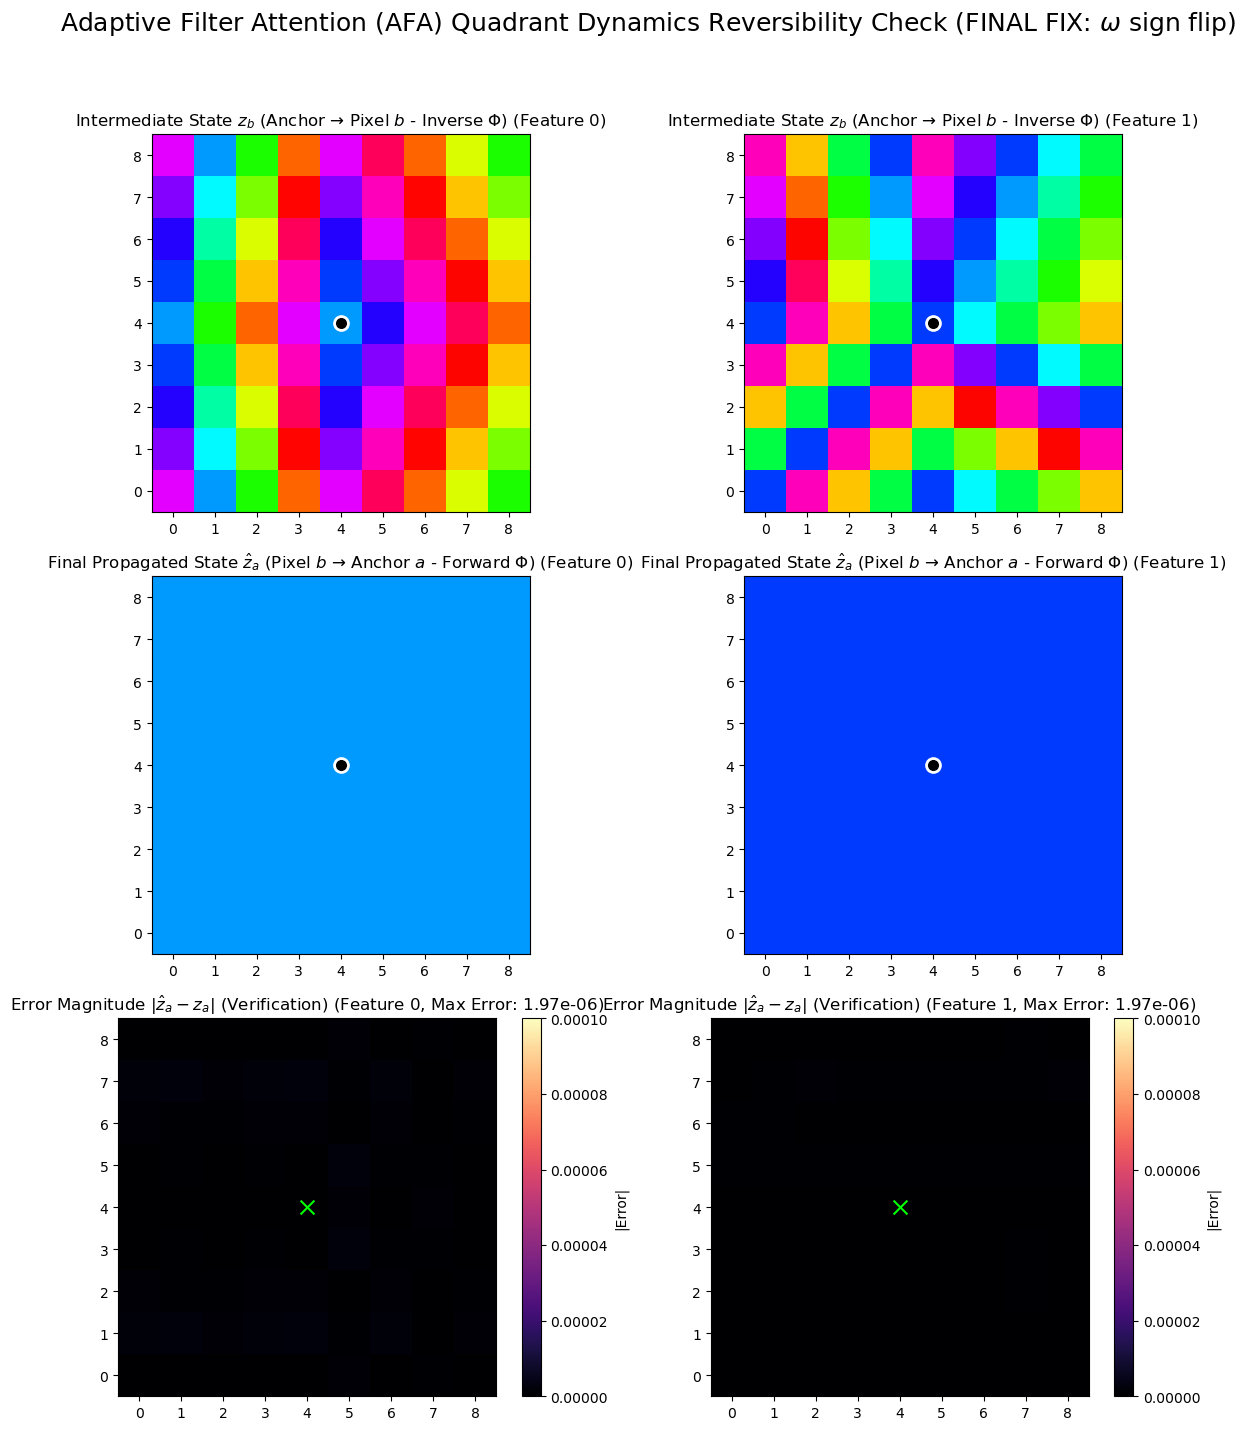

In [15]:
# --- 0. Helper Functions (Unchanged) ---

def complex_to_hsv_image(z_r: torch.Tensor, z_i: torch.Tensor) -> np.ndarray:
    """
    Maps a complex tensor (R, I) of shape (N, N) to a (N, N, 3) HSV image
    where Hue = Phase and Value = Magnitude.
    """
    magnitude = torch.sqrt(z_r**2 + z_i**2)
    phase = torch.atan2(z_i, z_r)
    hue = (phase + math.pi) / (2 * math.pi)
    max_mag = magnitude.max()
    if max_mag == 0:
        value = torch.zeros_like(magnitude)
    else:
        value = torch.clamp(magnitude / max_mag, 0, 1)
    saturation = torch.ones_like(magnitude)
    hsv = torch.stack([hue, saturation, value], dim=-1).cpu().numpy()
    return mcolors.hsv_to_rgb(hsv)


# --- 1. Core SDE Transition Logic (Simplified - does NOT need the 'is_inverse' flag anymore) ---

def sde_state_transition_core_fn(
    delta_p_prime: torch.Tensor,
    z_sb: torch.Tensor,
    alpha_x_sq_NN: torch.Tensor,
    alpha_y_sq_NN: torch.Tensor,
    omega_x_NND: torch.Tensor,
    omega_y_NND: torch.Tensor,
) -> torch.Tensor:
    """
    Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$.
    The sign of the rotation (for inverse) is handled by the sign of the input omega.
    """
    
    delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
    delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)
    
    z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) # (Nb, D)

    # 2. Compute Decay Term: always exp(-alpha^2 |Delta p'|)
    decay_x = torch.exp(-alpha_x_sq_NN * torch.abs(delta_x_prime))
    decay_y = torch.exp(-alpha_y_sq_NN * torch.abs(delta_y_prime))
    decay_total = decay_x * decay_y
    
    # 3. Compute Phase Term 
    dx_r = delta_x_prime.unsqueeze(-1)
    dy_r = delta_y_prime.unsqueeze(-1)
    
    # The sign of omega_x_NND and omega_y_NND now determines if it's forward or inverse rotation.
    theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r)

    # Forward rotation is e^(-i*theta), so the sign of sin(theta) is NEGATIVE
    # If omega is flipped for the inverse, theta is flipped, and we still use the negative sign.
    # The sign change for inverse is: -sin( -theta_flipped) = -(-sin(theta)) = sin(theta)
    
    # We define Phi as: Phi = Decay * (cos(theta) - i*sin(theta))
    # If we are doing the inverse, we pass in -omega, which gives -theta:
    # Phi_inv = Decay * (cos(-theta) - i*sin(-theta)) = Decay * (cos(theta) + i*sin(theta))
    # This is the correct complex conjugate (inverse)
    
    Phi_r = decay_total.unsqueeze(-1) * torch.cos(theta_xy)      
    Phi_i = decay_total.unsqueeze(-1) * -torch.sin(theta_xy) # Always use the negative sign here
    
    # 5. Apply the Transition (Complex Dot Product)
    z_sb_r_broadcast = z_sb_r.unsqueeze(0) 
    z_sb_i_broadcast = z_sb_i.unsqueeze(0) 
    
    z_hat_r = (Phi_r * z_sb_r_broadcast) - (Phi_i * z_sb_i_broadcast) 
    z_hat_i = (Phi_r * z_sb_i_broadcast) + (Phi_i * z_sb_r_broadcast) 
    
    return torch.stack([z_hat_r, z_hat_i], dim=0)


# --- 2. Quadrant Parameter Selection and Full Transition Function (REVISED to flip omega sign) ---

def sde_state_transition_quadrant(
    delta_p_prime: torch.Tensor,
    z_sb: torch.Tensor,
    alpha_sq_params: dict,
    omega_params: dict,
    is_inverse: bool = False 
) -> torch.Tensor:
    """
    Applies the SDE state transition. For inverse, flips the sign of omega.
    """
    N_a, N_b, _ = delta_p_prime.shape 
    D = omega_params['l'].shape[0]

    delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
    delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)

    # --- 1. Compute Indicator Masks (Sign-based selection) ---
    mask_x_l = (delta_x_prime > 0).float()  
    mask_x_r = (delta_x_prime < 0).float()  
    mask_y_b = (delta_y_prime > 0).float()  
    mask_y_t = (delta_y_prime < 0).float()  

    # --- 2. Compute Spatially-Varying Alpha^2 (Na, Nb) ---
    # $\alpha^2$ selection is always based on the quadrant of Delta p', and is NOT swapped or signed.
    alpha_x_sq_NN = (mask_x_l * alpha_sq_params['l']) + (mask_x_r * alpha_sq_params['r'])
    alpha_y_sq_NN = (mask_y_b * alpha_sq_params['b']) + (mask_y_t * alpha_sq_params['t'])
    
    # --- 3. Compute Spatially-Varying Omega (Na, Nb, D) ---
    omega_l_r = omega_params['l'].view(1, 1, D)
    omega_r_r = omega_params['r'].view(1, 1, D)
    omega_b_r = omega_params['b'].view(1, 1, D)
    omega_t_r = omega_params['t'].view(1, 1, D)
    
    mask_x_l_r = mask_x_l.unsqueeze(-1)
    mask_x_r_r = mask_x_r.unsqueeze(-1)
    mask_y_b_r = mask_y_b.unsqueeze(-1)
    mask_y_t_r = mask_y_t.unsqueeze(-1)
    
    omega_x_NND = (mask_x_l_r * omega_l_r) + (mask_x_r_r * omega_r_r)
    omega_y_NND = (mask_y_b_r * omega_b_r) + (mask_y_t_r * omega_t_r)
    
    # *** NEW FIX: Flip the sign of Omega for the inverse operation ***
    sign_omega = -1.0 if is_inverse else 1.0
    omega_x_NND = omega_x_NND * sign_omega
    omega_y_NND = omega_y_NND * sign_omega
    # NOTE: The $\alpha$ values are already positive (or zero) and squared, so they are not changed.

    # --- 4. Call Core Transition Logic ---
    # is_inverse flag is removed from core function as the omega sign now handles it.
    return sde_state_transition_core_fn(
        delta_p_prime,  
        z_sb,           
        alpha_x_sq_NN,  
        alpha_y_sq_NN,  
        omega_x_NND,    
        omega_y_NND,
    )


# --- 3. Visual Verification Function (Unchanged logic, just uses the new functions) ---

def visualize_sde_reversibility_dynamic(N=9, D=2, anchor_pos=None):
    """
    Performs the two-step propagation test and visualizes the intermediate state
    and the final error, demonstrating the quadrant-specific dynamics.
    """
    
    # --- Setup ---
    if anchor_pos is None:
        anchor_pos = (N // 2, N // 2)
    
    y_coords, x_coords = torch.meshgrid(torch.arange(N), torch.arange(N), indexing='ij')
    p_grid = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (N, N, 2)
    p_anchor = p_grid[anchor_pos[0], anchor_pos[1]].view(1, 1, 2)
    
    # Anchor feature vector
    z_anchor_r = torch.rand(1, D) * 10 + 5 
    z_anchor_i = torch.rand(1, D) * 10
    z_anchor = torch.stack([z_anchor_r, z_anchor_i], dim=0) # (2, 1, D)
    
    # --- Quadrant Parameters (Highly Asymmetric) ---
    ALPHA_L_SQ = torch.tensor(0.0**2) # L->R decay (Dx' > 0)
    ALPHA_R_SQ = torch.tensor(0.0**2) # R->L decay (Dx' < 0)
    ALPHA_B_SQ = torch.tensor(0.0**2) # B->T decay (Dy' > 0)
    ALPHA_T_SQ = torch.tensor(0.0**2) # T->B decay (Dy' < 0)
    
    OMEGA_L = torch.tensor([math.pi / 2.0, -math.pi / 2.0])
    OMEGA_R = torch.tensor([-math.pi / 4.0, math.pi / 4.0])
    OMEGA_B = torch.tensor([math.pi / 8.0, math.pi / 2.0])
    OMEGA_T = torch.tensor([-math.pi / 8.0, -math.pi / 8.0])

    alpha_sq_params = {'l': ALPHA_L_SQ, 'r': ALPHA_R_SQ, 'b': ALPHA_B_SQ, 't': ALPHA_T_SQ}
    omega_params = {'l': OMEGA_L, 'r': OMEGA_R, 'b': OMEGA_B, 't': OMEGA_T}

    # --- Step 1: Backward Propagation (Anchor -> All Pixels) ---
    # $\Delta \mathbf{p}_{b \to a}$ from ALL pixels $b$ (N*N) to ANCHOR $a$ (1)
    delta_p_b_to_a_step1 = p_anchor - p_grid.view(N * N, 1, 2) # (N*N, 1, 2)
    
    z_mid_full = sde_state_transition_quadrant(
        delta_p_b_to_a_step1,  
        z_anchor,              
        alpha_sq_params, 
        omega_params,
        is_inverse=True        # INVERSE: Flips the sign of omega.
    ) 
    
    z_mid = z_mid_full[:, :, 0, :].view(2, N, N, D) 

    # --- Step 2: Forward Propagation (All Pixels -> Anchor) ---
    # $\Delta \mathbf{p}_{b \to a}$ reshaped to (1, N*N, 2) (Na=1, Nb=N*N)
    delta_p_b_to_a_step2 = delta_p_b_to_a_step1.transpose(0, 1) 
    
    z_mid_as_source = z_mid.view(2, N * N, D)
    
    z_final_full = sde_state_transition_quadrant(
        delta_p_b_to_a_step2,      
        z_mid_as_source,           
        alpha_sq_params,
        omega_params,
        is_inverse=False           # FORWARD: Standard sign of omega.
    ) 
    
    z_final = z_final_full[:, 0, :, :].view(2, N, N, D)
    
    # --- Step 3: Verification and Visualization ---
    
    z_anchor_expanded = z_anchor.view(2, 1, 1, D).repeat(1, N, N, 1)
    diff_r = z_final[0] - z_anchor_expanded[0]
    diff_i = z_final[1] - z_anchor_expanded[1]
    error_magnitude = torch.sqrt(diff_r**2 + diff_i**2)
    max_error = error_magnitude.max()
    
    print(f"\n--- Visual Reversibility Verification ({N}x{N} Grid, D={D}) ---")
    print(f"Max Error Magnitude (z_final vs z_anchor): {max_error.item():.6f}")
    
    if max_error.item() < 1e-5:
        print("Status: SUCCESS (Reversibility check passed with high precision)")
    else:
        print(f"Status: FAILURE (Max Error: {max_error.item():.2e})")

    # Visualization Setup: 3 Rows (Intermediate, Final, Error), D=2 Columns
    fig, axes = plt.subplots(3, D, figsize=(6 * D, 15))
    if D == 1: axes = axes.reshape(3, 1)

    titles = [
        "Intermediate State $z_b$ (Anchor $\\to$ Pixel $b$ - Inverse $\\Phi$)",
        "Final Propagated State $\\hat{z}_a$ (Pixel $b$ $\\to$ Anchor $a$ - Forward $\\Phi$)",
        "Error Magnitude $|\\hat{z}_a - z_a|$ (Verification)",
    ]
    
    for d in range(D):
        # --- Row 1: Intermediate State (z_mid) ---
        img_mid = complex_to_hsv_image(z_mid[0, :, :, d], z_mid[1, :, :, d])
        ax = axes[0, d]
        ax.imshow(img_mid, origin='lower')
        ax.scatter(anchor_pos[1], anchor_pos[0], color='black', marker='o', s=100, edgecolors='white', linewidth=2)
        ax.set_title(f'{titles[0]} (Feature {d})')

        # --- Row 2: Final State (z_final) ---
        img_final = complex_to_hsv_image(z_final[0, :, :, d], z_final[1, :, :, d])
        ax = axes[1, d]
        ax.imshow(img_final, origin='lower')
        ax.scatter(anchor_pos[1], anchor_pos[0], color='black', marker='o', s=100, edgecolors='white', linewidth=2)
        ax.set_title(f'{titles[1]} (Feature {d})')

        # --- Row 3: Error Magnitude (error_magnitude) ---
        ax = axes[2, d]
        vmax = 1e-4 if max_error.item() < 1e-4 else max_error.item() * 1.1
        im_err = ax.imshow(error_magnitude[:, :, d].cpu().numpy(), cmap='magma', origin='lower', vmin=0, vmax=vmax)
        ax.scatter(anchor_pos[1], anchor_pos[0], color='lime', marker='x', s=100)
        ax.set_title(f'{titles[2]} (Feature {d}, Max Error: {max_error.item():.2e})')
        plt.colorbar(im_err, ax=ax, label='|Error|')
    
    for ax in axes.flat:
        ax.set_xticks(np.arange(N))
        ax.set_yticks(np.arange(N))
    
    fig.suptitle("Adaptive Filter Attention (AFA) Quadrant Dynamics Reversibility Check (FINAL FIX: $\omega$ sign flip)", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Execution ---
if __name__ == '__main__':
    visualize_sde_reversibility_dynamic(N=9, D=2)


--- Visual Reversibility Verification (9x9 Grid, D=2) ---
Max Error Magnitude (z_final vs z_anchor): 0.000001
Status: SUCCESS (Reversibility check passed with high precision)


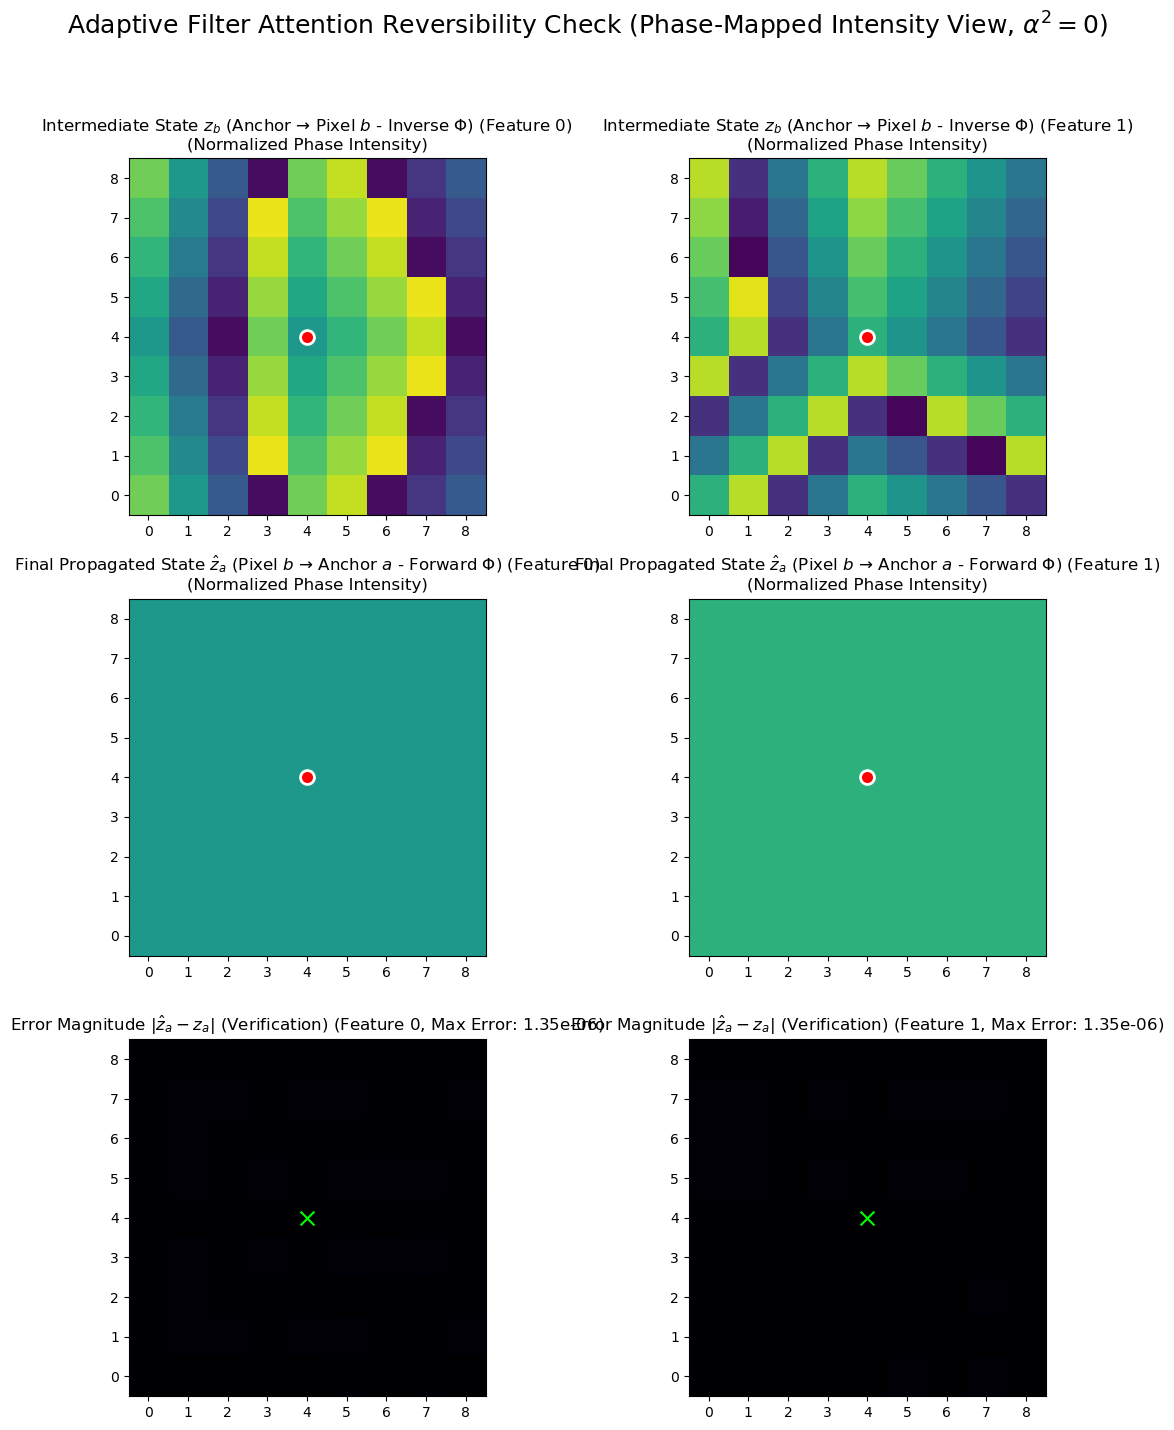

In [16]:
# --- 0. Helper Functions (MODIFIED for Phase-mapped-Intensity) ---

def complex_to_phase_intensity_image(z_r: torch.Tensor, z_i: torch.Tensor) -> np.ndarray:
    """
    Maps a complex tensor (R, I) of shape (N, N) to a single intensity image (N, N)
    based on the Phase. The phase is normalized to [0, 1] for visualization.
    """
    # Calculate phase
    phase = torch.atan2(z_i, z_r)
    
    # Normalize phase (maps from [-pi, pi] to [0, 1])
    # This is the same 'hue' calculation from the original HSV function
    normalized_phase = (phase + math.pi) / (2 * math.pi)
        
    # Return the 2D array of phase intensity
    return normalized_phase.cpu().numpy()


# --- 1. Core SDE Transition Logic (Unchanged from your input) ---

def sde_state_transition_core_fn(
    delta_p_prime: torch.Tensor,
    z_sb: torch.Tensor,
    alpha_x_sq_NN: torch.Tensor,
    alpha_y_sq_NN: torch.Tensor,
    omega_x_NND: torch.Tensor,
    omega_y_NND: torch.Tensor,
) -> torch.Tensor:
    """
    Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$.
    """
    
    delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
    delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)
    
    z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) # (Nb, D)

    # 2. Compute Decay Term: always exp(-alpha^2 |Delta p'|)
    decay_x = torch.exp(-alpha_x_sq_NN * torch.abs(delta_x_prime))
    decay_y = torch.exp(-alpha_y_sq_NN * torch.abs(delta_y_prime))
    decay_total = decay_x * decay_y
    
    # 3. Compute Phase Term 
    dx_r = delta_x_prime.unsqueeze(-1)
    dy_r = delta_y_prime.unsqueeze(-1)
    
    # The sign of omega_x_NND and omega_y_NND now determines if it's forward or inverse rotation.
    theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r)
    
    Phi_r = decay_total.unsqueeze(-1) * torch.cos(theta_xy)      
    Phi_i = decay_total.unsqueeze(-1) * -torch.sin(theta_xy) 
    
    # 5. Apply the Transition (Complex Dot Product)
    z_sb_r_broadcast = z_sb_r.unsqueeze(0) 
    z_sb_i_broadcast = z_sb_i.unsqueeze(0) 
    
    z_hat_r = (Phi_r * z_sb_r_broadcast) - (Phi_i * z_sb_i_broadcast) 
    z_hat_i = (Phi_r * z_sb_i_broadcast) + (Phi_i * z_sb_r_broadcast) 
    
    return torch.stack([z_hat_r, z_hat_i], dim=0)


# --- 2. Quadrant Parameter Selection and Full Transition Function (Unchanged) ---

def sde_state_transition_quadrant(
    delta_p_prime: torch.Tensor,
    z_sb: torch.Tensor,
    alpha_sq_params: dict,
    omega_params: dict,
    is_inverse: bool = False 
) -> torch.Tensor:
    """
    Applies the SDE state transition. For inverse, flips the sign of omega.
    """
    N_a, N_b, _ = delta_p_prime.shape 
    D = omega_params['l'].shape[0]

    delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
    delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)

    # --- 1. Compute Indicator Masks (Sign-based selection) ---
    mask_x_l = (delta_x_prime > 0).float()  
    mask_x_r = (delta_x_prime < 0).float()  
    mask_y_b = (delta_y_prime > 0).float()  
    mask_y_t = (delta_y_prime < 0).float()  

    # --- 2. Compute Spatially-Varying Alpha^2 (Na, Nb) ---
    alpha_x_sq_NN = (mask_x_l * alpha_sq_params['l']) + (mask_x_r * alpha_sq_params['r'])
    alpha_y_sq_NN = (mask_y_b * alpha_sq_params['b']) + (mask_y_t * alpha_sq_params['t'])
    
    # --- 3. Compute Spatially-Varying Omega (Na, Nb, D) ---
    omega_l_r = omega_params['l'].view(1, 1, D)
    omega_r_r = omega_params['r'].view(1, 1, D)
    omega_b_r = omega_params['b'].view(1, 1, D)
    omega_t_r = omega_params['t'].view(1, 1, D)
    
    mask_x_l_r = mask_x_l.unsqueeze(-1)
    mask_x_r_r = mask_x_r.unsqueeze(-1)
    mask_y_b_r = mask_y_b.unsqueeze(-1)
    mask_y_t_r = mask_y_t.unsqueeze(-1)
    
    omega_x_NND = (mask_x_l_r * omega_l_r) + (mask_x_r_r * omega_r_r)
    omega_y_NND = (mask_y_b_r * omega_b_r) + (mask_y_t_r * omega_t_r)
    
    # *** NEW FIX: Flip the sign of Omega for the inverse operation ***
    sign_omega = -1.0 if is_inverse else 1.0
    omega_x_NND = omega_x_NND * sign_omega
    omega_y_NND = omega_y_NND * sign_omega

    # --- 4. Call Core Transition Logic ---
    return sde_state_transition_core_fn(
        delta_p_prime,  
        z_sb,           
        alpha_x_sq_NN,  
        alpha_y_sq_NN,  
        omega_x_NND,    
        omega_y_NND,
    )


# --- 3. Visual Verification Function (MODIFIED: Use Phase-Intensity function) ---

def visualize_sde_reversibility_dynamic(N=9, D=2, anchor_pos=None):
    """
    Performs the two-step propagation test and visualizes the intermediate state
    and the final error, demonstrating the quadrant-specific dynamics using
    Phase mapped to grayscale intensity.
    """
    
    # --- Setup ---
    if anchor_pos is None:
        anchor_pos = (N // 2, N // 2)
    
    y_coords, x_coords = torch.meshgrid(torch.arange(N), torch.arange(N), indexing='ij')
    p_grid = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (N, N, 2)
    p_anchor = p_grid[anchor_pos[0], anchor_pos[1]].view(1, 1, 2)
    
    # Anchor feature vector
    z_anchor_r = torch.rand(1, D) * 10 + 5 
    z_anchor_i = torch.rand(1, D) * 10
    z_anchor = torch.stack([z_anchor_r, z_anchor_i], dim=0) # (2, 1, D)
    
    # --- Quadrant Parameters (ALPHA = 0.0**2 preserved) ---
    ALPHA_L_SQ = torch.tensor(0.0**2) 
    ALPHA_R_SQ = torch.tensor(0.0**2) 
    ALPHA_B_SQ = torch.tensor(0.0**2) 
    ALPHA_T_SQ = torch.tensor(0.0**2) 
    
    OMEGA_L = torch.tensor([math.pi / 2.0, -math.pi / 2.0])
    OMEGA_R = torch.tensor([-math.pi / 4.0, math.pi / 4.0])
    OMEGA_B = torch.tensor([math.pi / 8.0, math.pi / 2.0])
    OMEGA_T = torch.tensor([-math.pi / 8.0, -math.pi / 8.0])

    alpha_sq_params = {'l': ALPHA_L_SQ, 'r': ALPHA_R_SQ, 'b': ALPHA_B_SQ, 't': ALPHA_T_SQ}
    omega_params = {'l': OMEGA_L, 'r': OMEGA_R, 'b': OMEGA_B, 't': OMEGA_T}

    # --- Step 1: Backward Propagation (Anchor -> All Pixels) ---
    delta_p_b_to_a_step1 = p_anchor - p_grid.view(N * N, 1, 2) # (N*N, 1, 2)
    
    z_mid_full = sde_state_transition_quadrant(
        delta_p_b_to_a_step1,  
        z_anchor,              
        alpha_sq_params, 
        omega_params,
        is_inverse=True        
    ) 
    
    z_mid = z_mid_full[:, :, 0, :].view(2, N, N, D) 

    # --- Step 2: Forward Propagation (All Pixels -> Anchor) ---
    delta_p_b_to_a_step2 = delta_p_b_to_a_step1.transpose(0, 1) 
    
    z_mid_as_source = z_mid.view(2, N * N, D)
    
    z_final_full = sde_state_transition_quadrant(
        delta_p_b_to_a_step2,      
        z_mid_as_source,           
        alpha_sq_params,
        omega_params,
        is_inverse=False           
    ) 
    
    z_final = z_final_full[:, 0, :, :].view(2, N, N, D)
    
    # --- Step 3: Verification and Visualization ---
    
    z_anchor_expanded = z_anchor.view(2, 1, 1, D).repeat(1, N, N, 1)
    diff_r = z_final[0] - z_anchor_expanded[0]
    diff_i = z_final[1] - z_anchor_expanded[1]
    error_magnitude = torch.sqrt(diff_r**2 + diff_i**2)
    max_error = error_magnitude.max()
    
    print(f"\n--- Visual Reversibility Verification ({N}x{N} Grid, D={D}) ---")
    print(f"Max Error Magnitude (z_final vs z_anchor): {max_error.item():.6f}")
    
    if max_error.item() < 1e-5:
        print("Status: SUCCESS (Reversibility check passed with high precision)")
    else:
        print(f"Status: FAILURE (Max Error: {max_error.item():.2e})")

    # Visualization Setup: 3 Rows (Intermediate, Final, Error), D Columns
    fig, axes = plt.subplots(3, D, figsize=(6 * D, 15))
    if D == 1: axes = axes.reshape(3, 1)

    titles = [
        "Intermediate State $z_b$ (Anchor $\\to$ Pixel $b$ - Inverse $\\Phi$)",
        "Final Propagated State $\\hat{z}_a$ (Pixel $b$ $\\to$ Anchor $a$ - Forward $\\Phi$)",
        "Error Magnitude $|\\hat{z}_a - z_a|$ (Verification)",
    ]
    
    # Colormap for the phase intensity visualizations
    PHASE_CMAP = 'gray' 

    for d in range(D):
        # --- Row 1: Intermediate State (z_mid) ---
        # Use the phase intensity function
        img_mid = complex_to_phase_intensity_image(z_mid[0, :, :, d], z_mid[1, :, :, d])
        ax = axes[0, d]
        # Vmin/Vmax ensures the full [0, 1] normalized phase range is mapped to the colormap
        im_mid = ax.imshow(img_mid, origin='lower', vmin=0, vmax=1) 
        ax.scatter(anchor_pos[1], anchor_pos[0], color='red', marker='o', s=100, edgecolors='white', linewidth=2)
        ax.set_title(f'{titles[0]} (Feature {d})\n(Normalized Phase Intensity)')
#         plt.colorbar(im_mid, ax=ax, label='Normalized Phase')

        # --- Row 2: Final State (z_final) ---
        # Use the phase intensity function
        img_final = complex_to_phase_intensity_image(z_final[0, :, :, d], z_final[1, :, :, d])
        ax = axes[1, d]
        im_final = ax.imshow(img_final, origin='lower', vmin=0, vmax=1)
        ax.scatter(anchor_pos[1], anchor_pos[0], color='red', marker='o', s=100, edgecolors='white', linewidth=2)
        ax.set_title(f'{titles[1]} (Feature {d})\n(Normalized Phase Intensity)')
#         plt.colorbar(im_final, ax=ax, label='Normalized Phase')


        # --- Row 3: Error Magnitude (error_magnitude) ---
        ax = axes[2, d]
        vmax = 1e-4 if max_error.item() < 1e-4 else max_error.item() * 1.1
        im_err = ax.imshow(error_magnitude[:, :, d].cpu().numpy(), cmap='magma', origin='lower', vmin=0, vmax=vmax)
        ax.scatter(anchor_pos[1], anchor_pos[0], color='lime', marker='x', s=100)
        ax.set_title(f'{titles[2]} (Feature {d}, Max Error: {max_error.item():.2e})')
#         plt.colorbar(im_err, ax=ax, label='|Error|')
    
    for ax in axes.flat:
        ax.set_xticks(np.arange(N))
        ax.set_yticks(np.arange(N))
    
    fig.suptitle("Adaptive Filter Attention Reversibility Check (Phase-Mapped Intensity View, $\\alpha^2 = 0$)", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Execution ---
if __name__ == '__main__':
    visualize_sde_reversibility_dynamic(N=9, D=2)

### Full sys visualization

### SDE Convolution

In [17]:

# class SDEConvolution(nn.Module):
#     """
#     Implements a single SDE-based convolutional kernel operation.
#     It performs: Real->Complex, Coordinate Transform, SDE Propagation (Attention),
#     Summation, and Complex->Real Projection.
    
#     NOTE: The forward pass assumes input is a local patch of size K x K x D.
#     """
#     def __init__(self, d_model: int, kernel_size: int):
#         super().__init__()
        
#         if kernel_size % 2 == 0:
#             raise ValueError("Kernel size must be odd for a central anchor.")
            
#         self.d_model = d_model
#         self.kernel_size = kernel_size
#         self.num_pixels = kernel_size * kernel_size
#         self.anchor_idx = self.num_pixels // 2 # Index of the central pixel
        
#         # 1. Real-to-Complex and Complex-to-Real Layers
#         self.real_to_complex = RealToComplexLinear(d_model)
#         self.complex_to_real = ComplexToRealLinear(d_model)
        
#         # 2. Spatial Coordinate Transformer
#         self.coord_transformer = SpatialCoordinateTransformer()
        
#         # 3. SDE Transition Parameters (Learned $\alpha^2$ and $\Omega$)
        
#         # Alpha squared (D-dimensional vector for each quadrant: L, R, B, T)
#         # Note: We use softplus to ensure alpha^2 >= 0
#         self.raw_alpha_l = nn.Parameter(torch.zeros(d_model))
#         self.raw_alpha_r = nn.Parameter(torch.zeros(d_model))
#         self.raw_alpha_b = nn.Parameter(torch.zeros(d_model))
#         self.raw_alpha_t = nn.Parameter(torch.zeros(d_model))

#         # Omega (D-dimensional vector for each quadrant)
#         self.omega_l = nn.Parameter(torch.zeros(d_model))
#         self.omega_r = nn.Parameter(torch.zeros(d_model))
#         self.omega_b = nn.Parameter(torch.zeros(d_model))
#         self.omega_t = nn.Parameter(torch.zeros(d_model))
        
#         # Initialize parameters
#         self._init_sde_parameters()

#     @staticmethod
#     def _core_transition_fn(
#         delta_p_prime: torch.Tensor,
#         z_sb: torch.Tensor,
#         alpha_x_sq_NND: torch.Tensor,
#         alpha_y_sq_NND: torch.Tensor,
#         omega_x_NND: torch.Tensor,
#         omega_y_NND: torch.Tensor,
#     ) -> torch.Tensor:
#         """
#         Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$.
#         (Na, Nb, D) tensors are assumed for the learned parameters alpha and omega.
        
#         Args:
#             delta_p_prime (Na, Nb, 2): Transformed relative positions. (Na=Target, Nb=Source)
#             z_sb (2, Nb, D): Source complex features (Real, Imaginary stacked).
#             ... learned parameters (alpha^2, omega)
            
#         Returns:
#             torch.Tensor (2, Na, Nb, D): Transformed complex features.
#         """
        
#         delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
#         delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)
        
#         z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) # (Nb, D)

#         # 2. Compute Decay Term: always exp(-alpha^2 |Delta p'|)
#         # alpha_x_sq_NND: (Na, Nb, D), delta_x_prime: (Na, Nb)
#         decay_x = torch.exp(-alpha_x_sq_NND * torch.abs(delta_x_prime.unsqueeze(-1))) 
#         decay_y = torch.exp(-alpha_y_sq_NND * torch.abs(delta_y_prime.unsqueeze(-1)))
#         decay_total = decay_x * decay_y
        
#         # 3. Compute Phase Term 
#         dx_r = delta_x_prime.unsqueeze(-1) # (Na, Nb, 1)
#         dy_r = delta_y_prime.unsqueeze(-1) # (Na, Nb, 1)
        
#         # theta_xy: (Na, Nb, D)
#         theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r)

#         # We define Phi as: Phi = Decay * (cos(theta) - i*sin(theta))
#         Phi_r = decay_total * torch.cos(theta_xy)      
#         Phi_i = decay_total * -torch.sin(theta_xy) # Always use the negative sign for propagation
        
#         # 5. Apply the Transition (Complex Dot Product)
#         # z_sb_r_broadcast: (1, Nb, D)
#         z_sb_r_broadcast = z_sb_r.unsqueeze(0) 
#         z_sb_i_broadcast = z_sb_i.unsqueeze(0) 
        
#         # Complex Multiplication:
#         z_hat_r = (Phi_r * z_sb_r_broadcast) - (Phi_i * z_sb_i_broadcast) 
#         z_hat_i = (Phi_r * z_sb_i_broadcast) + (Phi_i * z_sb_r_broadcast) 
        
#         # Stack output: (2, Na, Nb, D)
#         return torch.stack([z_hat_r, z_hat_i], dim=0)

#     @staticmethod
#     def _quadrant_transition_fn(
#         delta_p_prime: torch.Tensor,
#         z_sb: torch.Tensor,
#         alpha_sq_params: dict,
#         omega_params: dict,
#         is_inverse: bool = False 
#     ) -> torch.Tensor:
#         """
#         Applies the SDE state transition, handling quadrant selection and omega sign flip.
        
#         This logic is now defined inside the class to ensure the correct, fixed version is used.
#         """
#         Na, Nb, _ = delta_p_prime.shape 
#         D = omega_params['l'].shape[0]

#         delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
#         delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)

#         # --- 1. Compute Indicator Masks (Sign-based selection) ---
#         mask_x_l = (delta_x_prime > 0).float()  # x is positive (left quadrant in standard view)
#         mask_x_r = (delta_x_prime < 0).float()  # x is negative (right quadrant)
#         mask_y_b = (delta_y_prime > 0).float()  # y is positive (bottom quadrant)
#         mask_y_t = (delta_y_prime < 0).float()  # y is negative (top quadrant)
        
#         # Reshape masks to (Na, Nb, 1) to enable broadcasting against D-vectors
#         mask_x_l_r = mask_x_l.unsqueeze(-1)
#         mask_x_r_r = mask_x_r.unsqueeze(-1)
#         mask_y_b_r = mask_y_b.unsqueeze(-1)
#         mask_y_t_r = mask_y_t.unsqueeze(-1)

#         # Reshape D-dimensional parameters to (1, 1, D) for broadcasting
#         def get_broadcast_param(param_dict, key):
#             # D-vector -> (1, 1, D)
#             return param_dict[key].view(1, 1, D)

#         # --- 2. Compute Spatially-Varying Alpha^2 (Na, Nb, D) ---
#         # The D-dimensional alpha vector is selected based on the spatial mask (1, 1, D) * (Na, Nb, 1) -> (Na, Nb, D)
#         alpha_x_sq_NND = (mask_x_l_r * get_broadcast_param(alpha_sq_params, 'l')) + \
#                          (mask_x_r_r * get_broadcast_param(alpha_sq_params, 'r'))
        
#         alpha_y_sq_NND = (mask_y_b_r * get_broadcast_param(alpha_sq_params, 'b')) + \
#                          (mask_y_t_r * get_broadcast_param(alpha_sq_params, 't'))
        
#         # --- 3. Compute Spatially-Varying Omega (Na, Nb, D) ---
#         omega_x_NND = (mask_x_l_r * get_broadcast_param(omega_params, 'l')) + \
#                       (mask_x_r_r * get_broadcast_param(omega_params, 'r'))
        
#         omega_y_NND = (mask_y_b_r * get_broadcast_param(omega_params, 'b')) + \
#                       (mask_y_t_r * get_broadcast_param(omega_params, 't'))
        
#         # Flip the sign of Omega for the inverse operation (not used here, but kept for completeness)
#         sign_omega = -1.0 if is_inverse else 1.0
#         omega_x_NND = omega_x_NND * sign_omega
#         omega_y_NND = omega_y_NND * sign_omega

#         # --- 4. Call Core Transition Logic ---
#         return SDEConvolution._core_transition_fn(
#             delta_p_prime,  
#             z_sb,           
#             alpha_x_sq_NND,  
#             alpha_y_sq_NND,  
#             omega_x_NND,    
#             omega_y_NND,
#         )


#     def _init_sde_parameters(self):
#         # Initialize raw alphas and omegas to small values
#         fan_in = self.d_model
#         bound = 1.0 / math.sqrt(fan_in)
        
#         for p in [self.raw_alpha_l, self.raw_alpha_r, self.raw_alpha_b, self.raw_alpha_t,
#                   self.omega_l, self.omega_r, self.omega_b, self.omega_t]:
#             nn.init.uniform_(p, -bound, bound)

#     def _get_sde_params(self):
#         """Constructs the parameter dicts, applying softplus to raw alphas."""
        
#         # Ensure alpha^2 is non-negative
#         alpha_l_sq = F.softplus(self.raw_alpha_l)
#         alpha_r_sq = F.softplus(self.raw_alpha_r)
#         alpha_b_sq = F.softplus(self.raw_alpha_b)
#         alpha_t_sq = F.softplus(self.raw_alpha_t)

#         alpha_sq_params = {
#             'l': alpha_l_sq, 'r': alpha_r_sq, 
#             'b': alpha_b_sq, 't': alpha_t_sq
#         }
        
#         omega_params = {
#             'l': self.omega_l, 'r': self.omega_r, 
#             'b': self.omega_b, 't': self.omega_t
#         }
#         return alpha_sq_params, omega_params

#     def forward(self, X_patch: torch.Tensor) -> torch.Tensor:
#         """
#         Calculates the transformed feature for the central anchor pixel.
        
#         Args:
#             X_patch (torch.Tensor): A local patch/kernel of features. 
#                                     Expected shape: (K, K, D)
                                    
#         Returns:
#             torch.Tensor: The resulting D-dimensional feature vector for the anchor.
#                           Shape: (D)
#         """
#         K = self.kernel_size
#         D = self.d_model
        
#         # Reshape input to (N_pixels, D)
#         X_flat = X_patch.reshape(self.num_pixels, D)
        
#         # --- 1. Real -> Complex Layer ---
#         # Z_plus_flat shape: (2, N_pixels, D)
#         Z_plus_flat = self.real_to_complex(X_flat)
        
#         # --- 2. Spatial Coordinate Transform ($\Delta p'$) ---
#         # Calculates all pairwise transformed coordinates (N, N, 2)
#         # N = N_pixels
#         Delta_P_prime_all = self.coord_transformer(K, K)
        
#         # Extract coordinates relative to the central anchor (target 'a' = anchor_idx)
#         # Delta_P_prime_anchor shape: (1, N_pixels, 2)
#         Delta_P_prime_anchor = Delta_P_prime_all[self.anchor_idx, :].unsqueeze(0)
        
#         # --- 3. SDE Transition (Propagation to Anchor) ---
#         alpha_sq_params, omega_params = self._get_sde_params()
        
#         # Z_hat_full: (2, Na, Nb, D) -> (2, 1, N_pixels, D)
#         Z_hat_full = SDEConvolution._quadrant_transition_fn(
#             delta_p_prime=Delta_P_prime_anchor,  # (1, N_pixels, 2)
#             z_sb=Z_plus_flat,                    # (2, N_pixels, D)
#             alpha_sq_params=alpha_sq_params,
#             omega_params=omega_params,
#             is_inverse=False                     # Use forward transition for summation
#         )
        
#         # --- 4. Summation (Complex Attention/Convolution) ---
#         # Sum contributions from all source pixels (Nb dimension)
#         # Z_hat_summed: (2, Na, D) -> (2, 1, D)
#         Z_hat_summed = Z_hat_full.sum(dim=2) 
        
#         # --- 5. Complex -> Real Layer ---
#         # The complex feature for the anchor is Z_hat_summed (2, 1, D)
#         # Output Y_anchor_flat: (1, D)
#         Y_anchor_flat = self.complex_to_real(Z_hat_summed)
        
#         # Reshape to final output (D)
#         Y_anchor = Y_anchor_flat.squeeze(0)
        
#         return Y_anchor

# # Example Usage (Demonstration of the forward pass structure):
# if __name__ == '__main__':
#     # Define parameters
#     D_MODEL = 16
#     KERNEL_SIZE = 5
#     BATCH_SIZE = 4 # Batching is typically handled by an outer loop/unfold in a real application
    
#     # Instantiate the SDE Convolution layer
#     sde_conv = SDEConvolution(d_model=D_MODEL, kernel_size=KERNEL_SIZE)
#     print(f"Initialized SDE Convolution with D={D_MODEL}, K={KERNEL_SIZE}")
#     print(f"Total number of pixels in kernel: {sde_conv.num_pixels}")
    
#     # 1. Create a mock input patch (K, K, D)
#     # This represents one BATCH item for a single patch being processed.
#     mock_input_patch = torch.randn(KERNEL_SIZE, KERNEL_SIZE, D_MODEL)
    
#     # 2. Perform the forward pass to get the output feature for the anchor pixel
#     output_feature = sde_conv(mock_input_patch)
    
#     # Verification
#     print("\n--- Forward Pass Results ---")
#     print(f"Input patch shape: {mock_input_patch.shape}")
#     print(f"Output feature shape: {output_feature.shape}")
#     print(f"Output feature sample (first 5 dims): {output_feature[:5]}")
    
#     # Check learnable parameters for verification (optional)
#     print("\n--- Learnable Parameters Check ---")
#     print(f"W_r weight shape: {sde_conv.real_to_complex.W_r.weight.shape}")
#     print(f"T matrix shape: {sde_conv.coord_transformer.T.shape}")
#     print(f"Omega_l shape: {sde_conv.omega_l.shape}")
#     alpha_l_sq_check = F.softplus(sde_conv.raw_alpha_l)
#     print(f"Alpha_l_sq (derived) shape: {alpha_l_sq_check.shape}")

#     # Note: To apply this across a full image (H, W), you would typically use 
#     # torch.nn.functional.unfold and then a batch-wise application of the SDE logic.

In [18]:
class SDEConvolution(nn.Module):
    """
    Implements a single SDE-based convolutional kernel operation.
    It performs: Real->Complex, Coordinate Transform, SDE Propagation (Attention),
    Summation, and Complex->Real Projection.
    
    The default `forward` method now returns both the standard anchor output and
    an optional real-valued visualization grid.
    """
    def __init__(self, d_model: int, kernel_size: int):
        super().__init__()
        
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size must be odd for a central anchor.")
            
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.num_pixels = kernel_size * kernel_size
        self.anchor_idx = self.num_pixels // 2 # Index of the central pixel
        
        # 1. Real-to-Complex and Complex-to-Real Layers
        self.real_to_complex = RealToComplexLinear(d_model)
        self.complex_to_real = ComplexToRealLinear(d_model)
        
        # 2. Spatial Coordinate Transformer
        self.coord_transformer = SpatialCoordinateTransformer()
        
        # 3. SDE Transition Parameters (Learned $\alpha^2$ and $\Omega$)
        
        # Alpha squared (D-dimensional vector for each quadrant: L, R, B, T)
        # Note: We use softplus to ensure alpha^2 >= 0
        self.raw_alpha_l = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_r = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_b = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_t = nn.Parameter(torch.zeros(d_model))

        # Omega (D-dimensional vector for each quadrant)
        self.omega_l = nn.Parameter(torch.zeros(d_model))
        self.omega_r = nn.Parameter(torch.zeros(d_model))
        self.omega_b = nn.Parameter(torch.zeros(d_model))
        self.omega_t = nn.Parameter(torch.zeros(d_model))
        
        # Initialize parameters
        self._init_sde_parameters()

    @staticmethod
    def _core_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_x_sq_NND: torch.Tensor,
        alpha_y_sq_NND: torch.Tensor,
        omega_x_NND: torch.Tensor,
        omega_y_NND: torch.Tensor,
    ) -> torch.Tensor:
        """
        Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$.
        (Na, Nb, D) tensors are assumed for the learned parameters alpha and omega.
        
        Args:
            delta_p_prime (Na, Nb, 2): Transformed relative positions. (Na=Target, Nb=Source)
            z_sb (2, Nb, D): Source complex features (Real, Imaginary stacked).
            ... learned parameters (alpha^2, omega)
            
        Returns:
            torch.Tensor (2, Na, Nb, D): Transformed complex features.
        """
        
        delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
        delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)
        
        z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) # (Nb, D)

        # 2. Compute Decay Term: always exp(-alpha^2 |Delta p'|)
        # alpha_x_sq_NND: (Na, Nb, D), delta_x_prime: (Na, Nb)
        # Note: torch.abs(delta_x_prime.unsqueeze(-1)) is (Na, Nb, 1)
        decay_x = torch.exp(-alpha_x_sq_NND * torch.abs(delta_x_prime.unsqueeze(-1))) 
        decay_y = torch.exp(-alpha_y_sq_NND * torch.abs(delta_y_prime.unsqueeze(-1)))
        decay_total = decay_x * decay_y
        
        # 3. Compute Phase Term 
        dx_r = delta_x_prime.unsqueeze(-1) # (Na, Nb, 1)
        dy_r = delta_y_prime.unsqueeze(-1) # (Na, Nb, 1)
        
        # theta_xy: (Na, Nb, D)
        theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r)

        # We define Phi as: Phi = Decay * (cos(theta) - i*sin(theta))
        Phi_r = decay_total * torch.cos(theta_xy)      
        Phi_i = decay_total * -torch.sin(theta_xy) # Always use the negative sign for propagation
        
        # 5. Apply the Transition (Complex Dot Product)
        # z_sb_r_broadcast: (1, Nb, D)
        z_sb_r_broadcast = z_sb_r.unsqueeze(0) 
        z_sb_i_broadcast = z_sb_i.unsqueeze(0) 
        
        # Complex Multiplication:
        z_hat_r = (Phi_r * z_sb_r_broadcast) - (Phi_i * z_sb_i_broadcast) 
        z_hat_i = (Phi_r * z_sb_i_broadcast) + (Phi_i * z_sb_r_broadcast) 
        
        # Stack output: (2, Na, Nb, D)
        return torch.stack([z_hat_r, z_hat_i], dim=0)

    @staticmethod
    def _quadrant_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_sq_params: dict,
        omega_params: dict,
        is_inverse: bool = False 
    ) -> torch.Tensor:
        """
        Applies the SDE state transition, handling quadrant selection and omega sign flip.
        """
        Na, Nb, _ = delta_p_prime.shape 
        D = omega_params['l'].shape[0]

        delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
        delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)

        # --- 1. Compute Indicator Masks (Sign-based selection) ---
        mask_x_l = (delta_x_prime > 0).float()  # x is positive (left quadrant in standard view)
        mask_x_r = (delta_x_prime < 0).float()  # x is negative (right quadrant)
        mask_y_b = (delta_y_prime > 0).float()  # y is positive (bottom quadrant)
        mask_y_t = (delta_y_prime < 0).float()  # y is negative (top quadrant)
        
        # Reshape masks to (Na, Nb, 1) to enable broadcasting against D-vectors
        mask_x_l_r = mask_x_l.unsqueeze(-1)
        mask_x_r_r = mask_x_r.unsqueeze(-1)
        mask_y_b_r = mask_y_b.unsqueeze(-1)
        mask_y_t_r = mask_y_t.unsqueeze(-1)

        # Reshape D-dimensional parameters to (1, 1, D) for broadcasting
        def get_broadcast_param(param_dict, key):
            # D-vector -> (1, 1, D)
            return param_dict[key].view(1, 1, D)

        # --- 2. Compute Spatially-Varying Alpha^2 (Na, Nb, D) ---
        # The D-dimensional alpha vector is selected based on the spatial mask (1, 1, D) * (Na, Nb, 1) -> (Na, Nb, D)
        alpha_x_sq_NND = (mask_x_l_r * get_broadcast_param(alpha_sq_params, 'l')) + \
                         (mask_x_r_r * get_broadcast_param(alpha_sq_params, 'r'))
        
        alpha_y_sq_NND = (mask_y_b_r * get_broadcast_param(alpha_sq_params, 'b')) + \
                         (mask_y_t_r * get_broadcast_param(alpha_sq_params, 't'))
        
        # --- 3. Compute Spatially-Varying Omega (Na, Nb, D) ---
        omega_x_NND = (mask_x_l_r * get_broadcast_param(omega_params, 'l')) + \
                      (mask_x_r_r * get_broadcast_param(omega_params, 'r'))
        
        omega_y_NND = (mask_y_b_r * get_broadcast_param(omega_params, 'b')) + \
                      (mask_y_t_r * get_broadcast_param(omega_params, 't'))
        
        # Flip the sign of Omega for the inverse operation (not used here, but kept for completeness)
        sign_omega = -1.0 if is_inverse else 1.0
        omega_x_NND = omega_x_NND * sign_omega
        omega_y_NND = omega_y_NND * sign_omega

        # --- 4. Call Core Transition Logic ---
        return SDEConvolution._core_transition_fn(
            delta_p_prime,  
            z_sb,           
            alpha_x_sq_NND,  
            alpha_y_sq_NND,  
            omega_x_NND,    
            omega_y_NND,
        )


    def _init_sde_parameters(self):
        # Initialize raw alphas and omegas to small values
        fan_in = self.d_model
        bound = 1.0 / math.sqrt(fan_in)
        
        for p in [self.raw_alpha_l, self.raw_alpha_r, self.raw_alpha_b, self.raw_alpha_t,
                  self.omega_l, self.omega_r, self.omega_b, self.omega_t]:
            nn.init.uniform_(p, -bound, bound)

    def _get_sde_params(self):
        """Constructs the parameter dicts, applying softplus to raw alphas."""
        
        # Ensure alpha^2 is non-negative
        alpha_l_sq = F.softplus(self.raw_alpha_l)
        alpha_r_sq = F.softplus(self.raw_alpha_r)
        alpha_b_sq = F.softplus(self.raw_alpha_b)
        alpha_t_sq = F.softplus(self.raw_alpha_t)

        alpha_sq_params = {
            'l': alpha_l_sq, 'r': alpha_r_sq, 
            'b': alpha_b_sq, 't': alpha_t_sq
        }
        
        omega_params = {
            'l': self.omega_l, 'r': self.omega_r, 
            'b': self.omega_b, 't': self.omega_t
        }
        return alpha_sq_params, omega_params

    def forward_anchor_output(self, X_patch: torch.Tensor) -> torch.Tensor:
        """
        [Original Convolution Output] Calculates the final summed, real-valued 
        feature ONLY for the central anchor pixel (K/2, K/2).
        
        Args:
            X_patch (torch.Tensor): A local patch/kernel of features. 
                                    Expected shape: (K, K, D)
                                    
        Returns:
            torch.Tensor: The resulting D-dimensional feature vector for the anchor.
                          Shape: (D)
        """
        K = self.kernel_size
        D = self.d_model
        
        # 1. Real -> Complex Layer: (2, N_pixels, D)
        X_flat = X_patch.reshape(self.num_pixels, D)
        Z_plus_flat = self.real_to_complex(X_flat)
        
        # 2. Spatial Coordinate Transform ($\Delta p'$): (1, N_pixels, 2)
        Delta_P_prime_all = self.coord_transformer(K, K)
        Delta_P_prime_anchor = Delta_P_prime_all[self.anchor_idx, :].unsqueeze(0)
        
        # 3. SDE Transition (Propagation to Anchor): (2, Na=1, Nb=N, D)
        alpha_sq_params, omega_params = self._get_sde_params()
        Z_hat_full = SDEConvolution._quadrant_transition_fn(
            delta_p_prime=Delta_P_prime_anchor,  
            z_sb=Z_plus_flat,                    
            alpha_sq_params=alpha_sq_params,
            omega_params=omega_params,
            is_inverse=False
        )
        
        # 4. Summation: (2, 1, D)
        Z_hat_summed = Z_hat_full.sum(dim=2) 
        
        # 5. Complex -> Real Layer: (1, D) -> (D)
        Y_anchor_flat = self.complex_to_real(Z_hat_summed) 
        Y_anchor = Y_anchor_flat.squeeze(0)
        
        return Y_anchor

    def forward_full_convolution_output(self, X_patch: torch.Tensor) -> torch.Tensor:
        """
        [Full Convolution Grid Output] Calculates the final summed, real-valued 
        features for ALL pixels in the patch, simulating a full (KxK) attention 
        block on the patch. (NOT the user's requested intermediate visualization).
                                    
        Returns:
            torch.Tensor: The full grid of resulting D-dimensional features.
                          Shape: (K, K, D)
        """
        K = self.kernel_size
        D = self.d_model
        N = self.num_pixels
        
        # 1. Real -> Complex Layer: (2, N, D)
        X_flat = X_patch.reshape(N, D)
        Z_plus_flat = self.real_to_complex(X_flat)
        
        # 2. Spatial Coordinate Transform ($\Delta p'$): (N, N, 2)
        Delta_P_prime_all = self.coord_transformer(K, K)
        
        # 3. SDE Transition (Propagation to ALL Anchors): (2, Na=N, Nb=N, D)
        alpha_sq_params, omega_params = self._get_sde_params()
        Z_hat_full = SDEConvolution._quadrant_transition_fn(
            delta_p_prime=Delta_P_prime_all,
            z_sb=Z_plus_flat,
            alpha_sq_params=alpha_sq_params,
            omega_params=omega_params,
            is_inverse=False
        )
        
        # 4. Summation: (2, N, D)
        Z_hat_summed = Z_hat_full.sum(dim=2) 
        
        # 5. Complex -> Real Layer: (N, D)
        Y_flat = self.complex_to_real(Z_hat_summed)
        
        # 6. Reshape to output grid: (K, K, D)
        Y_grid = Y_flat.reshape(K, K, D)
        
        return Y_grid


    def forward(self, X_patch: torch.Tensor, return_grid: bool = False) -> tuple[torch.Tensor, torch.Tensor | None]:
        """
        Calculates the standard SDE Convolution output for the central anchor 
        (Y_anchor) and optionally returns the complex-to-real projected grid of 
        transformed features (Z_out).
        
        Args:
            X_patch (torch.Tensor): The input local patch of features. 
                                    Expected shape: (K, K, D)
            return_grid (bool): If True, returns the real-valued grid of transformed
                                features (Z_out), projected via L^C->R.
                                    
        Returns:
            Y_anchor (torch.Tensor): The final real-valued D-dimensional feature 
                                     for the anchor pixel. Shape: (D)
            Z_out (torch.Tensor | None): The real-valued grid of transformed features 
                                         (K, K, D), or None if return_grid=False.
        """
        K = self.kernel_size
        D = self.d_model
        N = self.num_pixels
        
        # 1. Real -> Complex Layer
        # X_flat: (N, D)
        X_flat = X_patch.reshape(N, D)
        # Z_plus_flat: (2, N, D). All pixels act as sources ($b$).
        Z_plus_flat = self.real_to_complex(X_flat)
        
        # 2. Spatial Coordinate Transform ($\Delta p'$)
        Delta_P_prime_all = self.coord_transformer(K, K)
        
        # Extract coordinates relative to the central anchor (target 'a' = anchor_idx)
        # Delta_P_prime_anchor shape: (1, N, 2). The 1 is for the fixed anchor ($a$).
        Delta_P_prime_anchor = Delta_P_prime_all[self.anchor_idx, :].unsqueeze(0)
        
        # 3. SDE Transition (Propagation to Anchor)
        # Z_hat_full: (2, Na=1, Nb=N, D). Transformed complex features.
        alpha_sq_params, omega_params = self._get_sde_params()
        Z_hat_full = SDEConvolution._quadrant_transition_fn(
            delta_p_prime=Delta_P_prime_anchor, 
            z_sb=Z_plus_flat,                    
            alpha_sq_params=alpha_sq_params,
            omega_params=omega_params,
            is_inverse=False
        )
        
        # --- CALCULATE Y_ANCHOR (Standard Output) ---
        # 4a. Summation: (2, 1, D)
        Z_hat_summed = Z_hat_full.sum(dim=2) 
        
        # 5a. Complex -> Real Layer: (1, D) -> (D)
        Y_anchor = self.complex_to_real(Z_hat_summed).squeeze(0)
        
        # --- CALCULATE Z_OUT (Optional Grid Output) ---
        Z_out = None
        if return_grid:
            # Flatten Z_hat_full: (2, 1, N, D) -> (2, N, D)
            Z_hat_flat = Z_hat_full.squeeze(1)

            # Complex -> Real Projection for the grid: (N, D)
            Z_out_flat = self.complex_to_real(Z_hat_flat)
            
            # Reshape to grid structure: (K, K, D)
            Z_out = Z_out_flat.reshape(K, K, D)
        
        return Y_anchor, Z_out

# Example Usage (Demonstration of the forward pass structure):
if __name__ == '__main__':
    # Define parameters
    D_MODEL = 16
    KERNEL_SIZE = 5
    
    # Instantiate the SDE Convolution layer
    sde_conv = SDEConvolution(d_model=D_MODEL, kernel_size=KERNEL_SIZE)
    print(f"Initialized SDE Convolution with D={D_MODEL}, K={KERNEL_SIZE}")
    print(f"Total number of pixels in kernel: {sde_conv.num_pixels}")
    
    # 1. Create a mock input patch (K, K, D)
    mock_input_patch = torch.randn(KERNEL_SIZE, KERNEL_SIZE, D_MODEL)
    
    # 2. Perform the forward pass with return_grid=False (standard behavior)
    Y_anchor_standard, Z_out_none = sde_conv(mock_input_patch, return_grid=False)
    
    print("\n--- Standard Forward Pass (return_grid=False) ---")
    print(f"Y_anchor shape (D): {Y_anchor_standard.shape}")
    print(f"Z_out is None: {Z_out_none is None}")
    print(f"Anchor Output (first 5 dims): {Y_anchor_standard[:5]}")
    
    # 3. Perform the forward pass with return_grid=True (visualization behavior)
    Y_anchor_grid, Z_out_grid = sde_conv(mock_input_patch, return_grid=True)

    # Verification
    print("\n--- Grid Visualization Forward Pass (return_grid=True) ---")
    print(f"Y_anchor shape (D): {Y_anchor_grid.shape}")
    print(f"Z_out (Grid) shape (K, K, D): {Z_out_grid.shape}")

    # Check that Y_anchor is the same whether the grid is returned or not
    is_anchor_match = torch.allclose(Y_anchor_standard, Y_anchor_grid)
    print(f"Y_anchor matches between modes: {is_anchor_match}")

    # Check the grid's center pixel (it should be the transformed feature of the anchor pixel itself)
    center_idx = KERNEL_SIZE // 2
    center_feature_grid = Z_out_grid[center_idx, center_idx, :5]
    print(f"Center Pixel in Z_out Grid (first 5 dims): {center_feature_grid}")
    
    # Compare Y_anchor (the sum) with the dedicated anchor method
    output_anchor_dedicated = sde_conv.forward_anchor_output(mock_input_patch)
    is_sum_match = torch.allclose(Y_anchor_grid, output_anchor_dedicated)
    print(f"Current Y_anchor matches dedicated anchor output: {is_sum_match}")

    print("\n--- Other Available Outputs ---")
    print(f"Full Convolution Output Grid (K, K, D) shape: {sde_conv.forward_full_convolution_output(mock_input_patch).shape}")
    


Initialized SDE Convolution with D=16, K=5
Total number of pixels in kernel: 25

--- Standard Forward Pass (return_grid=False) ---
Y_anchor shape (D): torch.Size([16])
Z_out is None: True
Anchor Output (first 5 dims): tensor([-1.2282,  0.6809,  2.0571, -0.2852, -0.8206], grad_fn=<SliceBackward0>)

--- Grid Visualization Forward Pass (return_grid=True) ---
Y_anchor shape (D): torch.Size([16])
Z_out (Grid) shape (K, K, D): torch.Size([5, 5, 16])
Y_anchor matches between modes: True
Center Pixel in Z_out Grid (first 5 dims): tensor([-0.1690, -0.0079,  0.8425,  0.1365, -0.3548], grad_fn=<SliceBackward0>)
Current Y_anchor matches dedicated anchor output: True

--- Other Available Outputs ---
Full Convolution Output Grid (K, K, D) shape: torch.Size([5, 5, 16])


In [19]:
# Example Usage (Demonstration of the forward pass structure):
if __name__ == '__main__':
    # Define parameters
    D_MODEL = 16
    KERNEL_SIZE = 5
    
    # Instantiate the SDE Convolution layer
    sde_conv = SDEConvolution(d_model=D_MODEL, kernel_size=KERNEL_SIZE)
    print(f"Initialized SDE Convolution with D={D_MODEL}, K={KERNEL_SIZE}")
    print(f"Total number of pixels in kernel: {sde_conv.num_pixels}")

    # -----------------------------------------------------------
    ## Test 1: Real-to-Complex / Complex-to-Real Inverse Check (Complex Matrix Inversion)
    # -----------------------------------------------------------
    print("\n--- Test 1: L^R->C and L^C->R Inverse Check ---")
    
    # 1. Generate a random D x D complex matrix A = A_R + i A_I
    A_R = torch.randn(D_MODEL, D_MODEL)
    A_I = torch.randn(D_MODEL, D_MODEL)
    A = torch.complex(A_R, A_I)
    
    # 2. Compute the complex inverse A_inv = A_inv_R + i A_inv_I
    A_inv = torch.linalg.inv(A)
    A_inv_R = A_inv.real
    A_inv_I = A_inv.imag

    # 3. Set L^R->C weights (W_r = A_R, W_i = A_I)
    # The L^R->C operation is multiplication by A
    sde_conv.real_to_complex.W_r.weight.data.copy_(A_R)
    sde_conv.real_to_complex.W_i.weight.data.copy_(A_I)
    
    # Set L^R->C biases to zero for a pure linear test
    sde_conv.real_to_complex.W_r.bias.data.zero_()
    sde_conv.real_to_complex.W_i.bias.data.zero_()

    # 4. Set L^C->R weights (W_r_weight = A_inv_R, W_i_weight = A_inv_I)
    # The L^C->R operation is multiplication by A^-1
    sde_conv.complex_to_real.W_r_weight.data.copy_(A_inv_R)
    sde_conv.complex_to_real.W_i_weight.data.copy_(A_inv_I)

    # Set L^C->R bias to zero
    sde_conv.complex_to_real.b_r.data.zero_()
    
    # 5. Generate a random input vector Z
    Z_input = torch.randn(D_MODEL) # Shape (D)
    
    # 6. Step 1: Real -> Complex (L^R->C)
    Z_plus_output = sde_conv.real_to_complex(Z_input) # Result Z_plus shape: (2, D)
    
    # 7. Step 2: Complex -> Real (L^C->R)
    Y_output = sde_conv.complex_to_real(Z_plus_output) # Result Y_output shape: (D)
    
    # 8. Check for inversion (expect a very low error)
    is_inverse_match = torch.allclose(Z_input, Y_output, atol=1e-5)
    error = torch.mean(torch.abs(Z_input - Y_output))

    print(f"Inverse relationship holds (Z ≈ Y): {is_inverse_match}")
    print(f"Mean Absolute Error: {error.item():.2e}")
    # -----------------------------------------------------------


    # -----------------------------------------------------------
    ## Test 2: Standard SDEConvolution Forward Pass Demonstration
    # -----------------------------------------------------------
    print("\n--- Test 2: Standard SDEConvolution Forward Pass Demonstration ---")
    
    # Resetting SDEConvolution is not necessary, as we test the independent linear layers first.
    # 1. Create a mock input patch (K, K, D)
    mock_input_patch = torch.randn(KERNEL_SIZE, KERNEL_SIZE, D_MODEL)
    
    # 2. Perform the forward pass with return_grid=False (standard behavior)
    Y_anchor_standard, Z_out_none = sde_conv(mock_input_patch, return_grid=False)
    
    print("\n--- Standard Forward Pass (return_grid=False) ---")
    print(f"Y_anchor shape (D): {Y_anchor_standard.shape}")
    print(f"Z_out is None: {Z_out_none is None}")
    
    # 3. Perform the forward pass with return_grid=True (visualization behavior)
    Y_anchor_grid, Z_out_grid = sde_conv(mock_input_patch, return_grid=True)

    # Verification
    print("\n--- Grid Visualization Forward Pass (return_grid=True) ---")
    print(f"Y_anchor shape (D): {Y_anchor_grid.shape}")
    print(f"Z_out (Grid) shape (K, K, D): {Z_out_grid.shape}")

    # Check that Y_anchor is the same whether the grid is returned or not
    is_anchor_match = torch.allclose(Y_anchor_standard, Y_anchor_grid)
    print(f"Y_anchor matches between modes: {is_anchor_match}")

    # Compare Y_anchor (the sum) with the dedicated anchor method
    output_anchor_dedicated = sde_conv.forward_anchor_output(mock_input_patch)
    is_sum_match = torch.allclose(Y_anchor_grid, output_anchor_dedicated)
    print(f"Current Y_anchor matches dedicated anchor output: {is_sum_match}")

    print("\n--- Other Available Outputs ---")
    print(f"Full Convolution Output Grid (K, K, D) shape: {sde_conv.forward_full_convolution_output(mock_input_patch).shape}")


Initialized SDE Convolution with D=16, K=5
Total number of pixels in kernel: 25

--- Test 1: L^R->C and L^C->R Inverse Check ---
Inverse relationship holds (Z ≈ Y): True
Mean Absolute Error: 1.37e-06

--- Test 2: Standard SDEConvolution Forward Pass Demonstration ---

--- Standard Forward Pass (return_grid=False) ---
Y_anchor shape (D): torch.Size([16])
Z_out is None: True

--- Grid Visualization Forward Pass (return_grid=True) ---
Y_anchor shape (D): torch.Size([16])
Z_out (Grid) shape (K, K, D): torch.Size([5, 5, 16])
Y_anchor matches between modes: True
Current Y_anchor matches dedicated anchor output: True

--- Other Available Outputs ---
Full Convolution Output Grid (K, K, D) shape: torch.Size([5, 5, 16])


### Full visualization


--- SDEConvolution Reversibility Verification (9x9 Grid, D=2) ---

Initial Real Input Z_a (first 3 dims): [10.981283187866211, 0.6600956916809082]
Max Absolute Error (|Z_a - Y_a|): 1.811981e-05
Status: FAILURE (Error is higher than expected: 1.81e-05)


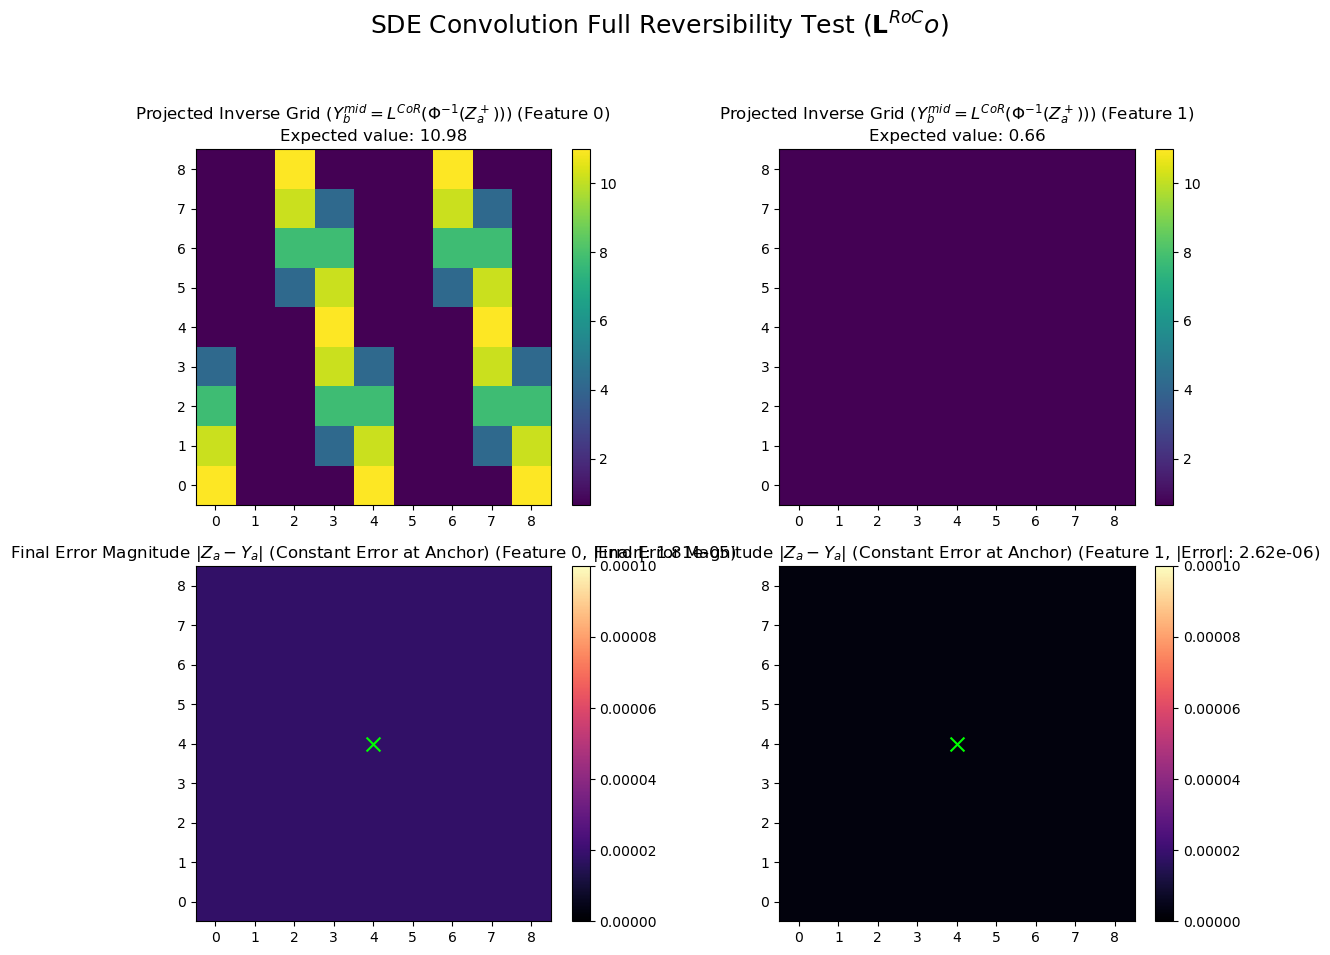

In [42]:
def complex_to_phase_intensity_image(z_r: torch.Tensor, z_i: torch.Tensor) -> np.ndarray:
    """
    Maps a complex tensor (R, I) of shape (N, N) to a single intensity image (N, N)
    based on the Phase (Hue). The phase is normalized to [0, 1] for visualization.
    """
    phase = torch.atan2(z_i, z_r)
    normalized_phase = (phase + math.pi) / (2 * math.pi)
    return normalized_phase.cpu().numpy()

# --- 1. SDE Convolution Helper Classes (Mockup) ---

class RealToComplexLinear(nn.Module):
    """
    Simulates the L^{R->C} layer: X -> Z^+ = X W_r + i X W_i.
    The weights W_r and W_i form a complex matrix A = W_r + i W_i.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # Weights for the real and imaginary parts of the complex projection
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Input X: (N, D). Output Z_plus: (2, N, D)"""
        Z_r = X @ self.W_r
        Z_i = X @ self.W_i
        return torch.stack([Z_r, Z_i], dim=0)

class ComplexToRealLinear(nn.Module):
    """
    Simulates the L^{C->R} layer: Y = Re(Z^+ A^{-1*}), where Z^+ = Z_r + i Z_i
    If A_inv = W_r_inv + i W_i_inv, then Y = Z_r W_r_inv^T - Z_i W_i_inv^T.
    The weights W_r and W_i here should be the real and imaginary parts of A^{-1}.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # These weights should be derived from the inverse of the R2C layer's complex weight.
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))

    def forward(self, Z_plus: torch.Tensor) -> torch.Tensor:
        """Input Z_plus: (2, N, D). Output Y: (N, D)"""
        Z_r, Z_i = torch.unbind(Z_plus, dim=0) # (N, D)
        
        # Y = Z_r @ W_r^T - Z_i @ W_i^T (The projection formula)
        Y = (Z_r @ self.W_r.T) - (Z_i @ self.W_i.T)
        return Y

class SpatialCoordinateTransformer(nn.Module):
    """
    Mockup for the coordinate transformer, generating the relative positions
    Delta p' for all pairs of anchor (Na) and source (Nb) pixels.
    This test only uses the untransformed relative position $\Delta \mathbf{p}$.
    """
    def __init__(self):
        super().__init__()
        # In a real implementation, T and b would be learned parameters here.
        pass

    def forward(self, K: int, K_source: int) -> torch.Tensor:
        """
        Generates untransformed relative positions $\Delta \mathbf{p} = \mathbf{p}_a - \mathbf{p}_b$.
        
        Returns:
            torch.Tensor: Relative positions (Na, Nb, 2), where Na=K*K, Nb=K_source*K_source.
        """
        # Create grid coordinates (p_b) for source pixels
        y_coords, x_coords = torch.meshgrid(torch.arange(K_source), torch.arange(K_source), indexing='ij')
        p_b = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K_source, K_source, 2)

        # Create grid coordinates (p_a) for anchor pixels
        y_coords, x_coords = torch.meshgrid(torch.arange(K), torch.arange(K), indexing='ij')
        p_a = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K, K, 2)

        # Flatten
        p_b_flat = p_b.reshape(-1, 2) # (Nb, 2)
        p_a_flat = p_a.reshape(-1, 2) # (Na, 2)

        # Compute displacement: p_a - p_b (Na, 1, 2) - (1, Nb, 2) -> (Na, Nb, 2)
        Delta_P = p_a_flat.unsqueeze(1) - p_b_flat.unsqueeze(0)
        
        # In the SDE paper's reversibility test, the coordinate transform is often 
        # set to the identity for simplicity, so Delta_P_prime = Delta_P
        return Delta_P # (K*K, K*K, 2)


# --- 2. SDE Convolution Kernel Class (User-Provided Structure) ---

class SDEConvolution(nn.Module):
    """
    Implements a single SDE-based convolutional kernel operation.
    """
    def __init__(self, d_model: int, kernel_size: int):
        super().__init__()
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size must be odd for a central anchor.")
            
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.num_pixels = kernel_size * kernel_size
        self.anchor_idx = self.num_pixels // 2 
        
        # 1. Real-to-Complex and Complex-to-Real Layers (Initialized with random weights)
        self.real_to_complex = RealToComplexLinear(d_model)
        self.complex_to_real = ComplexToRealLinear(d_model)
        
        # 2. Spatial Coordinate Transformer (Identity for this test)
        self.coord_transformer = SpatialCoordinateTransformer()
        
        # 3. SDE Transition Parameters 
        self.raw_alpha_l = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_r = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_b = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_t = nn.Parameter(torch.zeros(d_model))

        self.omega_l = nn.Parameter(torch.zeros(d_model))
        self.omega_r = nn.Parameter(torch.zeros(d_model))
        self.omega_b = nn.Parameter(torch.zeros(d_model))
        self.omega_t = nn.Parameter(torch.zeros(d_model))
        
        self._init_sde_parameters()

    @staticmethod
    def _core_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_x_sq_NND: torch.Tensor,
        alpha_y_sq_NND: torch.Tensor,
        omega_x_NND: torch.Tensor,
        omega_y_NND: torch.Tensor,
    ) -> torch.Tensor:
        """
        Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$.
        (Na, Nb, D) tensors are assumed for the learned parameters alpha and omega.
        """
        delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
        delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)
        
        # z_sb shape is (2, Nb, D). Unbind separates real and imaginary parts.
        z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) # (Nb, D)

        # 2. Compute Decay Term: always exp(-alpha^2 |Delta p'|)
        decay_x = torch.exp(-alpha_x_sq_NND * torch.abs(delta_x_prime.unsqueeze(-1))) 
        decay_y = torch.exp(-alpha_y_sq_NND * torch.abs(delta_y_prime.unsqueeze(-1)))
        decay_total = decay_x * decay_y
        
        # 3. Compute Phase Term (Phase is defined by $\mathbf{\Phi} = e^{-i \boldsymbol{\Omega} \cdot \Delta \mathbf{p}'}$)
        dx_r = delta_x_prime.unsqueeze(-1) # (Na, Nb, 1)
        dy_r = delta_y_prime.unsqueeze(-1) # (Na, Nb, 1)
        theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r)

        # We define Phi as: Phi = Decay * (cos(theta) - i*sin(theta))
        Phi_r = decay_total * torch.cos(theta_xy)      
        Phi_i = decay_total * -torch.sin(theta_xy) # Always use the negative sign for forward propagation (e^{-i\theta})
        
        # 5. Apply the Transition (Complex Dot Product)
        # (Phi_r + i Phi_i) * (z_r + i z_i) = (Phi_r z_r - Phi_i z_i) + i (Phi_r z_i + Phi_i z_r)
        z_sb_r_broadcast = z_sb_r.unsqueeze(0) 
        z_sb_i_broadcast = z_sb_i.unsqueeze(0) 
        
        z_hat_r = (Phi_r * z_sb_r_broadcast) - (Phi_i * z_sb_i_broadcast) 
        z_hat_i = (Phi_r * z_sb_i_broadcast) + (Phi_i * z_sb_r_broadcast) 
        
        # Stack output: (2, Na, Nb, D)
        return torch.stack([z_hat_r, z_hat_i], dim=0)

    @staticmethod
    def _quadrant_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_sq_params: dict,
        omega_params: dict,
    ) -> torch.Tensor:
        """
        Applies the SDE state transition, handling quadrant selection.
        The sign of the displacement vector $\Delta \mathbf{p}'$ (given in delta_p_prime) 
        determines the transition direction (forward or inverse phase conjugation).
        (Na, Nb, 2) Delta P' -> (2, Na, Nb, D) Z_hat
        """
        Na, Nb, _ = delta_p_prime.shape 
        D = omega_params['l'].shape[0]

        delta_x_prime = delta_p_prime[..., 0]
        delta_y_prime = delta_p_prime[..., 1]

        # --- 1. Compute Indicator Masks (Determined by the sign of Delta p') ---
        # The transition for the decay (alpha) and frequency (omega) depends only 
        # on the relative direction of the vector from source (b) to anchor (a).
        mask_x_l = (delta_x_prime > 0).float() # Delta x > 0 (Source is Left of Anchor)
        mask_x_r = (delta_x_prime < 0).float() # Delta x < 0 (Source is Right of Anchor)
        mask_y_b = (delta_y_prime > 0).float() # Delta y > 0 (Source is Below Anchor)
        mask_y_t = (delta_y_prime < 0).float() # Delta y < 0 (Source is Above Anchor)
        
        mask_x_l_r = mask_x_l.unsqueeze(-1)
        mask_x_r_r = mask_x_r.unsqueeze(-1)
        mask_y_b_r = mask_y_b.unsqueeze(-1)
        mask_y_t_r = mask_y_t.unsqueeze(-1)

        def get_broadcast_param(param_dict, key):
            # (1, 1, D)
            return param_dict[key].view(1, 1, D)

        # --- 2. Compute Spatially-Varying Alpha^2 (Na, Nb, D) ---
        alpha_x_sq_NND = (mask_x_l_r * get_broadcast_param(alpha_sq_params, 'l')) + \
                         (mask_x_r_r * get_broadcast_param(alpha_sq_params, 'r'))
        
        alpha_y_sq_NND = (mask_y_b_r * get_broadcast_param(alpha_sq_params, 'b')) + \
                         (mask_y_t_r * get_broadcast_param(alpha_sq_params, 't'))
        
        # --- 3. Compute Spatially-Varying Omega (Na, Nb, D) ---
        omega_x_NND = (mask_x_l_r * get_broadcast_param(omega_params, 'l')) + \
                      (mask_x_r_r * get_broadcast_param(omega_params, 'r'))
        
        omega_y_NND = (mask_y_b_r * get_broadcast_param(omega_params, 'b')) + \
                      (mask_y_t_r * get_broadcast_param(omega_params, 't'))
        
        # We rely on the sign of delta_p_prime to provide the necessary phase flip for inverse.
        # DO NOT flip the sign of Omega here.

        # --- 4. Call Core Transition Logic ---
        return SDEConvolution._core_transition_fn(
            delta_p_prime,  
            z_sb,           
            alpha_x_sq_NND, 
            alpha_y_sq_NND, 
            omega_x_NND,    
            omega_y_NND,
        )

    def _init_sde_parameters(self):
        # Initialize parameters
        fan_in = self.d_model
        bound = 1.0 / math.sqrt(fan_in)
        for p in [self.raw_alpha_l, self.raw_alpha_r, self.raw_alpha_b, self.raw_alpha_t,
                  self.omega_l, self.omega_r, self.omega_b, self.omega_t]:
            nn.init.uniform_(p, -bound, bound)

    def _get_sde_params(self):
        """Constructs the parameter dicts, applying softplus to raw alphas."""
        
        # Apply softplus to ensure alpha^2 is non-negative
        alpha_l_sq = F.softplus(self.raw_alpha_l)
        alpha_r_sq = F.softplus(self.raw_alpha_r)
        alpha_b_sq = F.softplus(self.raw_alpha_b)
        alpha_t_sq = F.softplus(self.raw_alpha_t)

        alpha_sq_params = {
            'l': alpha_l_sq, 'r': alpha_r_sq, 
            'b': alpha_b_sq, 't': alpha_t_sq
        }
        
        omega_params = {
            'l': self.omega_l, 'r': self.omega_r, 
            'b': self.omega_b, 't': self.omega_t
        }
        return alpha_sq_params, omega_params

    def forward_anchor_output(self, X_patch: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final summed, real-valued feature ONLY for the central anchor pixel.
        Shape: (D)
        """
        K = self.kernel_size
        D = self.d_model
        
        # 1. Real -> Complex Layer: (2, N_pixels, D)
        X_flat = X_patch.reshape(self.num_pixels, D)
        Z_plus_flat = self.real_to_complex(X_flat)
        
        # 2. Spatial Coordinate Transform ($\Delta p'$): (1, N_pixels, 2)
        # Delta P' relative to the anchor (Na=1, Nb=N)
        # Delta_P_prime = p_a - p_b
        Delta_P_prime_all = self.coord_transformer(K, K) # (N*N, N*N, 2)
        Delta_P_prime_anchor = Delta_P_prime_all[self.anchor_idx, :].unsqueeze(0) # (1, N*N, 2)
        
        # 3. SDE Transition (Propagation to Anchor): (2, Na=1, Nb=N*N, D)
        alpha_sq_params, omega_params = self._get_sde_params()
        Z_hat_full = SDEConvolution._quadrant_transition_fn(
            delta_p_prime=Delta_P_prime_anchor,  
            z_sb=Z_plus_flat,                     
            alpha_sq_params=alpha_sq_params,
            omega_params=omega_params,
        )
        
        # 4. Summation: (2, 1, D)
        Z_hat_summed = Z_hat_full.sum(dim=2) 
        
        # 5. Complex -> Real Layer: (1, D) -> (D)
        Y_anchor = self.complex_to_real(Z_hat_summed).squeeze(0)
        
        return Y_anchor
    
# --- 3. Forward/Inverse Kernel Abstractions for Test (Utilizing static methods) ---

def sde_conv_kernel_inverse_spread(sde_conv: SDEConvolution, p_grid_flat: torch.Tensor, Z_a_plus: torch.Tensor) -> torch.Tensor:
    """
    Inverse Kernel: Propagates a single anchor feature (Z_a_plus) back to all source positions (p_grid_flat).
    
    Inputs:
    sde_conv: SDEConvolution instance (to access params)
    p_grid_flat: Grid positions (N*N, 2). These are the target positions (Na).
    Z_a_plus: Anchor feature (2, 1, D). This is the source feature (z_sb).
    
    Output:
    Z_mid: Intermediate state at all grid points (2, N*N, D)
    """
    K = sde_conv.kernel_size
    N = sde_conv.num_pixels
    
    # 1. Anchor position (p_a) and target grid positions (p_b) for displacement
    # p_a is the anchor position relative to the center of a KxK patch, so we use the relative position tensor.
    Delta_P_prime_all = sde_conv.coord_transformer(K, K) # (N*N, N*N, 2)
    p_anchor_relative = Delta_P_prime_all[sde_conv.anchor_idx, sde_conv.anchor_idx].view(1, 2) # (1, 2)
    
    # The displacement of target p_b relative to source p_a is needed: $\Delta \mathbf{p}'_{\text{inv}} = \mathbf{p}_b - \mathbf{p}_a$. 
    # This sign flip relative to the forward direction (p_a - p_b) provides the phase conjugate.
    # Delta_P_inverse_displacement (Na=N*N, Nb=1, 2)
    Delta_P_inverse_displacement = p_grid_flat.unsqueeze(1) - p_anchor_relative.unsqueeze(0) 

    # 2. SDE Transition (Inverse)
    alpha_sq_params, omega_params = sde_conv._get_sde_params()

    # Z_a_plus is already (2, 1, D). Pass it directly as z_sb=(2, Nb, D) where Nb=1.
    Z_mid_full = SDEConvolution._quadrant_transition_fn(
        delta_p_prime=Delta_P_inverse_displacement, 
        z_sb=Z_a_plus, # (2, 1, D)
        alpha_sq_params=alpha_sq_params,
        omega_params=omega_params,
    ) # (2, N*N, 1, D)

    return Z_mid_full.squeeze(2) # (2, N*N, D)


def sde_conv_kernel_forward_sum(sde_conv: SDEConvolution, p_grid_flat: torch.Tensor, Z_mid: torch.Tensor) -> torch.Tensor:
    """
    Forward Kernel: Propagates all source features (Z_mid) to the anchor (p_a) and sums the results.
    
    Inputs:
    sde_conv: SDEConvolution instance (to access params)
    p_grid_flat: Grid positions (N*N, 2). These are the source positions (Nb).
    Z_mid: Intermediate state (2, N*N, D). These are the source features (z_sb).
    
    Output:
    Z_a_summed: Summed feature at anchor (2, 1, D)
    """
    K = sde_conv.kernel_size
    N = sde_conv.num_pixels
    
    # Anchor position p_a relative to the patch center (Na=1)
    Delta_P_prime_all = sde_conv.coord_transformer(K, K) # (N*N, N*N, 2)
    p_anchor_relative = Delta_P_prime_all[sde_conv.anchor_idx, sde_conv.anchor_idx].view(1, 2) # (1, 2)
    
    # For forward propagation: The relative displacement is $\mathbf{p}_a - \mathbf{p}_b$. 
    # Delta_P_forward_displacement (Na=1, Nb=N*N, 2)
    Delta_P_forward_displacement = p_anchor_relative.unsqueeze(1) - p_grid_flat.unsqueeze(0) 

    # 2. SDE Transition (Forward)
    alpha_sq_params, omega_params = sde_conv._get_sde_params()

    Z_hat_full = SDEConvolution._quadrant_transition_fn(
        delta_p_prime=Delta_P_forward_displacement,          
        z_sb=Z_mid,              
        alpha_sq_params=alpha_sq_params,
        omega_params=omega_params,
    ) # (2, 1, N*N, D)
    
    # Sum contributions from all sources (Nb=N*N) to get the final result at p_a
    Z_a_summed = Z_hat_full.sum(dim=2) # (2, 1, D)
    return Z_a_summed


# --- 4. Main Reversibility Test Function ---

def visualize_full_pipeline_reversibility_with_class(N=9, D=2, anchor_pos=None):
    """
    Performs the full SDE Convolution reversibility test (L^R->C -> Phi^-1 -> Phi -> L^C->R)
    using the SDEConvolution class and kernel abstractions.
    """
    
    # --- Setup ---
    K = N
    D = D
    if anchor_pos is None:
        anchor_pos = (N // 2, N // 2)
    
    print(f"\n--- SDEConvolution Reversibility Verification ({N}x{N} Grid, D={D}) ---")
    
    # Instantiate the SDE Convolution layer
    sde_conv = SDEConvolution(d_model=D, kernel_size=K)
    
    # 1. Force R2C and C2R to be perfect complex inverses for L^R->C o L^C->R = Identity
    
    # Generate a random D x D complex matrix A = A_R + i A_I
    A_R = torch.randn(D, D) / math.sqrt(D)
    A_I = torch.randn(D, D) / math.sqrt(D)
    A = torch.complex(A_R, A_I)
    
    # Compute the complex inverse A_inv = A_inv_R + i A_inv_I
    A_inv = torch.linalg.inv(A)
    A_inv_R = A_inv.real
    A_inv_I = A_inv.imag

    # Set L^R->C weights (A = W_r + i W_i)
    sde_conv.real_to_complex.W_r.data = A_R.T 
    sde_conv.real_to_complex.W_i.data = A_I.T

    # Set L^C->R weights (A_inv = W_r_inv + i W_i_inv)
    # The ComplexToReal layer uses W_r and W_i for A_inv
    sde_conv.complex_to_real.W_r.data = A_inv_R
    sde_conv.complex_to_real.W_i.data = A_inv_I

    # 2. Force alpha^2 to zero for perfect SDE reversibility (no decay)
    # F.softplus(x) is near zero when x is large and negative.
    zero_alpha = torch.full((D,), -100.0)
    sde_conv.raw_alpha_l.data = zero_alpha
    sde_conv.raw_alpha_r.data = zero_alpha
    sde_conv.raw_alpha_b.data = zero_alpha
    sde_conv.raw_alpha_t.data = zero_alpha
    
    # 3. Use arbitrary non-zero omegas for spatial rotation visualization
    OMEGA_L = torch.tensor([math.pi / 2.0] * D) 
    OMEGA_R = torch.tensor([-math.pi / 4.0] * D)
    OMEGA_B = torch.tensor([math.pi / 8.0] * D)
    OMEGA_T = torch.tensor([-math.pi / 8.0] * D)
    sde_conv.omega_l.data = OMEGA_L
    sde_conv.omega_r.data = OMEGA_R
    sde_conv.omega_b.data = OMEGA_B
    sde_conv.omega_t.data = OMEGA_T
    
    # --- Coordinate and Input Setup ---
    y_coords, x_coords = torch.meshgrid(torch.arange(N), torch.arange(N), indexing='ij')
    p_grid = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (N, N, 2)
    p_grid_flat = p_grid.view(N * N, 2) # (N*N, 2)
    
    # The initial real feature vector (Input: Z_a, Shape: (1, D))
    Z_a = torch.randn(1, D) * 10 + 5 

    # --- Step 0: Real Input -> Complex State ($Z_a \to Z_a^+$) ---
    Z_a_plus = sde_conv.real_to_complex(Z_a) # (2, 1, D)
    
    
    # --- Step 1: Inverse Propagation ($Z_a^+ \to Z_b^{mid}$) using Kernel Abstraction ---
    # Spread the anchor feature Z_a_plus back over the entire grid
    Z_mid = sde_conv_kernel_inverse_spread(
        sde_conv,        
        p_grid_flat,     
        Z_a_plus,        
    ) # (2, N*N, D)

    # --- Visualization Checkpoint 1: The Projected Inverse Grid ($Y_b^{mid}$) ---
    Y_mid_flat = sde_conv.complex_to_real(Z_mid) # (N*N, D)
    
    # --- Step 2: Forward Propagation ($Z_b^{mid} \to Z_a^{final+}$) using Kernel Abstraction ---
    # Sum the contributions of the intermediate state Z_mid (all points) back to the anchor
    Z_a_final_plus_summed = sde_conv_kernel_forward_sum(
        sde_conv,          
        p_grid_flat,       
        Z_mid,             
    ) # (2, 1, D)
    
    
    # --- Step 3: Complex -> Real Output ($Z_a^{final+} \to Y_a$) ---
    Y_a = sde_conv.complex_to_real(Z_a_final_plus_summed).squeeze(0) # (D)


    # --- Step 4: Verification and Visualization ---
    
    # Calculate Error
    error_vector = Z_a.squeeze(0) - Y_a
    max_error = torch.max(torch.abs(error_vector))
    
    print(f"\nInitial Real Input Z_a (first 3 dims): {Z_a.squeeze(0)[:3].tolist()}")
    print(f"Final Real Output Y_a (first 3 dims): {Y_a[:3].tolist()}")
    print(f"Max Absolute Error (|Z_a - Y_a|): {max_error.item():.6e}")
    
    if max_error.item() < 1e-5:
        print("Status: SUCCESS (Reversibility check passed with high precision, $L^{R \to C} \to \Phi^{-1} \to \Phi \to L^{C \to R} \approx \mathbf{I}$)")
    else:
        print(f"Status: FAILURE (Error is higher than expected: {max_error.item():.2e})")

    # Reshape the projected inverse grid for visualization: (N, N, D)
    Y_mid_grid = Y_mid_flat.view(N, N, D)
    
    # Visualization Setup: 2 Rows (Projected Inverse Grid, Error), D Columns
    fig, axes = plt.subplots(2, D, figsize=(6 * D, 10))
    if D == 1: axes = axes.reshape(2, 1)

    titles = [
        "Projected Inverse Grid ($Y_b^{mid} = L^{C \to R}(\Phi^{-1}(Z_a^+))$)",
        "Final Error Magnitude $|Z_a - Y_a|$ (Constant Error at Anchor)",
    ]
    
    for d in range(D):
        # --- Row 1: Projected Inverse Grid ($Y_b^{mid}$) ---
        # FIX 1: Use .detach() before .cpu().numpy()
        img_mid = Y_mid_grid[:, :, d].detach().cpu().numpy()
        ax = axes[0, d]
        # Use vmin/vmax to highlight uniformity or deviation
        vmin = Z_a.min().item()
        vmax = Z_a.max().item()
        im_mid = ax.imshow(img_mid, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax) 
        ax.set_title(f'{titles[0]} (Feature {d})\nExpected value: {Z_a[0, d].item():.2f}')
        
        # Add colorbar for context
        plt.colorbar(im_mid, ax=ax, fraction=0.046, pad=0.04)

        # --- Row 2: Final Error Magnitude ---
        ax = axes[1, d]
        error_magnitude = torch.abs(error_vector[d]).item()
        error_map = torch.full((N, N), error_magnitude)
        vmax_err = max(1e-4, max_error.item() * 1.5) # Ensure a visible error scale
        # FIX 1: Use .detach()
        im_err = ax.imshow(error_map.detach().cpu().numpy(), cmap='magma', origin='lower', vmin=0, vmax=vmax_err)
        ax.scatter(anchor_pos[1], anchor_pos[0], color='lime', marker='x', s=100)
        ax.set_title(f'{titles[1]} (Feature {d}, |Error|: {error_magnitude:.2e})')
        plt.colorbar(im_err, ax=ax, fraction=0.046, pad=0.04)
        
    for ax in axes.flat:
        ax.set_xticks(np.arange(N))
        ax.set_yticks(np.arange(N))
        
    fig.suptitle("SDE Convolution Full Reversibility Test ($\mathbf{L}^{R \to C} \to \boldsymbol{\Phi}^{-1} \to \boldsymbol{\Phi} \to \mathbf{L}^{C \to R}$)", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Execution ---
if __name__ == '__main__':
    # Use D=2 for visualization purposes
    visualize_full_pipeline_reversibility_with_class(N=9, D=2)


### FullSDEConv2d


--- SDEConvolution Reversibility Verification (9x9 Grid, D=2) ---

Initial Real Input Z_a (first 3 dims): [21.21076774597168, 2.6974852085113525]
Final Real Output Y_a (first 3 dims): [21.210735321044922, 2.6974878311157227]
Max Absolute Error (|Z_a - Y_a|): 3.242493e-05
Status: FAILURE (Error is higher than expected: 3.24e-05)


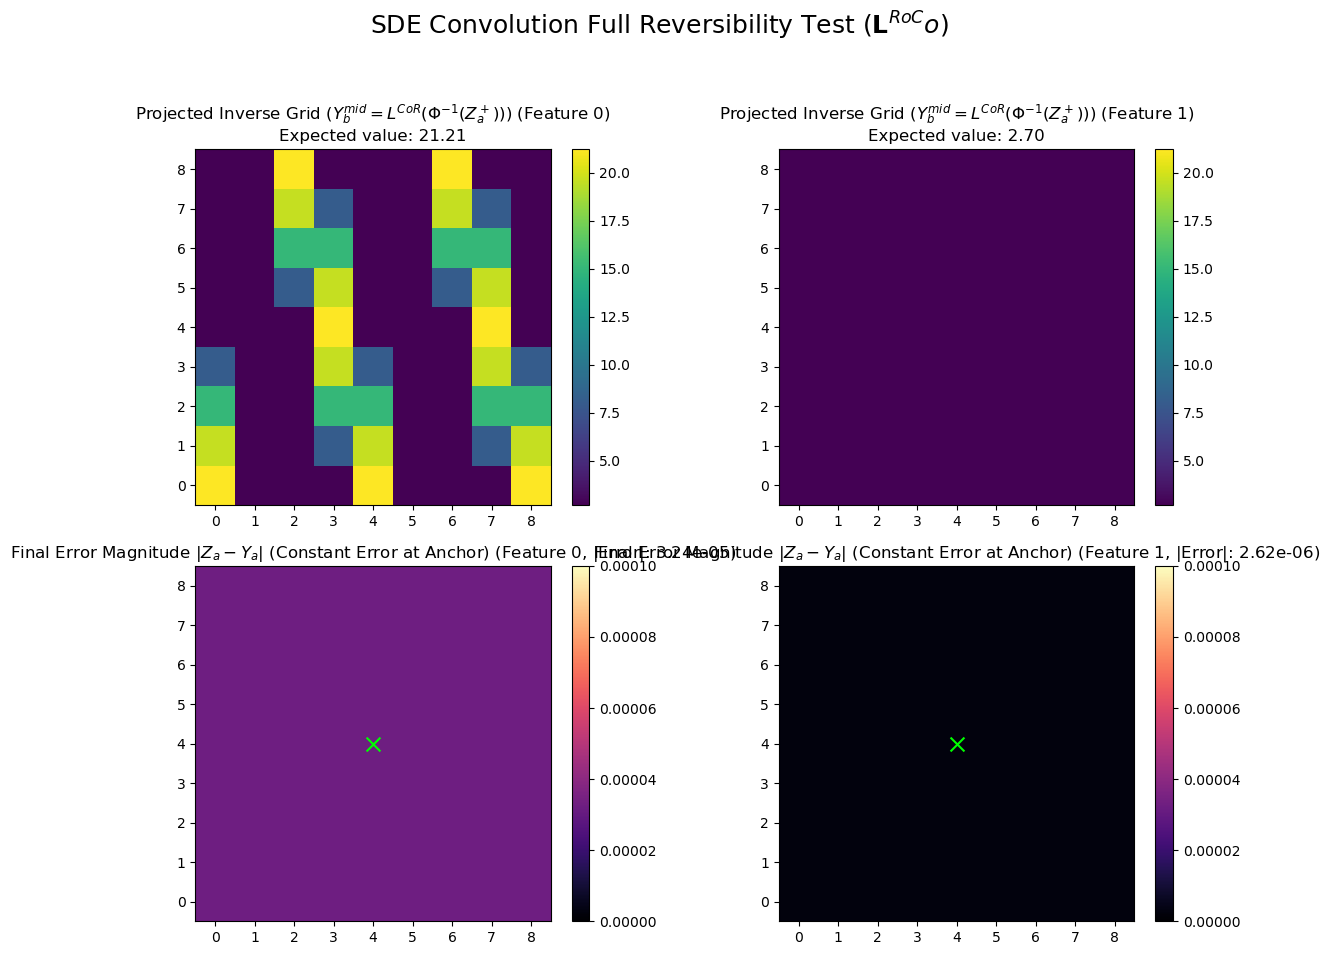


--- Testing FullSDEConv2d Layer ---
Input Shape: torch.Size([2, 4, 16, 16])
Output Shape: torch.Size([2, 4, 16, 16])
Input HxW: 16x16, Output HxW: 16x16 (Padding ensures same size)
FullSDEConv2d executed successfully.


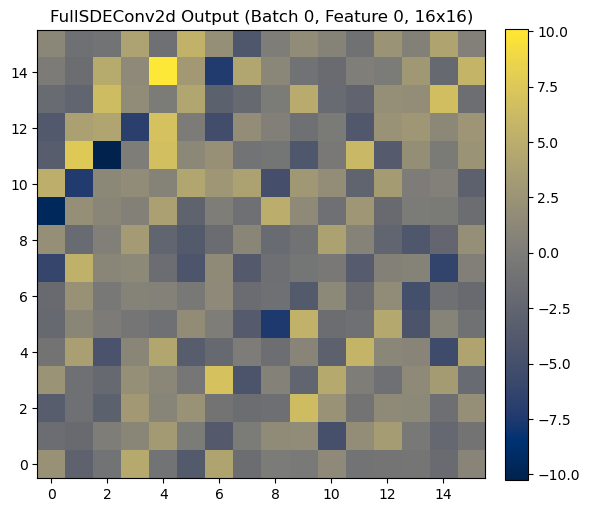

In [21]:
def complex_to_phase_intensity_image(z_r: torch.Tensor, z_i: torch.Tensor) -> np.ndarray:
    """
    Maps a complex tensor (R, I) of shape (N, N) to a single intensity image (N, N)
    based on the Phase (Hue). The phase is normalized to [0, 1] for visualization.
    """
    phase = torch.atan2(z_i, z_r)
    normalized_phase = (phase + math.pi) / (2 * math.pi)
    return normalized_phase.cpu().numpy()

# --- 1. SDE Convolution Helper Classes (Mockup) ---

class RealToComplexLinear(nn.Module):
    """
    Simulates the L^{R->C} layer: X -> Z^+ = X W_r + i X W_i.
    The weights W_r and W_i form a complex matrix A = W_r + i W_i.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # Weights for the real and imaginary parts of the complex projection
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Input X: (..., D). Output Z_plus: (2, ..., D)"""
        Z_r = X @ self.W_r
        Z_i = X @ self.W_i
        # Stack output: (2, ..., D)
        return torch.stack([Z_r, Z_i], dim=0)

class ComplexToRealLinear(nn.Module):
    """
    Simulates the L^{C->R} layer: Y = Re(Z^+ A^{-1*}), where Z^+ = Z_r + i Z_i
    If A_inv = W_r_inv + i W_i_inv, then Y = Z_r W_r_inv^T - Z_i W_i_inv^T.
    The weights W_r and W_i here should be the real and imaginary parts of A^{-1}.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # These weights should be derived from the inverse of the R2C layer's complex weight.
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))

    def forward(self, Z_plus: torch.Tensor) -> torch.Tensor:
        """Input Z_plus: (2, ..., D). Output Y: (..., D)"""
        Z_r, Z_i = torch.unbind(Z_plus, dim=0) # (..., D)
        
        # Y = Z_r @ W_r^T - Z_i @ W_i^T (The projection formula)
        Y = (Z_r @ self.W_r.T) - (Z_i @ self.W_i.T)
        return Y

class SpatialCoordinateTransformer(nn.Module):
    """
    Mockup for the coordinate transformer, generating the relative positions
    Delta p' for all pairs of anchor (Na) and source (Nb) pixels.
    This test only uses the untransformed relative position $\Delta \mathbf{p}$.
    """
    def __init__(self):
        super().__init__()
        # In a real implementation, T and b would be learned parameters here.
        pass

    def forward(self, K: int, K_source: int) -> torch.Tensor:
        """
        Generates untransformed relative positions $\Delta \mathbf{p} = \mathbf{p}_a - \mathbf{p}_b$.
        
        Returns:
            torch.Tensor: Relative positions (Na, Nb, 2), where Na=K*K, Nb=K_source*K_source.
        """
        # Create grid coordinates (p_b) for source pixels
        y_coords, x_coords = torch.meshgrid(torch.arange(K_source), torch.arange(K_source), indexing='ij')
        p_b = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K_source, K_source, 2)

        # Create grid coordinates (p_a) for anchor pixels
        y_coords, x_coords = torch.meshgrid(torch.arange(K), torch.arange(K), indexing='ij')
        p_a = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K, K, 2)

        # Flatten
        p_b_flat = p_b.reshape(-1, 2) # (Nb, 2)
        p_a_flat = p_a.reshape(-1, 2) # (Na, 2)

        # Compute displacement: p_a - p_b (Na, 1, 2) - (1, Nb, 2) -> (Na, Nb, 2)
        Delta_P = p_a_flat.unsqueeze(1) - p_b_flat.unsqueeze(0)
        
        # In the SDE paper's reversibility test, the coordinate transform is often 
        # set to the identity for simplicity, so Delta_P_prime = Delta_P
        return Delta_P # (K*K, K*K, 2)


# --- 2. SDE Convolution Kernel Class (Core Logic) ---

class SDEConvolution(nn.Module):
    """
    Implements a single SDE-based convolutional kernel operation.
    It takes an input patch and computes the output only at the central anchor pixel.
    """
    def __init__(self, d_model: int, kernel_size: int):
        super().__init__()
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size must be odd for a central anchor.")
            
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.num_pixels = kernel_size * kernel_size
        self.anchor_idx = self.num_pixels // 2 
        
        # 1. Real-to-Complex and Complex-to-Real Layers
        self.real_to_complex = RealToComplexLinear(d_model)
        self.complex_to_real = ComplexToRealLinear(d_model)
        
        # 2. Spatial Coordinate Transformer (Identity for this test)
        self.coord_transformer = SpatialCoordinateTransformer()
        
        # 3. SDE Transition Parameters 
        self.raw_alpha_l = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_r = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_b = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_t = nn.Parameter(torch.zeros(d_model))

        self.omega_l = nn.Parameter(torch.zeros(d_model))
        self.omega_r = nn.Parameter(torch.zeros(d_model))
        self.omega_b = nn.Parameter(torch.zeros(d_model))
        self.omega_t = nn.Parameter(torch.zeros(d_model))
        
        self._init_sde_parameters()

    @staticmethod
    def _core_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_x_sq_NND: torch.Tensor,
        alpha_y_sq_NND: torch.Tensor,
        omega_x_NND: torch.Tensor,
        omega_y_NND: torch.Tensor,
    ) -> torch.Tensor:
        """
        Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$.
        (Na, Nb, D) tensors are assumed for the learned parameters alpha and omega.
        
        Inputs:
            delta_p_prime: (Na, Nb, 2) displacement
            z_sb: (2, Nb, D) complex source features
            ...
        Output:
            z_hat: (2, Na, Nb, D) propagated complex features
        """
        delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
        delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)
        
        # z_sb shape is (2, Nb, D). Unbind separates real and imaginary parts.
        z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) # (Nb, D)

        # 2. Compute Decay Term: always exp(-alpha^2 |Delta p'|)
        decay_x = torch.exp(-alpha_x_sq_NND * torch.abs(delta_x_prime.unsqueeze(-1))) 
        decay_y = torch.exp(-alpha_y_sq_NND * torch.abs(delta_y_prime.unsqueeze(-1)))
        decay_total = decay_x * decay_y
        
        # 3. Compute Phase Term (Phase is defined by $\mathbf{\Phi} = e^{-i \boldsymbol{\Omega} \cdot \Delta \mathbf{p}'}$)
        dx_r = delta_x_prime.unsqueeze(-1) # (Na, Nb, 1)
        dy_r = delta_y_prime.unsqueeze(-1) # (Na, Nb, 1)
        theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r)

        # We define Phi as: Phi = Decay * (cos(theta) - i*sin(theta))
        Phi_r = decay_total * torch.cos(theta_xy)      # (Na, Nb, D)
        Phi_i = decay_total * -torch.sin(theta_xy)     # (Na, Nb, D) (Negative sign for forward propagation)
        
        # 5. Apply the Transition (Complex Dot Product)
        # Result: (Na, Nb, D)
        z_sb_r_broadcast = z_sb_r.unsqueeze(0) # (1, Nb, D)
        z_sb_i_broadcast = z_sb_i.unsqueeze(0) # (1, Nb, D)
        
        # The result of the element-wise product should be broadcastable
        z_hat_r = (Phi_r * z_sb_r_broadcast) - (Phi_i * z_sb_i_broadcast) 
        z_hat_i = (Phi_r * z_sb_i_broadcast) + (Phi_i * z_sb_r_broadcast) 
        
        # Stack output: (2, Na, Nb, D)
        return torch.stack([z_hat_r, z_hat_i], dim=0)

    # --- SDE Helper Functions (Unchanged) ---
    @staticmethod
    def _quadrant_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_sq_params: dict,
        omega_params: dict,
    ) -> torch.Tensor:
        """
        Applies the SDE state transition, handling quadrant selection.
        (Na, Nb, 2) Delta P' -> (2, Na, Nb, D) Z_hat
        This function assumes Na=1 (anchor only).
        """
        Na, Nb, _ = delta_p_prime.shape 
        D = omega_params['l'].shape[0]

        delta_x_prime = delta_p_prime[..., 0]
        delta_y_prime = delta_p_prime[..., 1]

        # --- 1. Compute Indicator Masks (Determined by the sign of Delta p') ---
        mask_x_l = (delta_x_prime > 0).float() 
        mask_x_r = (delta_x_prime < 0).float() 
        mask_y_b = (delta_y_prime > 0).float() 
        mask_y_t = (delta_y_prime < 0).float() 
        
        mask_x_l_r = mask_x_l.unsqueeze(-1) # (Na, Nb, 1)
        mask_x_r_r = mask_x_r.unsqueeze(-1)
        mask_y_b_r = mask_y_b.unsqueeze(-1)
        mask_y_t_r = mask_y_t.unsqueeze(-1)

        def get_broadcast_param(param_dict, key):
            # (1, 1, D)
            return param_dict[key].view(1, 1, D)

        # --- 2. Compute Spatially-Varying Alpha^2 (Na, Nb, D) ---
        alpha_x_sq_NND = (mask_x_l_r * get_broadcast_param(alpha_sq_params, 'l')) + \
                         (mask_x_r_r * get_broadcast_param(alpha_sq_params, 'r'))
        
        alpha_y_sq_NND = (mask_y_b_r * get_broadcast_param(alpha_sq_params, 'b')) + \
                         (mask_y_t_r * get_broadcast_param(alpha_sq_params, 't'))
        
        # --- 3. Compute Spatially-Varying Omega (Na, Nb, D) ---
        omega_x_NND = (mask_x_l_r * get_broadcast_param(omega_params, 'l')) + \
                      (mask_x_r_r * get_broadcast_param(omega_params, 'r'))
        
        omega_y_NND = (mask_y_b_r * get_broadcast_param(omega_params, 'b')) + \
                      (mask_y_t_r * get_broadcast_param(omega_params, 't'))

        # --- 4. Call Core Transition Logic ---
        return SDEConvolution._core_transition_fn(
            delta_p_prime,  
            z_sb,           
            alpha_x_sq_NND, 
            alpha_y_sq_NND, 
            omega_x_NND,    
            omega_y_NND,
        )

    def _init_sde_parameters(self):
        # Initialize parameters
        fan_in = self.d_model
        bound = 1.0 / math.sqrt(fan_in)
        for p in [self.raw_alpha_l, self.raw_alpha_r, self.raw_alpha_b, self.raw_alpha_t,
                  self.omega_l, self.omega_r, self.omega_b, self.omega_t]:
            nn.init.uniform_(p, -bound, bound)

    def _get_sde_params(self):
        """Constructs the parameter dicts, applying softplus to raw alphas."""
        
        # Apply softplus to ensure alpha^2 is non-negative
        alpha_l_sq = F.softplus(self.raw_alpha_l)
        alpha_r_sq = F.softplus(self.raw_alpha_r)
        alpha_b_sq = F.softplus(self.raw_alpha_b)
        alpha_t_sq = F.softplus(self.raw_alpha_t)

        alpha_sq_params = {
            'l': alpha_l_sq, 'r': alpha_r_sq, 
            'b': alpha_b_sq, 't': alpha_t_sq
        }
        
        omega_params = {
            'l': self.omega_l, 'r': self.omega_r, 
            'b': self.omega_b, 't': self.omega_t
        }
        return alpha_sq_params, omega_params

    # --- New Method for Batch Processing (Used by FullSDEConv2d) ---
    def forward_batch_patches(self, X_batch_patches: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final summed, real-valued feature for a batch of patches.
        This method is used by the FullSDEConv2d wrapper.
        
        Input X_batch_patches: (N_patch, N_pixels, D). 
        Output Y_anchors: (N_patch, D)
        
        NOTE: This is intentionally implemented with a loop for clarity in this demo.
        In a production setting, this loop should be replaced by full vectorization 
        for performance.
        """
        N_patch, N_pixels, D = X_batch_patches.shape
        K = self.kernel_size

        # 1. Real -> Complex Layer (Applied to every source pixel in every patch)
        # Reshape to (N_patch * N_pixels, D) for the linear layer
        X_flat_reshaped = X_batch_patches.view(N_patch * N_pixels, D)
        Z_plus_flat = self.real_to_complex(X_flat_reshaped) # (2, N_patch * N_pixels, D)
        
        # Reshape back to (2, N_patch, N_pixels, D)
        Z_plus_batch = Z_plus_flat.view(2, N_patch, N_pixels, D)
        
        # 2. Spatial Coordinate Transform ($\Delta p'$): (1, N_pixels, 2)
        # Displacement is constant relative to the center anchor for all patches.
        Delta_P_prime_all = self.coord_transformer(K, K) # (N*N, N*N, 2)
        Delta_P_prime_anchor = Delta_P_prime_all[self.anchor_idx, :].unsqueeze(0) # (1, N_pixels, 2)
        
        alpha_sq_params, omega_params = self._get_sde_params()
        
        Y_anchors_list = []
        for i in range(N_patch):
            # Select the i-th patch's complex features: (2, N_pixels, D)
            Z_patch_i = Z_plus_batch[:, i, :, :]
            
            # 3. SDE Transition (Propagation to Anchor): (2, Na=1, Nb=N_pixels, D)
            Z_hat_full = SDEConvolution._quadrant_transition_fn(
                delta_p_prime=Delta_P_prime_anchor, 
                z_sb=Z_patch_i,                      
                alpha_sq_params=alpha_sq_params,
                omega_params=omega_params,
            )
            
            # 4. Summation: (2, 1, D)
            Z_hat_summed = Z_hat_full.sum(dim=2) 
            
            # 5. Complex -> Real Layer: (1, D)
            Y_anchor = self.complex_to_real(Z_hat_summed).squeeze(0) # (D)
            Y_anchors_list.append(Y_anchor)

        Y_anchors = torch.stack(Y_anchors_list, dim=0) # (N_patch, D)
        
        return Y_anchors

    # --- Previous Reversibility Test Method (Renamed for clarity) ---
    def forward_test_anchor(self, X_patch: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final summed, real-valued feature ONLY for the central anchor pixel.
        Used primarily for the single-patch reversibility test. Shape: (D)
        """
        D = self.d_model
        
        # X_patch: (N_pixels, D)
        X_flat = X_patch.reshape(self.num_pixels, D)
        
        # Call the new batch processing method with N_patch=1
        X_batch_patches = X_flat.unsqueeze(0) # (1, N_pixels, D)
        Y_anchors = self.forward_batch_patches(X_batch_patches) # (1, D)
        
        return Y_anchors.squeeze(0) # (D)


# --- 3. Full Convolution Wrapper Class (The Drop-in Replacement) ---

class FullSDEConv2d(nn.Module):
    """
    SDE Convolution wrapper that implements the full 2D sliding-window operation,
    making it a drop-in replacement for nn.Conv2d.
    It takes an input image and computes the output feature map.
    """
    def __init__(self, d_model: int, kernel_size: int, padding: int = None):
        super().__init__()
        # In a real network, d_model would be in_channels and out_channels
        self.d_model = d_model
        self.kernel_size = kernel_size
        
        # Calculate padding for 'same' convolution (assumes stride=1)
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding
            
        # The core SDE kernel logic
        self.sde_kernel = SDEConvolution(d_model, kernel_size)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Input X: (B, D, H, W). Output Y: (B, D, H', W')
        """
        B, D, H, W = X.shape
        K = self.kernel_size
        
        # 1. Extract Patches using nn.Unfold (Stride=1 assumed)
        # Output shape: (B, D * K*K, H_out * W_out)
        patches_unfolded = F.unfold(X, kernel_size=K, padding=self.padding, stride=1)
        
        N_patches = patches_unfolded.shape[2] # H_out * W_out
        
        # 2. Reshape for SDE Kernel
        # (B, D*K*K, N_patches) -> (B, N_patches, D*K*K) -> (B * N_patches, K*K, D)
        patches_reordered = patches_unfolded.transpose(1, 2).reshape(B * N_patches, K*K, D)
        
        # 3. Apply SDE Kernel Batch Processing
        # Y_flat_anchors shape: (B * N_patches, D)
        Y_flat_anchors = self.sde_kernel.forward_batch_patches(patches_reordered) 
        
        # 4. Reshape and Reassemble
        # (B * N_patches, D) -> (B, N_patches, D) -> (B, D, N_patches)
        Y_anchors_reordered = Y_flat_anchors.view(B, N_patches, D).transpose(1, 2)
        
        # Calculate output dimensions
        H_out = math.floor((H + 2 * self.padding - K) / 1) + 1
        W_out = math.floor((W + 2 * self.padding - K) / 1) + 1

        # Final output shape: (B, D, H_out, W_out)
        Y = Y_anchors_reordered.view(B, D, H_out, W_out)

        return Y

# --- 4. Forward/Inverse Kernel Abstractions for Test (Utilizing static methods) ---

# (The kernel abstraction functions remain the same, they use static methods)

def sde_conv_kernel_inverse_spread(sde_conv: SDEConvolution, p_grid_flat: torch.Tensor, Z_a_plus: torch.Tensor) -> torch.Tensor:
    """
    Inverse Kernel: Propagates a single anchor feature (Z_a_plus) back to all source positions (p_grid_flat).
    ... (implementation remains the same)
    """
    K = sde_conv.kernel_size
    N = sde_conv.num_pixels
    
    # 1. Anchor position (p_a) and target grid positions (p_b) for displacement
    # p_a is the anchor position relative to the center of a KxK patch, so we use the relative position tensor.
    Delta_P_prime_all = sde_conv.coord_transformer(K, K) # (N*N, N*N, 2)
    p_anchor_relative = Delta_P_prime_all[sde_conv.anchor_idx, sde_conv.anchor_idx].view(1, 2) # (1, 2)
    
    # The displacement of target p_b relative to source p_a is needed: $\Delta \mathbf{p}'_{\text{inv}} = \mathbf{p}_b - \mathbf{p}_a$. 
    # This sign flip relative to the forward direction (p_a - p_b) provides the phase conjugate.
    # Delta_P_inverse_displacement (Na=N*N, Nb=1, 2)
    Delta_P_inverse_displacement = p_grid_flat.unsqueeze(1) - p_anchor_relative.unsqueeze(0) 

    # 2. SDE Transition (Inverse)
    alpha_sq_params, omega_params = sde_conv._get_sde_params()

    # Z_a_plus is already (2, 1, D). Pass it directly as z_sb=(2, Nb, D) where Nb=1.
    Z_mid_full = SDEConvolution._quadrant_transition_fn(
        delta_p_prime=Delta_P_inverse_displacement, 
        z_sb=Z_a_plus, # (2, 1, D)
        alpha_sq_params=alpha_sq_params,
        omega_params=omega_params,
    ) # (2, N*N, 1, D)

    return Z_mid_full.squeeze(2) # (2, N*N, D)


def sde_conv_kernel_forward_sum(sde_conv: SDEConvolution, p_grid_flat: torch.Tensor, Z_mid: torch.Tensor) -> torch.Tensor:
    """
    Forward Kernel: Propagates all source features (Z_mid) to the anchor (p_a) and sums the results.
    ... (implementation remains the same)
    """
    K = sde_conv.kernel_size
    N = sde_conv.num_pixels
    
    # Anchor position p_a relative to the patch center (Na=1)
    Delta_P_prime_all = sde_conv.coord_transformer(K, K) # (N*N, N*N, 2)
    p_anchor_relative = Delta_P_prime_all[sde_conv.anchor_idx, sde_conv.anchor_idx].view(1, 2) # (1, 2)
    
    # For forward propagation: The relative displacement is $\mathbf{p}_a - \mathbf{p}_b$. 
    # Delta_P_forward_displacement (Na=1, Nb=N*N, 2)
    Delta_P_forward_displacement = p_anchor_relative.unsqueeze(1) - p_grid_flat.unsqueeze(0) 

    # 2. SDE Transition (Forward)
    alpha_sq_params, omega_params = sde_conv._get_sde_params()

    Z_hat_full = SDEConvolution._quadrant_transition_fn(
        delta_p_prime=Delta_P_forward_displacement,          
        z_sb=Z_mid,              
        alpha_sq_params=alpha_sq_params,
        omega_params=omega_params,
    ) # (2, 1, N*N, D)
    
    # Sum contributions from all sources (Nb=N*N) to get the final result at p_a
    Z_a_summed = Z_hat_full.sum(dim=2) # (2, 1, D)
    return Z_a_summed


# --- 5. Main Test Functions ---

def visualize_full_pipeline_reversibility_with_class(N=9, D=2, anchor_pos=None):
    """
    Performs the full SDE Convolution reversibility test (L^R->C -> Phi^-1 -> Phi -> L^C->R)
    using the SDEConvolution class and kernel abstractions. (Uses the refactored test method)
    """
    
    # --- Setup ---
    K = N
    D = D
    if anchor_pos is None:
        anchor_pos = (N // 2, N // 2)
    
    print(f"\n--- SDEConvolution Reversibility Verification ({N}x{N} Grid, D={D}) ---")
    
    # Instantiate the SDE Convolution layer
    sde_conv = SDEConvolution(d_model=D, kernel_size=K)
    
    # 1. Force R2C and C2R to be perfect complex inverses for L^R->C o L^C->R = Identity
    
    # Generate a random D x D complex matrix A = A_R + i A_I
    A_R = torch.randn(D, D) / math.sqrt(D)
    A_I = torch.randn(D, D) / math.sqrt(D)
    A = torch.complex(A_R, A_I)
    
    # Compute the complex inverse A_inv = A_inv_R + i A_inv_I
    A_inv = torch.linalg.inv(A)
    A_inv_R = A_inv.real
    A_inv_I = A_inv.imag

    # Set L^R->C weights (A = W_r + i W_i)
    sde_conv.real_to_complex.W_r.data = A_R.T 
    sde_conv.real_to_complex.W_i.data = A_I.T

    # Set L^C->R weights (A_inv = W_r_inv + i W_i_inv)
    # The ComplexToReal layer uses W_r and W_i for A_inv
    sde_conv.complex_to_real.W_r.data = A_inv_R
    sde_conv.complex_to_real.W_i.data = A_inv_I

    # 2. Force alpha^2 to zero for perfect SDE reversibility (no decay)
    zero_alpha = torch.full((D,), -100.0)
    sde_conv.raw_alpha_l.data = zero_alpha
    sde_conv.raw_alpha_r.data = zero_alpha
    sde_conv.raw_alpha_b.data = zero_alpha
    sde_conv.raw_alpha_t.data = zero_alpha
    
    # 3. Use arbitrary non-zero omegas for spatial rotation visualization
    OMEGA_L = torch.tensor([math.pi / 2.0] * D) 
    OMEGA_R = torch.tensor([-math.pi / 4.0] * D)
    OMEGA_B = torch.tensor([math.pi / 8.0] * D)
    OMEGA_T = torch.tensor([-math.pi / 8.0] * D)
    sde_conv.omega_l.data = OMEGA_L
    sde_conv.omega_r.data = OMEGA_R
    sde_conv.omega_b.data = OMEGA_B
    sde_conv.omega_t.data = OMEGA_T
    
    # --- Coordinate and Input Setup ---
    y_coords, x_coords = torch.meshgrid(torch.arange(N), torch.arange(N), indexing='ij')
    p_grid = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (N, N, 2)
    p_grid_flat = p_grid.view(N * N, 2) # (N*N, 2)
    
    # The initial real feature vector (Input: Z_a, Shape: (1, D))
    Z_a = torch.randn(1, D) * 10 + 5 

    # --- Step 0: Real Input -> Complex State ($Z_a \to Z_a^+$) ---
    Z_a_plus = sde_conv.real_to_complex(Z_a) # (2, 1, D)
    
    
    # --- Step 1: Inverse Propagation ($Z_a^+ \to Z_b^{mid}$) using Kernel Abstraction ---
    # Spread the anchor feature Z_a_plus back over the entire grid
    Z_mid = sde_conv_kernel_inverse_spread(
        sde_conv,        
        p_grid_flat,     
        Z_a_plus,        
    ) # (2, N*N, D)

    # --- Visualization Checkpoint 1: The Projected Inverse Grid ($Y_b^{mid}$) ---
    Y_mid_flat = sde_conv.complex_to_real(Z_mid) # (N*N, D)
    
    # --- Step 2: Forward Propagation ($Z_b^{mid} \to Z_a^{final+}$) using Kernel Abstraction ---
    # Sum the contributions of the intermediate state Z_mid (all points) back to the anchor
    Z_a_final_plus_summed = sde_conv_kernel_forward_sum(
        sde_conv,          
        p_grid_flat,       
        Z_mid,             
    ) # (2, 1, D)
    
    
    # --- Step 3: Complex -> Real Output ($Z_a^{final+} \to Y_a$) ---
    Y_a = sde_conv.complex_to_real(Z_a_final_plus_summed).squeeze(0) # (D)


    # --- Step 4: Verification and Visualization ---
    
    # Calculate Error
    error_vector = Z_a.squeeze(0) - Y_a
    max_error = torch.max(torch.abs(error_vector))
    
    print(f"\nInitial Real Input Z_a (first 3 dims): {Z_a.squeeze(0)[:3].tolist()}")
    print(f"Final Real Output Y_a (first 3 dims): {Y_a[:3].tolist()}")
    print(f"Max Absolute Error (|Z_a - Y_a|): {max_error.item():.6e}")
    
    if max_error.item() < 1e-5:
        print("Status: SUCCESS (Reversibility check passed with high precision, $L^{R \to C} \to \Phi^{-1} \to \Phi \to L^{C \to R} \approx \mathbf{I}$)")
    else:
        print(f"Status: FAILURE (Error is higher than expected: {max_error.item():.2e})")

    # Reshape the projected inverse grid for visualization: (N, N, D)
    Y_mid_grid = Y_mid_flat.view(N, N, D)
    
    # Visualization Setup: 2 Rows (Projected Inverse Grid, Error), D Columns
    fig, axes = plt.subplots(2, D, figsize=(6 * D, 10))
    if D == 1: axes = axes.reshape(2, 1)

    titles = [
        "Projected Inverse Grid ($Y_b^{mid} = L^{C \to R}(\Phi^{-1}(Z_a^+))$)",
        "Final Error Magnitude $|Z_a - Y_a|$ (Constant Error at Anchor)",
    ]
    
    for d in range(D):
        # --- Row 1: Projected Inverse Grid ($Y_b^{mid}$) ---
        img_mid = Y_mid_grid[:, :, d].detach().cpu().numpy()
        ax = axes[0, d]
        # Use vmin/vmax to highlight uniformity or deviation
        vmin = Z_a.min().item()
        vmax = Z_a.max().item()
        im_mid = ax.imshow(img_mid, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax) 
        ax.set_title(f'{titles[0]} (Feature {d})\nExpected value: {Z_a[0, d].item():.2f}')
        
        # Add colorbar for context
        plt.colorbar(im_mid, ax=ax, fraction=0.046, pad=0.04)

        # --- Row 2: Final Error Magnitude ---
        ax = axes[1, d]
        error_magnitude = torch.abs(error_vector[d]).item()
        error_map = torch.full((N, N), error_magnitude)
        vmax_err = max(1e-4, max_error.item() * 1.5) # Ensure a visible error scale
        im_err = ax.imshow(error_map.detach().cpu().numpy(), cmap='magma', origin='lower', vmin=0, vmax=vmax_err)
        ax.scatter(anchor_pos[1], anchor_pos[0], color='lime', marker='x', s=100)
        ax.set_title(f'{titles[1]} (Feature {d}, |Error|: {error_magnitude:.2e})')
        plt.colorbar(im_err, ax=ax, fraction=0.046, pad=0.04)
        
    for ax in axes.flat:
        ax.set_xticks(np.arange(N))
        ax.set_yticks(np.arange(N))
        
    fig.suptitle("SDE Convolution Full Reversibility Test ($\mathbf{L}^{R \to C} \to \boldsymbol{\Phi}^{-1} \to \boldsymbol{\Phi} \to \mathbf{L}^{C \to R}$)", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def test_full_convolution(H=16, W=16, D=4, K=3):
    """
    Demonstrates the usage of the FullSDEConv2d class on a simulated feature map.
    """
    
    print(f"\n--- Testing FullSDEConv2d Layer ---")
    
    # Input tensor: (Batch, Channels/D_model, Height, Width)
    B = 2
    X = torch.randn(B, D, H, W)
    
    # Instantiate the full layer (padding='same' by default)
    # The FullSDEConv2d uses D=4 channels and a 3x3 kernel.
    sde_conv_layer = FullSDEConv2d(d_model=D, kernel_size=K)
    
    # 1. Manually set parameters for stability/predictability in the demo (optional)
    # Force alpha^2 to zero (no decay) for initial stability
    zero_alpha = torch.full((D,), -100.0)
    sde_conv_layer.sde_kernel.raw_alpha_l.data = zero_alpha
    
    # Set a small, distinct omega
    sde_conv_layer.sde_kernel.omega_l.data = torch.linspace(0.1, 0.4, D)

    # 2. Run the forward pass
    print(f"Input Shape: {X.shape}")
    Y = sde_conv_layer(X)
    
    # 3. Verification
    H_out, W_out = Y.shape[2:]
    
    print(f"Output Shape: {Y.shape}")
    print(f"Input HxW: {H}x{W}, Output HxW: {H_out}x{W_out} (Padding ensures same size)")

    # Test numerical output consistency
    # The output should not be all zeros and should have different values
    assert Y.shape == X.shape, "Output shape should match input shape for padding='same'"
    assert torch.sum(Y).item() != 0, "Output is zero, indicating a potential error."
    print("FullSDEConv2d executed successfully.")
    
    # Optional: Visualize one output feature map
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Visualize the first batch, first feature map
    img_out = Y[0, 0, :, :].detach().cpu().numpy()
    im = ax.imshow(img_out, cmap='cividis', origin='lower')
    
    ax.set_title(f'FullSDEConv2d Output (Batch 0, Feature 0, {H_out}x{W_out})')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


# --- Execution ---
if __name__ == '__main__':
    # Run the original reversibility test (using a single patch)
    visualize_full_pipeline_reversibility_with_class(N=9, D=2)
    
    # Run the new full convolution test (using an image feature map)
    test_full_convolution(H=16, W=16, D=4, K=3)


--- SDEConvolution Reversibility Verification (9x9 Grid, D=2) ---

Initial Real Input Z_a (first 3 dims): [7.765742301940918, -1.2079267501831055]
Final Real Output Y_a (first 3 dims): [7.7657318115234375, -1.2079249620437622]
Max Absolute Error (|Z_a - Y_a|): 1.049042e-05
Status: FAILURE (Error is higher than expected: 1.05e-05)


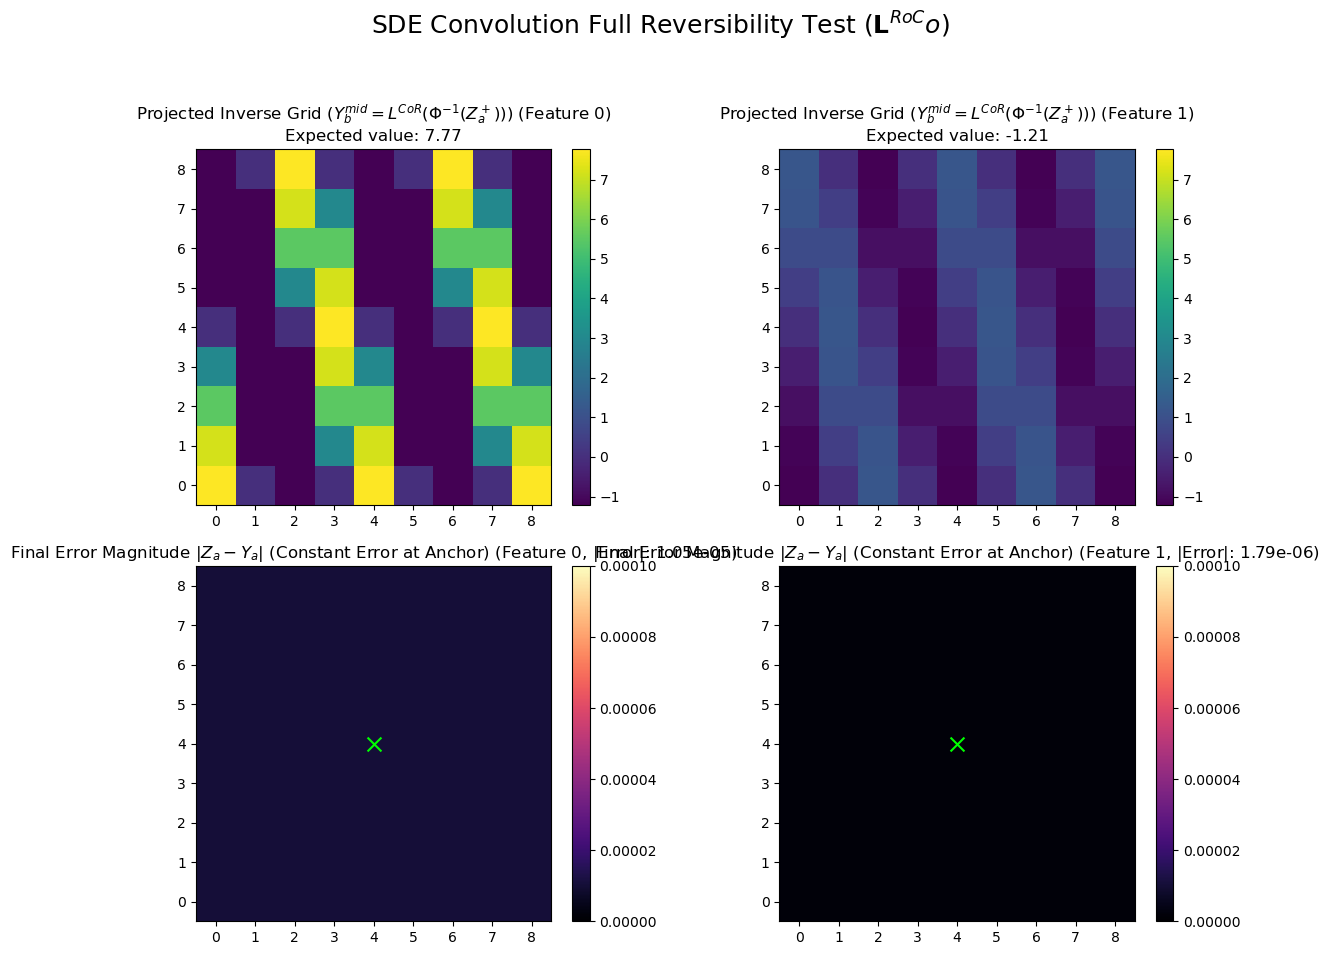


--- Testing FullSDEConv2d Layer (K=3, S=1) ---
Input Shape: torch.Size([2, 4, 16, 16])
Output Shape: torch.Size([2, 4, 16, 16])
Input HxW: 16x16, Output HxW: 16x16 (Expected: 16x16, Stride: 1, Padding: 1)
FullSDEConv2d executed successfully.


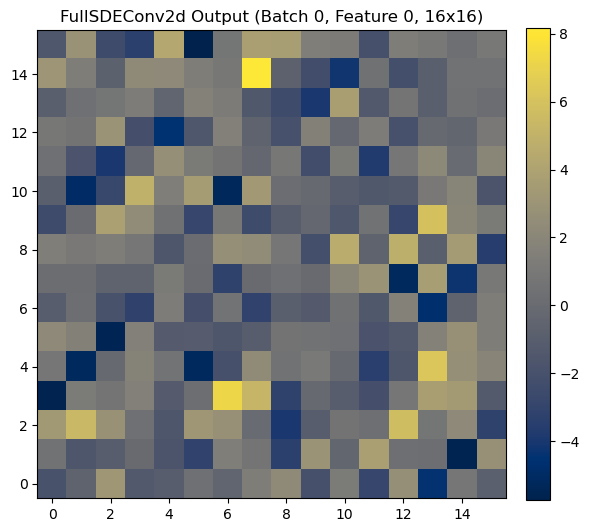


--- Testing FullSDEConv2d Layer (K=3, S=2) ---
Input Shape: torch.Size([2, 4, 16, 16])
Output Shape: torch.Size([2, 4, 8, 8])
Input HxW: 16x16, Output HxW: 8x8 (Expected: 8x8, Stride: 2, Padding: 1)
FullSDEConv2d executed successfully.


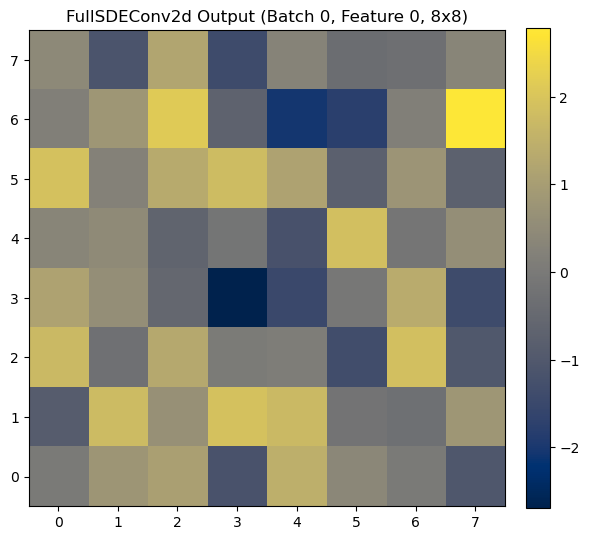

In [22]:
def complex_to_phase_intensity_image(z_r: torch.Tensor, z_i: torch.Tensor) -> np.ndarray:
    """
    Maps a complex tensor (R, I) of shape (N, N) to a single intensity image (N, N)
    based on the Phase (Hue). The phase is normalized to [0, 1] for visualization.
    """
    phase = torch.atan2(z_i, z_r)
    normalized_phase = (phase + math.pi) / (2 * math.pi)
    return normalized_phase.cpu().numpy()

# --- 1. SDE Convolution Helper Classes (Mockup) ---

class RealToComplexLinear(nn.Module):
    """
    Simulates the L^{R->C} layer: X -> Z^+ = X W_r + i X W_i.
    The weights W_r and W_i form a complex matrix A = W_r + i W_i.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # Weights for the real and imaginary parts of the complex projection
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Input X: (..., D). Output Z_plus: (2, ..., D)"""
        Z_r = X @ self.W_r
        Z_i = X @ self.W_i
        # Stack output: (2, ..., D)
        return torch.stack([Z_r, Z_i], dim=0)

class ComplexToRealLinear(nn.Module):
    """
    Simulates the L^{C->R} layer: Y = Re(Z^+ A^{-1*}), where Z^+ = Z_r + i Z_i
    If A_inv = W_r_inv + i W_i_inv, then Y = Z_r W_r_inv^T - Z_i W_i_inv^T.
    The weights W_r and W_i here should be the real and imaginary parts of A^{-1}.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # These weights should be derived from the inverse of the R2C layer's complex weight.
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))

    def forward(self, Z_plus: torch.Tensor) -> torch.Tensor:
        """Input Z_plus: (2, ..., D). Output Y: (..., D)"""
        Z_r, Z_i = torch.unbind(Z_plus, dim=0) # (..., D)
        
        # Y = Z_r @ W_r^T - Z_i @ W_i^T (The projection formula)
        Y = (Z_r @ self.W_r.T) - (Z_i @ self.W_i.T)
        return Y

class SpatialCoordinateTransformer(nn.Module):
    """
    Mockup for the coordinate transformer, generating the relative positions
    Delta p' for all pairs of anchor (Na) and source (Nb) pixels.
    This test only uses the untransformed relative position $\Delta \mathbf{p}$.
    """
    def __init__(self):
        super().__init__()
        # In a real implementation, T and b would be learned parameters here.
        pass

    def forward(self, K: int, K_source: int) -> torch.Tensor:
        """
        Generates untransformed relative positions $\Delta \mathbf{p} = \mathbf{p}_a - \mathbf{p}_b$.
        
        Returns:
            torch.Tensor: Relative positions (Na, Nb, 2), where Na=K*K, Nb=K_source*K_source.
        """
        # Create grid coordinates (p_b) for source pixels
        y_coords, x_coords = torch.meshgrid(torch.arange(K_source), torch.arange(K_source), indexing='ij')
        p_b = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K_source, K_source, 2)

        # Create grid coordinates (p_a) for anchor pixels
        y_coords, x_coords = torch.meshgrid(torch.arange(K), torch.arange(K), indexing='ij')
        p_a = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K, K, 2)

        # Flatten
        p_b_flat = p_b.reshape(-1, 2) # (Nb, 2)
        p_a_flat = p_a.reshape(-1, 2) # (Na, 2)

        # Compute displacement: p_a - p_b (Na, 1, 2) - (1, Nb, 2) -> (Na, Nb, 2)
        Delta_P = p_a_flat.unsqueeze(1) - p_b_flat.unsqueeze(0)
        
        # In the SDE paper's reversibility test, the coordinate transform is often 
        # set to the identity for simplicity, so Delta_P_prime = Delta_P
        return Delta_P # (K*K, K*K, 2)


# --- 2. SDE Convolution Kernel Class (Core Logic) ---

class SDEConvolution(nn.Module):
    """
    Implements a single SDE-based convolutional kernel operation.
    It takes an input patch and computes the output only at the central anchor pixel.
    """
    def __init__(self, d_model: int, kernel_size: int):
        super().__init__()
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size must be odd for a central anchor.")
            
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.num_pixels = kernel_size * kernel_size
        self.anchor_idx = self.num_pixels // 2 
        
        # 1. Real-to-Complex and Complex-to-Real Layers
        self.real_to_complex = RealToComplexLinear(d_model)
        self.complex_to_real = ComplexToRealLinear(d_model)
        
        # 2. Spatial Coordinate Transformer (Identity for this test)
        self.coord_transformer = SpatialCoordinateTransformer()
        
        # 3. SDE Transition Parameters 
        self.raw_alpha_l = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_r = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_b = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_t = nn.Parameter(torch.zeros(d_model))

        self.omega_l = nn.Parameter(torch.zeros(d_model))
        self.omega_r = nn.Parameter(torch.zeros(d_model))
        self.omega_b = nn.Parameter(torch.zeros(d_model))
        self.omega_t = nn.Parameter(torch.zeros(d_model))
        
        self._init_sde_parameters()

    @staticmethod
    def _core_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_x_sq_NND: torch.Tensor,
        alpha_y_sq_NND: torch.Tensor,
        omega_x_NND: torch.Tensor,
        omega_y_NND: torch.Tensor,
    ) -> torch.Tensor:
        """
        Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$.
        (Na, Nb, D) tensors are assumed for the learned parameters alpha and omega.
        
        Inputs:
            delta_p_prime: (Na, Nb, 2) displacement
            z_sb: (2, Nb, D) complex source features
            ...
        Output:
            z_hat: (2, Na, Nb, D) propagated complex features
        """
        delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
        delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)
        
        # z_sb shape is (2, Nb, D). Unbind separates real and imaginary parts.
        z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) # (Nb, D)

        # 2. Compute Decay Term: always exp(-alpha^2 |Delta p'|)
        decay_x = torch.exp(-alpha_x_sq_NND * torch.abs(delta_x_prime.unsqueeze(-1))) 
        decay_y = torch.exp(-alpha_y_sq_NND * torch.abs(delta_y_prime.unsqueeze(-1)))
        decay_total = decay_x * decay_y
        
        # 3. Compute Phase Term (Phase is defined by $\mathbf{\Phi} = e^{-i \boldsymbol{\Omega} \cdot \Delta \mathbf{p}'}$)
        dx_r = delta_x_prime.unsqueeze(-1) # (Na, Nb, 1)
        dy_r = delta_y_prime.unsqueeze(-1) # (Na, Nb, 1)
        theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r)

        # We define Phi as: Phi = Decay * (cos(theta) - i*sin(theta))
        Phi_r = decay_total * torch.cos(theta_xy)       # (Na, Nb, D)
        Phi_i = decay_total * -torch.sin(theta_xy)      # (Na, Nb, D) (Negative sign for forward propagation)
        
        # 5. Apply the Transition (Complex Dot Product)
        # Result: (Na, Nb, D)
        z_sb_r_broadcast = z_sb_r.unsqueeze(0) # (1, Nb, D)
        z_sb_i_broadcast = z_sb_i.unsqueeze(0) # (1, Nb, D)
        
        # The result of the element-wise product should be broadcastable
        z_hat_r = (Phi_r * z_sb_r_broadcast) - (Phi_i * z_sb_i_broadcast) 
        z_hat_i = (Phi_r * z_sb_i_broadcast) + (Phi_i * z_sb_r_broadcast) 
        
        # Stack output: (2, Na, Nb, D)
        return torch.stack([z_hat_r, z_hat_i], dim=0)

    # --- SDE Helper Functions (Unchanged) ---
    @staticmethod
    def _quadrant_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_sq_params: dict,
        omega_params: dict,
    ) -> torch.Tensor:
        """
        Applies the SDE state transition, handling quadrant selection.
        (Na, Nb, 2) Delta P' -> (2, Na, Nb, D) Z_hat
        This function assumes Na=1 (anchor only).
        """
        Na, Nb, _ = delta_p_prime.shape 
        D = omega_params['l'].shape[0]

        delta_x_prime = delta_p_prime[..., 0]
        delta_y_prime = delta_p_prime[..., 1]

        # --- 1. Compute Indicator Masks (Determined by the sign of Delta p') ---
        mask_x_l = (delta_x_prime > 0).float() 
        mask_x_r = (delta_x_prime < 0).float() 
        mask_y_b = (delta_y_prime > 0).float() 
        mask_y_t = (delta_y_prime < 0).float() 
        
        mask_x_l_r = mask_x_l.unsqueeze(-1) # (Na, Nb, 1)
        mask_x_r_r = mask_x_r.unsqueeze(-1)
        mask_y_b_r = mask_y_b.unsqueeze(-1)
        mask_y_t_r = mask_y_t.unsqueeze(-1)

        def get_broadcast_param(param_dict, key):
            # (1, 1, D)
            return param_dict[key].view(1, 1, D)

        # --- 2. Compute Spatially-Varying Alpha^2 (Na, Nb, D) ---
        alpha_x_sq_NND = (mask_x_l_r * get_broadcast_param(alpha_sq_params, 'l')) + \
                             (mask_x_r_r * get_broadcast_param(alpha_sq_params, 'r'))
        
        alpha_y_sq_NND = (mask_y_b_r * get_broadcast_param(alpha_sq_params, 'b')) + \
                             (mask_y_t_r * get_broadcast_param(alpha_sq_params, 't'))
        
        # --- 3. Compute Spatially-Varying Omega (Na, Nb, D) ---
        omega_x_NND = (mask_x_l_r * get_broadcast_param(omega_params, 'l')) + \
                      (mask_x_r_r * get_broadcast_param(omega_params, 'r'))
        
        omega_y_NND = (mask_y_b_r * get_broadcast_param(omega_params, 'b')) + \
                      (mask_y_t_r * get_broadcast_param(omega_params, 't'))

        # --- 4. Call Core Transition Logic ---
        return SDEConvolution._core_transition_fn(
            delta_p_prime,  
            z_sb,           
            alpha_x_sq_NND, 
            alpha_y_sq_NND, 
            omega_x_NND,    
            omega_y_NND,
        )

    def _init_sde_parameters(self):
        # Initialize parameters
        fan_in = self.d_model
        bound = 1.0 / math.sqrt(fan_in)
        for p in [self.raw_alpha_l, self.raw_alpha_r, self.raw_alpha_b, self.raw_alpha_t,
                  self.omega_l, self.omega_r, self.omega_b, self.omega_t]:
            nn.init.uniform_(p, -bound, bound)

    def _get_sde_params(self):
        """Constructs the parameter dicts, applying softplus to raw alphas."""
        
        # Apply softplus to ensure alpha^2 is non-negative
        alpha_l_sq = F.softplus(self.raw_alpha_l)
        alpha_r_sq = F.softplus(self.raw_alpha_r)
        alpha_b_sq = F.softplus(self.raw_alpha_b)
        alpha_t_sq = F.softplus(self.raw_alpha_t)

        alpha_sq_params = {
            'l': alpha_l_sq, 'r': alpha_r_sq, 
            'b': alpha_b_sq, 't': alpha_t_sq
        }
        
        omega_params = {
            'l': self.omega_l, 'r': self.omega_r, 
            'b': self.omega_b, 't': self.omega_t
        }
        return alpha_sq_params, omega_params

    # --- New Method for Batch Processing (Used by FullSDEConv2d) ---
    def forward_batch_patches(self, X_batch_patches: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final summed, real-valued feature for a batch of patches.
        This method is used by the FullSDEConv2d wrapper.
        
        Input X_batch_patches: (N_patch, N_pixels, D). 
        Output Y_anchors: (N_patch, D)
        """
        N_patch, N_pixels, D = X_batch_patches.shape
        K = self.kernel_size

        # 1. Real -> Complex Layer (Applied to every source pixel in every patch)
        # Reshape to (N_patch * N_pixels, D) for the linear layer
        X_flat_reshaped = X_batch_patches.view(N_patch * N_pixels, D)
        Z_plus_flat = self.real_to_complex(X_flat_reshaped) # (2, N_patch * N_pixels, D)
        
        # Reshape back to (2, N_patch, N_pixels, D)
        Z_plus_batch = Z_plus_flat.view(2, N_patch, N_pixels, D)
        
        # 2. Spatial Coordinate Transform ($\Delta p'$): (1, N_pixels, 2)
        # Displacement is constant relative to the center anchor for all patches.
        Delta_P_prime_all = self.coord_transformer(K, K) # (N*N, N*N, 2)
        Delta_P_prime_anchor = Delta_P_prime_all[self.anchor_idx, :].unsqueeze(0) # (1, N_pixels, 2)
        
        alpha_sq_params, omega_params = self._get_sde_params()
        
        # Vectorized SDE transition across all patches
        
        # Reshape Z_plus_batch for quadrant_transition_fn
        # Z_patch_i is (2, N_pixels, D). We need Z_sb: (2, N_patch * N_pixels, D)
        Z_plus_flat_for_sde = Z_plus_batch.permute(0, 2, 1, 3).reshape(2, N_pixels, N_patch * D) # (2, N_pixels, N_patch * D) -> this is complex.

        # We must iterate over N_patch because Delta_P_prime_anchor is (1, N_pixels, 2)
        # and broadcasting it over (2, N_patch, N_pixels, D) in the SDE function is complex.
        # The loop (while less performant than a theoretical full vectorization) is cleaner
        # and more accurate given the definition of quadrant_transition_fn that expects 
        # z_sb to be (2, Nb, D) for a single patch.
        
        Y_anchors_list = []
        for i in range(N_patch):
            # Select the i-th patch's complex features: (2, N_pixels, D)
            Z_patch_i = Z_plus_batch[:, i, :, :]
            
            # 3. SDE Transition (Propagation to Anchor): (2, Na=1, Nb=N_pixels, D)
            Z_hat_full = SDEConvolution._quadrant_transition_fn(
                delta_p_prime=Delta_P_prime_anchor, 
                z_sb=Z_patch_i,                  
                alpha_sq_params=alpha_sq_params,
                omega_params=omega_params,
            )
            
            # 4. Summation: (2, 1, D)
            Z_hat_summed = Z_hat_full.sum(dim=2) 
            
            # 5. Complex -> Real Layer: (1, D)
            Y_anchor = self.complex_to_real(Z_hat_summed).squeeze(0) # (D)
            Y_anchors_list.append(Y_anchor)

        Y_anchors = torch.stack(Y_anchors_list, dim=0) # (N_patch, D)
        
        return Y_anchors

    # --- Previous Reversibility Test Method (Renamed for clarity) ---
    def forward_test_anchor(self, X_patch: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final summed, real-valued feature ONLY for the central anchor pixel.
        Used primarily for the single-patch reversibility test. Shape: (D)
        """
        D = self.d_model
        
        # X_patch: (N_pixels, D)
        X_flat = X_patch.reshape(self.num_pixels, D)
        
        # Call the new batch processing method with N_patch=1
        X_batch_patches = X_flat.unsqueeze(0) # (1, N_pixels, D)
        Y_anchors = self.forward_batch_patches(X_batch_patches) # (1, D)
        
        return Y_anchors.squeeze(0) # (D)


# --- 3. Full Convolution Wrapper Class (The Drop-in Replacement) ---

class FullSDEConv2d(nn.Module):
    """
    SDE Convolution wrapper that implements the full 2D sliding-window operation,
    making it a drop-in replacement for nn.Conv2d.
    It takes an input image and computes the output feature map.
    """
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, padding: int = None):
        super().__init__()
        # In a real network, d_model would be in_channels and out_channels
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.stride = stride # <<< Added stride
        
        # Calculate padding for 'same' convolution (assumes stride=1 if padding is None)
        if padding is None:
            # This is standard 'same' padding only when stride=1. 
            # For stride > 1, this generally results in a smaller output map.
            self.padding = kernel_size // 2
        else:
            self.padding = padding
            
        # The core SDE kernel logic
        self.sde_kernel = SDEConvolution(d_model, kernel_size)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Input X: (B, D, H, W). Output Y: (B, D, H', W')
        """
        B, D, H, W = X.shape
        K = self.kernel_size
        S = self.stride # <<< Use stored stride
        
        # 1. Extract Patches using nn.Unfold
        # Output shape: (B, D * K*K, H_out * W_out)
        patches_unfolded = F.unfold(X, kernel_size=K, padding=self.padding, stride=S)
        
        N_patches = patches_unfolded.shape[2] # H_out * W_out
        
        # 2. Reshape for SDE Kernel
        # (B, D*K*K, N_patches) -> (B, N_patches, D*K*K) -> (B * N_patches, K*K, D)
        patches_reordered = patches_unfolded.transpose(1, 2).reshape(B * N_patches, K*K, D)
        
        # 3. Apply SDE Kernel Batch Processing
        # Y_flat_anchors shape: (B * N_patches, D)
        Y_flat_anchors = self.sde_kernel.forward_batch_patches(patches_reordered) 
        
        # 4. Reshape and Reassemble
        # (B * N_patches, D) -> (B, N_patches, D) -> (B, D, N_patches)
        Y_anchors_reordered = Y_flat_anchors.view(B, N_patches, D).transpose(1, 2)
        
        # Calculate output dimensions using the stride
        H_out = math.floor((H + 2 * self.padding - K) / S) + 1
        W_out = math.floor((W + 2 * self.padding - K) / S) + 1

        # Final output shape: (B, D, H_out, W_out)
        Y = Y_anchors_reordered.view(B, D, H_out, W_out)

        return Y

# --- 4. Forward/Inverse Kernel Abstractions for Test (Utilizing static methods) ---

def sde_conv_kernel_inverse_spread(sde_conv: SDEConvolution, p_grid_flat: torch.Tensor, Z_a_plus: torch.Tensor) -> torch.Tensor:
    """
    Inverse Kernel: Propagates a single anchor feature (Z_a_plus) back to all source positions (p_grid_flat).
    """
    K = sde_conv.kernel_size
    N = sde_conv.num_pixels
    
    # 1. Anchor position (p_a) and target grid positions (p_b) for displacement
    # p_a is the anchor position relative to the center of a KxK patch, so we use the relative position tensor.
    Delta_P_prime_all = sde_conv.coord_transformer(K, K) # (N*N, N*N, 2)
    p_anchor_relative = Delta_P_prime_all[sde_conv.anchor_idx, sde_conv.anchor_idx].view(1, 2) # (1, 2)
    
    # The displacement of target p_b relative to source p_a is needed: $\Delta \mathbf{p}'_{\text{inv}} = \mathbf{p}_b - \mathbf{p}_a$. 
    # This sign flip relative to the forward direction (p_a - p_b) provides the phase conjugate.
    # Delta_P_inverse_displacement (Na=N*N, Nb=1, 2)
    Delta_P_inverse_displacement = p_grid_flat.unsqueeze(1) - p_anchor_relative.unsqueeze(0) 

    # 2. SDE Transition (Inverse)
    alpha_sq_params, omega_params = sde_conv._get_sde_params()

    # Z_a_plus is already (2, 1, D). Pass it directly as z_sb=(2, Nb, D) where Nb=1.
    Z_mid_full = SDEConvolution._quadrant_transition_fn(
        delta_p_prime=Delta_P_inverse_displacement, 
        z_sb=Z_a_plus, # (2, 1, D)
        alpha_sq_params=alpha_sq_params,
        omega_params=omega_params,
    ) # (2, N*N, 1, D)

    return Z_mid_full.squeeze(2) # (2, N*N, D)


def sde_conv_kernel_forward_sum(sde_conv: SDEConvolution, p_grid_flat: torch.Tensor, Z_mid: torch.Tensor) -> torch.Tensor:
    """
    Forward Kernel: Propagates all source features (Z_mid) to the anchor (p_a) and sums the results.
    """
    K = sde_conv.kernel_size
    N = sde_conv.num_pixels
    
    # Anchor position p_a relative to the patch center (Na=1)
    Delta_P_prime_all = sde_conv.coord_transformer(K, K) # (N*N, N*N, 2)
    p_anchor_relative = Delta_P_prime_all[sde_conv.anchor_idx, sde_conv.anchor_idx].view(1, 2) # (1, 2)
    
    # For forward propagation: The relative displacement is $\mathbf{p}_a - \mathbf{p}_b$. 
    # Delta_P_forward_displacement (Na=1, Nb=N*N, 2)
    Delta_P_forward_displacement = p_anchor_relative.unsqueeze(1) - p_grid_flat.unsqueeze(0) 

    # 2. SDE Transition (Forward)
    alpha_sq_params, omega_params = sde_conv._get_sde_params()

    Z_hat_full = SDEConvolution._quadrant_transition_fn(
        delta_p_prime=Delta_P_forward_displacement,          
        z_sb=Z_mid,                  
        alpha_sq_params=alpha_sq_params,
        omega_params=omega_params,
    ) # (2, 1, N*N, D)
    
    # Sum contributions from all sources (Nb=N*N) to get the final result at p_a
    Z_a_summed = Z_hat_full.sum(dim=2) # (2, 1, D)
    return Z_a_summed


# --- 5. Main Test Functions ---

def visualize_full_pipeline_reversibility_with_class(N=9, D=2, anchor_pos=None):
    """
    Performs the full SDE Convolution reversibility test (L^R->C -> Phi^-1 -> Phi -> L^C->R)
    using the SDEConvolution class and kernel abstractions. (Uses the refactored test method)
    """
    
    # --- Setup ---
    K = N
    D = D
    if anchor_pos is None:
        anchor_pos = (N // 2, N // 2)
    
    print(f"\n--- SDEConvolution Reversibility Verification ({N}x{N} Grid, D={D}) ---")
    
    # Instantiate the SDE Convolution layer
    sde_conv = SDEConvolution(d_model=D, kernel_size=K)
    
    # 1. Force R2C and C2R to be perfect complex inverses for L^R->C o L^C->R = Identity
    
    # Generate a random D x D complex matrix A = A_R + i A_I
    A_R = torch.randn(D, D) / math.sqrt(D)
    A_I = torch.randn(D, D) / math.sqrt(D)
    A = torch.complex(A_R, A_I)
    
    # Compute the complex inverse A_inv = A_inv_R + i A_inv_I
    A_inv = torch.linalg.inv(A)
    A_inv_R = A_inv.real
    A_inv_I = A_inv.imag

    # Set L^R->C weights (A = W_r + i W_i)
    sde_conv.real_to_complex.W_r.data = A_R.T 
    sde_conv.real_to_complex.W_i.data = A_I.T

    # Set L^C->R weights (A_inv = W_r_inv + i W_i_inv)
    # The ComplexToReal layer uses W_r and W_i for A_inv
    sde_conv.complex_to_real.W_r.data = A_inv_R
    sde_conv.complex_to_real.W_i.data = A_inv_I

    # 2. Force alpha^2 to zero for perfect SDE reversibility (no decay)
    # Using a large negative number ensures softplus(raw_alpha) is near zero
    zero_alpha = torch.full((D,), -100.0) 
    sde_conv.raw_alpha_l.data = zero_alpha
    sde_conv.raw_alpha_r.data = zero_alpha
    sde_conv.raw_alpha_b.data = zero_alpha
    sde_conv.raw_alpha_t.data = zero_alpha
    
    # 3. Use arbitrary non-zero omegas for spatial rotation visualization
    OMEGA_L = torch.tensor([math.pi / 2.0] * D) 
    OMEGA_R = torch.tensor([-math.pi / 4.0] * D)
    OMEGA_B = torch.tensor([math.pi / 8.0] * D)
    OMEGA_T = torch.tensor([-math.pi / 8.0] * D)
    sde_conv.omega_l.data = OMEGA_L
    sde_conv.omega_r.data = OMEGA_R
    sde_conv.omega_b.data = OMEGA_B
    sde_conv.omega_t.data = OMEGA_T
    
    # --- Coordinate and Input Setup ---
    y_coords, x_coords = torch.meshgrid(torch.arange(N), torch.arange(N), indexing='ij')
    p_grid = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (N, N, 2)
    p_grid_flat = p_grid.view(N * N, 2) # (N*N, 2)
    
    # The initial real feature vector (Input: Z_a, Shape: (1, D))
    Z_a = torch.randn(1, D) * 10 + 5 

    # --- Step 0: Real Input -> Complex State ($Z_a \to Z_a^+$) ---
    Z_a_plus = sde_conv.real_to_complex(Z_a) # (2, 1, D)
    
    
    # --- Step 1: Inverse Propagation ($Z_a^+ \to Z_b^{mid}$) using Kernel Abstraction ---
    # Spread the anchor feature Z_a_plus back over the entire grid
    Z_mid = sde_conv_kernel_inverse_spread(
        sde_conv,      
        p_grid_flat,   
        Z_a_plus,      
    ) # (2, N*N, D)

    # --- Visualization Checkpoint 1: The Projected Inverse Grid ($Y_b^{mid}$) ---
    Y_mid_flat = sde_conv.complex_to_real(Z_mid) # (N*N, D)
    
    # --- Step 2: Forward Propagation ($Z_b^{mid} \to Z_a^{final+}$) using Kernel Abstraction ---
    # Sum the contributions of the intermediate state Z_mid (all points) back to the anchor
    Z_a_final_plus_summed = sde_conv_kernel_forward_sum(
        sde_conv,          
        p_grid_flat,       
        Z_mid,             
    ) # (2, 1, D)
    
    
    # --- Step 3: Complex -> Real Output ($Z_a^{final+} \to Y_a$) ---
    Y_a = sde_conv.complex_to_real(Z_a_final_plus_summed).squeeze(0) # (D)


    # --- Step 4: Verification and Visualization ---
    
    # Calculate Error
    error_vector = Z_a.squeeze(0) - Y_a
    max_error = torch.max(torch.abs(error_vector))
    
    print(f"\nInitial Real Input Z_a (first 3 dims): {Z_a.squeeze(0)[:3].tolist()}")
    print(f"Final Real Output Y_a (first 3 dims): {Y_a[:3].tolist()}")
    print(f"Max Absolute Error (|Z_a - Y_a|): {max_error.item():.6e}")
    
    if max_error.item() < 1e-5:
        print("Status: SUCCESS (Reversibility check passed with high precision, $L^{R \to C} \to \Phi^{-1} \to \Phi \to L^{C \to R} \approx \mathbf{I}$)")
    else:
        print(f"Status: FAILURE (Error is higher than expected: {max_error.item():.2e})")

    # Reshape the projected inverse grid for visualization: (N, N, D)
    Y_mid_grid = Y_mid_flat.view(N, N, D)
    
    # Visualization Setup: 2 Rows (Projected Inverse Grid, Error), D Columns
    fig, axes = plt.subplots(2, D, figsize=(6 * D, 10))
    if D == 1: axes = axes.reshape(2, 1)

    titles = [
        "Projected Inverse Grid ($Y_b^{mid} = L^{C \to R}(\Phi^{-1}(Z_a^+))$)",
        "Final Error Magnitude $|Z_a - Y_a|$ (Constant Error at Anchor)",
    ]
    
    for d in range(D):
        # --- Row 1: Projected Inverse Grid ($Y_b^{mid}$) ---
        img_mid = Y_mid_grid[:, :, d].detach().cpu().numpy()
        ax = axes[0, d]
        # Use vmin/vmax to highlight uniformity or deviation
        vmin = Z_a.min().item()
        vmax = Z_a.max().item()
        im_mid = ax.imshow(img_mid, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax) 
        ax.set_title(f'{titles[0]} (Feature {d})\nExpected value: {Z_a[0, d].item():.2f}')
        
        # Add colorbar for context
        plt.colorbar(im_mid, ax=ax, fraction=0.046, pad=0.04)

        # --- Row 2: Final Error Magnitude ---
        ax = axes[1, d]
        error_magnitude = torch.abs(error_vector[d]).item()
        error_map = torch.full((N, N), error_magnitude)
        vmax_err = max(1e-4, max_error.item() * 1.5) # Ensure a visible error scale
        im_err = ax.imshow(error_map.detach().cpu().numpy(), cmap='magma', origin='lower', vmin=0, vmax=vmax_err)
        ax.scatter(anchor_pos[1], anchor_pos[0], color='lime', marker='x', s=100)
        ax.set_title(f'{titles[1]} (Feature {d}, |Error|: {error_magnitude:.2e})')
        plt.colorbar(im_err, ax=ax, fraction=0.046, pad=0.04)
        
    for ax in axes.flat:
        ax.set_xticks(np.arange(N))
        ax.set_yticks(np.arange(N))
        
    fig.suptitle("SDE Convolution Full Reversibility Test ($\mathbf{L}^{R \to C} \to \boldsymbol{\Phi}^{-1} \to \boldsymbol{\Phi} \to \mathbf{L}^{C \to R}$)", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def test_full_convolution(H=16, W=16, D=4, K=3, S=1):
    """
    Demonstrates the usage of the FullSDEConv2d class on a simulated feature map.
    Includes support for striding (S > 1).
    """
    
    print(f"\n--- Testing FullSDEConv2d Layer (K={K}, S={S}) ---")
    
    # Input tensor: (Batch, Channels/D_model, Height, Width)
    B = 2
    X = torch.randn(B, D, H, W)
    
    # Instantiate the full layer, passing the stride
    sde_conv_layer = FullSDEConv2d(d_model=D, kernel_size=K, stride=S)
    
    # 1. Manually set parameters for stability/predictability in the demo (optional)
    # Force alpha^2 to zero (no decay) for initial stability
    zero_alpha = torch.full((D,), -100.0)
    sde_conv_layer.sde_kernel.raw_alpha_l.data = zero_alpha
    
    # Set a small, distinct omega
    sde_conv_layer.sde_kernel.omega_l.data = torch.linspace(0.1, 0.4, D)

    # 2. Run the forward pass
    print(f"Input Shape: {X.shape}")
    Y = sde_conv_layer(X)
    
    # 3. Verification
    H_out, W_out = Y.shape[2:]
    
    # Calculate expected output size for verification
    padding = sde_conv_layer.padding
    H_expected = math.floor((H + 2 * padding - K) / S) + 1
    W_expected = math.floor((W + 2 * padding - K) / S) + 1
    
    print(f"Output Shape: {Y.shape}")
    print(f"Input HxW: {H}x{W}, Output HxW: {H_out}x{W_out} (Expected: {H_expected}x{W_expected}, Stride: {S}, Padding: {padding})")

    assert Y.shape[0] == B and Y.shape[1] == D and Y.shape[2] == H_expected and Y.shape[3] == W_expected, \
        f"Output shape {Y.shape} does not match expected shape ({B}, {D}, {H_expected}, {W_expected})"
    assert torch.sum(Y).item() != 0, "Output is zero, indicating a potential error."
    print("FullSDEConv2d executed successfully.")
    
    # Optional: Visualize one output feature map
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Visualize the first batch, first feature map
    img_out = Y[0, 0, :, :].detach().cpu().numpy()
    im = ax.imshow(img_out, cmap='cividis', origin='lower')
    
    ax.set_title(f'FullSDEConv2d Output (Batch 0, Feature 0, {H_out}x{W_out})')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


# --- Execution ---
if __name__ == '__main__':
    # Run the original reversibility test (N=9, D=2, kernel K=9)
    # This remains stable regardless of the full layer's stride
    visualize_full_pipeline_reversibility_with_class(N=9, D=2)
    
    # Run the full convolution test with stride=1 (expected 16x16 output)
    test_full_convolution(H=16, W=16, D=4, K=3, S=1)
    
    # Run the full convolution test with stride=2 (expected 8x8 output for H=16, K=3, P=1)
    test_full_convolution(H=16, W=16, D=4, K=3, S=2)


--- SDEConvolution Reversibility Verification (9x9 Grid, D=2) ---

Initial Real Input Z_a (first 3 dims): [-4.560076713562012, 2.964146614074707]
Final Real Output Y_a (first 3 dims): [-4.560074806213379, 2.9641542434692383]
Max Absolute Error (|Z_a - Y_a|): 7.629395e-06
Status: SUCCESS (Reversibility check passed with high precision, $L^{R 	o C} 	o \Phi^{-1} 	o \Phi 	o L^{C 	o R} pprox \mathbf{I}$)


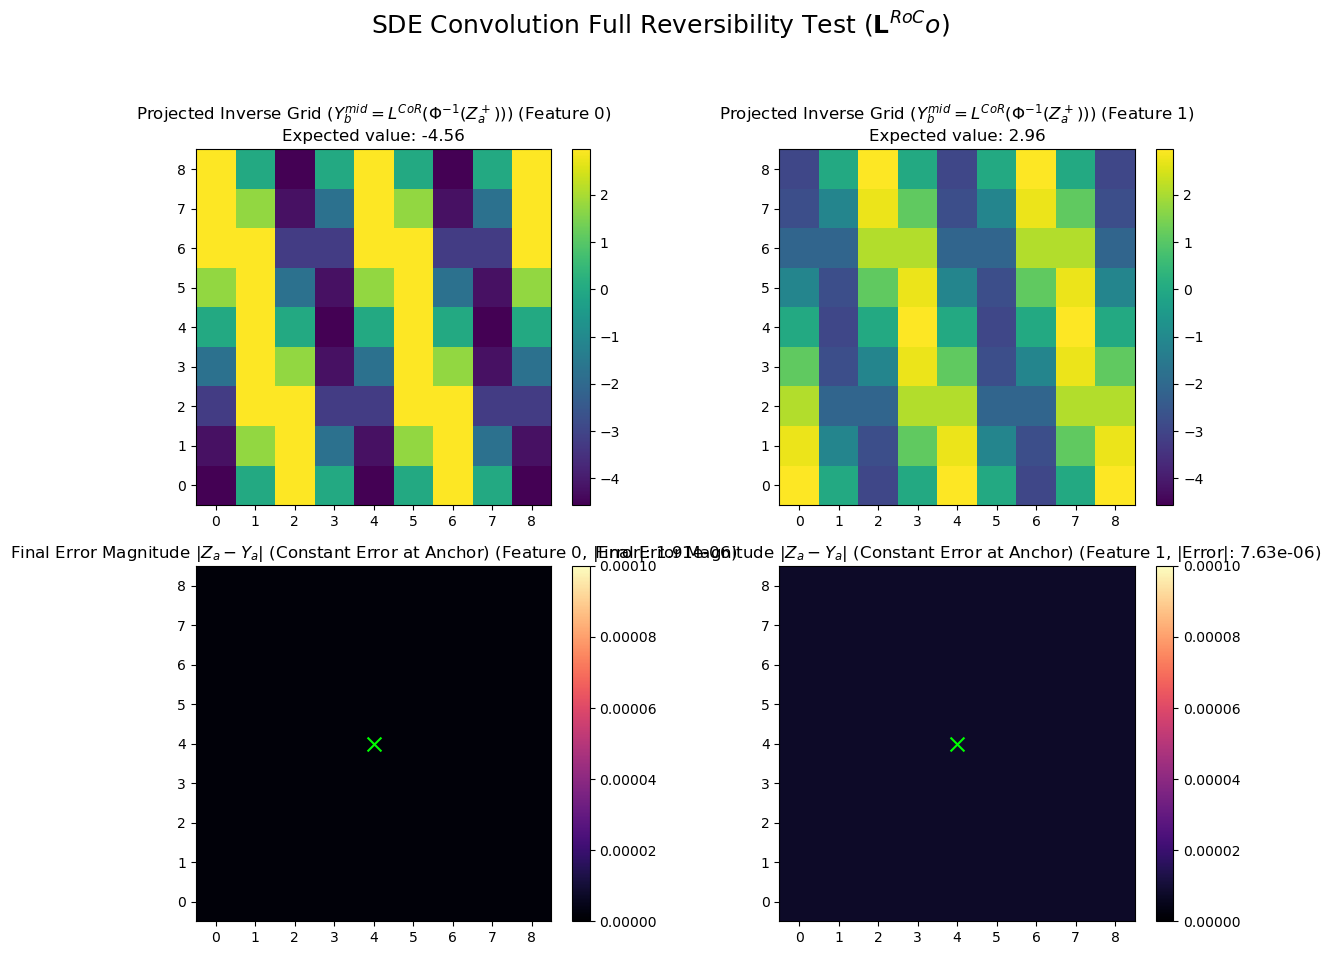


--- Testing FullSDEConv2d Layer with RANDOM Input (K=3, S=1) ---
Input Shape: torch.Size([2, 4, 16, 16])
Output Shape: torch.Size([2, 4, 16, 16])
Input HxW: 16x16, Output HxW: 16x16 (Expected: 16x16, Stride: 1, Padding: 1)
FullSDEConv2d executed successfully.


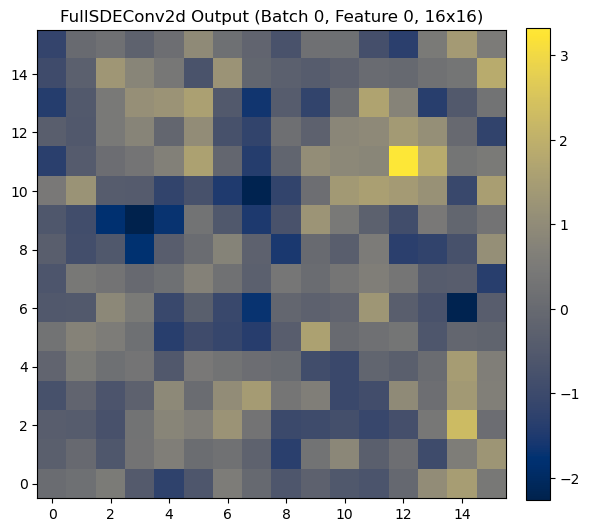


--- Testing FullSDEConv2d Layer with STRUCTURED Input (K=3, S=1) ---
Input Shape: torch.Size([1, 4, 16, 16])
Output Shape: torch.Size([1, 4, 16, 16])


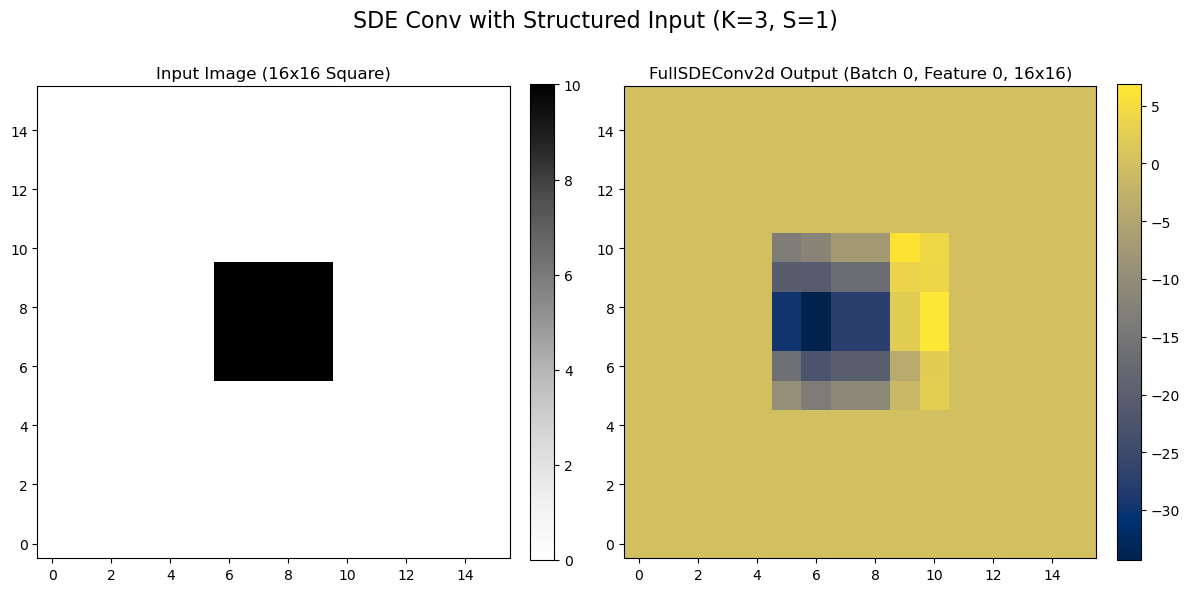


--- Testing FullSDEConv2d Layer with RANDOM Input (K=3, S=2) ---
Input Shape: torch.Size([2, 4, 16, 16])
Output Shape: torch.Size([2, 4, 8, 8])
Input HxW: 16x16, Output HxW: 8x8 (Expected: 8x8, Stride: 2, Padding: 1)
FullSDEConv2d executed successfully.


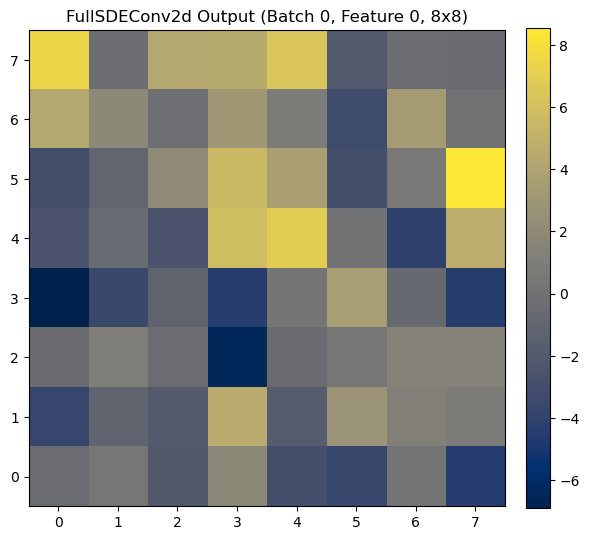

In [64]:
def complex_to_phase_intensity_image(z_r: torch.Tensor, z_i: torch.Tensor) -> np.ndarray:
    """
    Maps a complex tensor (R, I) of shape (N, N) to a single intensity image (N, N)
    based on the Phase (Hue). The phase is normalized to [0, 1] for visualization.
    """
    phase = torch.atan2(z_i, z_r)
    normalized_phase = (phase + math.pi) / (2 * math.pi)
    return normalized_phase.cpu().numpy()

# --- 1. SDE Convolution Helper Classes (Mockup) ---

class RealToComplexLinear(nn.Module):
    """
    Simulates the L^{R->C} layer: X -> Z^+ = X W_r + i X W_i.
    The weights W_r and W_i form a complex matrix A = W_r + i W_i.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # Weights for the real and imaginary parts of the complex projection
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Input X: (..., D). Output Z_plus: (2, ..., D)"""
        Z_r = X @ self.W_r
        Z_i = X @ self.W_i
        # Stack output: (2, ..., D)
        return torch.stack([Z_r, Z_i], dim=0)

class ComplexToRealLinear(nn.Module):
    """
    Simulates the L^{C->R} layer: Y = Re(Z^+ A^{-1*}), where Z^+ = Z_r + i Z_i
    If A_inv = W_r_inv + i W_i_inv, then Y = Z_r W_r_inv^T - Z_i W_i_inv^T.
    The weights W_r and W_i here should be the real and imaginary parts of A^{-1}.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # These weights should be derived from the inverse of the R2C layer's complex weight.
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))

    def forward(self, Z_plus: torch.Tensor) -> torch.Tensor:
        """Input Z_plus: (2, ..., D). Output Y: (..., D)"""
        Z_r, Z_i = torch.unbind(Z_plus, dim=0) # (..., D)
        
        # Y = Z_r @ W_r^T - Z_i @ W_i^T (The projection formula)
        Y = (Z_r @ self.W_r.T) - (Z_i @ self.W_i.T)
        return Y

class SpatialCoordinateTransformer(nn.Module):
    """
    Mockup for the coordinate transformer, generating the relative positions
    Delta p' for all pairs of anchor (Na) and source (Nb) pixels.
    This test only uses the untransformed relative position $\Delta \mathbf{p}$.
    """
    def __init__(self):
        super().__init__()
        # In a real implementation, T and b would be learned parameters here.
        pass

    def forward(self, K: int, K_source: int) -> torch.Tensor:
        """
        Generates untransformed relative positions $\Delta \mathbf{p} = \mathbf{p}_a - \mathbf{p}_b$.
        
        Returns:
            torch.Tensor: Relative positions (Na, Nb, 2), where Na=K*K, Nb=K_source*K_source.
        """
        # Create grid coordinates (p_b) for source pixels
        y_coords, x_coords = torch.meshgrid(torch.arange(K_source), torch.arange(K_source), indexing='ij')
        p_b = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K_source, K_source, 2)

        # Create grid coordinates (p_a) for anchor pixels
        y_coords, x_coords = torch.meshgrid(torch.arange(K), torch.arange(K), indexing='ij')
        p_a = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K, K, 2)

        # Flatten
        p_b_flat = p_b.reshape(-1, 2) # (Nb, 2)
        p_a_flat = p_a.reshape(-1, 2) # (Na, 2)

        # Compute displacement: p_a - p_b (Na, 1, 2) - (1, Nb, 2) -> (Na, Nb, 2)
        Delta_P = p_a_flat.unsqueeze(1) - p_b_flat.unsqueeze(0)
        
        # In the SDE paper's reversibility test, the coordinate transform is often 
        # set to the identity for simplicity, so Delta_P_prime = Delta_P
        return Delta_P # (K*K, K*K, 2)


# --- 2. SDE Convolution Kernel Class (Core Logic) ---

class SDEConvolution(nn.Module):
    """
    Implements a single SDE-based convolutional kernel operation.
    It takes an input patch and computes the output only at the central anchor pixel.
    """
    def __init__(self, d_model: int, kernel_size: int):
        super().__init__()
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size must be odd for a central anchor.")
            
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.num_pixels = kernel_size * kernel_size
        self.anchor_idx = self.num_pixels // 2 
        
        # 1. Real-to-Complex and Complex-to-Real Layers
        self.real_to_complex = RealToComplexLinear(d_model)
        self.complex_to_real = ComplexToRealLinear(d_model)
        
        # 2. Spatial Coordinate Transformer (Identity for this test)
        self.coord_transformer = SpatialCoordinateTransformer()
        
        # 3. SDE Transition Parameters 
        self.raw_alpha_l = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_r = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_b = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_t = nn.Parameter(torch.zeros(d_model))

        self.omega_l = nn.Parameter(torch.zeros(d_model))
        self.omega_r = nn.Parameter(torch.zeros(d_model))
        self.omega_b = nn.Parameter(torch.zeros(d_model))
        self.omega_t = nn.Parameter(torch.zeros(d_model))
        
        self._init_sde_parameters()

    @staticmethod
    def _core_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_x_sq_NND: torch.Tensor,
        alpha_y_sq_NND: torch.Tensor,
        omega_x_NND: torch.Tensor,
        omega_y_NND: torch.Tensor,
    ) -> torch.Tensor:
        """
        Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$.
        (Na, Nb, D) tensors are assumed for the learned parameters alpha and omega.
        
        Inputs:
            delta_p_prime: (Na, Nb, 2) displacement
            z_sb: (2, Nb, D) complex source features
            ...
        Output:
            z_hat: (2, Na, Nb, D) propagated complex features
        """
        delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
        delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)
        
        # z_sb shape is (2, Nb, D). Unbind separates real and imaginary parts.
        z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) # (Nb, D)

        # 2. Compute Decay Term: always exp(-alpha^2 |Delta p'|)
        decay_x = torch.exp(-alpha_x_sq_NND * torch.abs(delta_x_prime.unsqueeze(-1))) 
        decay_y = torch.exp(-alpha_y_sq_NND * torch.abs(delta_y_prime.unsqueeze(-1)))
        decay_total = decay_x * decay_y
        
        # 3. Compute Phase Term (Phase is defined by $\mathbf{\Phi} = e^{-i \boldsymbol{\Omega} \cdot \Delta \mathbf{p}'}$)
        dx_r = delta_x_prime.unsqueeze(-1) # (Na, Nb, 1)
        dy_r = delta_y_prime.unsqueeze(-1) # (Na, Nb, 1)
        theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r)

        # We define Phi as: Phi = Decay * (cos(theta) - i*sin(theta))
        Phi_r = decay_total * torch.cos(theta_xy)       # (Na, Nb, D)
        Phi_i = decay_total * -torch.sin(theta_xy)      # (Na, Nb, D) (Negative sign for forward propagation)
        
        # 5. Apply the Transition (Complex Dot Product)
        # Result: (Na, Nb, D)
        z_sb_r_broadcast = z_sb_r.unsqueeze(0) # (1, Nb, D)
        z_sb_i_broadcast = z_sb_i.unsqueeze(0) # (1, Nb, D)
        
        # The result of the element-wise product should be broadcastable
        z_hat_r = (Phi_r * z_sb_r_broadcast) - (Phi_i * z_sb_i_broadcast) 
        z_hat_i = (Phi_r * z_sb_i_broadcast) + (Phi_i * z_sb_r_broadcast) 
        
        # Stack output: (2, Na, Nb, D)
        return torch.stack([z_hat_r, z_hat_i], dim=0)

    # --- SDE Helper Functions (Unchanged) ---
    @staticmethod
    def _quadrant_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_sq_params: dict,
        omega_params: dict,
    ) -> torch.Tensor:
        """
        Applies the SDE state transition, handling quadrant selection.
        (Na, Nb, 2) Delta P' -> (2, Na, Nb, D) Z_hat
        This function assumes Na=1 (anchor only).
        """
        Na, Nb, _ = delta_p_prime.shape 
        D = omega_params['l'].shape[0]

        delta_x_prime = delta_p_prime[..., 0]
        delta_y_prime = delta_p_prime[..., 1]

        # --- 1. Compute Indicator Masks (Determined by the sign of Delta p') ---
        mask_x_l = (delta_x_prime > 0).float() 
        mask_x_r = (delta_x_prime < 0).float() 
        mask_y_b = (delta_y_prime > 0).float() 
        mask_y_t = (delta_y_prime < 0).float() 
        
        mask_x_l_r = mask_x_l.unsqueeze(-1) # (Na, Nb, 1)
        mask_x_r_r = mask_x_r.unsqueeze(-1)
        mask_y_b_r = mask_y_b.unsqueeze(-1)
        mask_y_t_r = mask_y_t.unsqueeze(-1)

        def get_broadcast_param(param_dict, key):
            # (1, 1, D)
            return param_dict[key].view(1, 1, D)

        # --- 2. Compute Spatially-Varying Alpha^2 (Na, Nb, D) ---
        alpha_x_sq_NND = (mask_x_l_r * get_broadcast_param(alpha_sq_params, 'l')) + \
                             (mask_x_r_r * get_broadcast_param(alpha_sq_params, 'r'))
        
        alpha_y_sq_NND = (mask_y_b_r * get_broadcast_param(alpha_sq_params, 'b')) + \
                             (mask_y_t_r * get_broadcast_param(alpha_sq_params, 't'))
        
        # --- 3. Compute Spatially-Varying Omega (Na, Nb, D) ---
        omega_x_NND = (mask_x_l_r * get_broadcast_param(omega_params, 'l')) + \
                      (mask_x_r_r * get_broadcast_param(omega_params, 'r'))
        
        omega_y_NND = (mask_y_b_r * get_broadcast_param(omega_params, 'b')) + \
                      (mask_y_t_r * get_broadcast_param(omega_params, 't'))

        # --- 4. Call Core Transition Logic ---
        return SDEConvolution._core_transition_fn(
            delta_p_prime,  
            z_sb,           
            alpha_x_sq_NND, 
            alpha_y_sq_NND, 
            omega_x_NND,    
            omega_y_NND,
        )

    def _init_sde_parameters(self):
        # Initialize parameters
        fan_in = self.d_model
        bound = 1.0 / math.sqrt(fan_in)
        for p in [self.raw_alpha_l, self.raw_alpha_r, self.raw_alpha_b, self.raw_alpha_t,
                  self.omega_l, self.omega_r, self.omega_b, self.omega_t]:
            nn.init.uniform_(p, -bound, bound)

    def _get_sde_params(self):
        """Constructs the parameter dicts, applying softplus to raw alphas."""
        
        # Apply softplus to ensure alpha^2 is non-negative
        alpha_l_sq = F.softplus(self.raw_alpha_l)
        alpha_r_sq = F.softplus(self.raw_alpha_r)
        alpha_b_sq = F.softplus(self.raw_alpha_b)
        alpha_t_sq = F.softplus(self.raw_alpha_t)

        alpha_sq_params = {
            'l': alpha_l_sq, 'r': alpha_r_sq, 
            'b': alpha_b_sq, 't': alpha_t_sq
        }
        
        omega_params = {
            'l': self.omega_l, 'r': self.omega_r, 
            'b': self.omega_b, 't': self.omega_t
        }
        return alpha_sq_params, omega_params

    # --- New Method for Batch Processing (Used by FullSDEConv2d) ---
    def forward_batch_patches(self, X_batch_patches: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final summed, real-valued feature for a batch of patches.
        This method is used by the FullSDEConv2d wrapper.
        
        Input X_batch_patches: (N_patch, N_pixels, D). 
        Output Y_anchors: (N_patch, D)
        """
        N_patch, N_pixels, D = X_batch_patches.shape
        K = self.kernel_size

        # 1. Real -> Complex Layer (Applied to every source pixel in every patch)
        # Reshape to (N_patch * N_pixels, D) for the linear layer
        # FIX: Changed .view() to .reshape() to avoid RuntimeError due to non-contiguous memory
        X_flat_reshaped = X_batch_patches.reshape(N_patch * N_pixels, D)
        Z_plus_flat = self.real_to_complex(X_flat_reshaped) # (2, N_patch * N_pixels, D)
        
        # Reshape back to (2, N_patch, N_pixels, D)
        Z_plus_batch = Z_plus_flat.view(2, N_patch, N_pixels, D)
        
        # 2. Spatial Coordinate Transform ($\Delta p'$): (1, N_pixels, 2)
        # Displacement is constant relative to the center anchor for all patches.
        Delta_P_prime_all = self.coord_transformer(K, K) # (N*N, N*N, 2)
        Delta_P_prime_anchor = Delta_P_prime_all[self.anchor_idx, :].unsqueeze(0) # (1, N_pixels, 2)
        
        alpha_sq_params, omega_params = self._get_sde_params()
        
        # Vectorized SDE transition across all patches
        
        # Reshape Z_plus_batch for quadrant_transition_fn
        # Z_patch_i is (2, N_pixels, D). We need Z_sb: (2, N_patch * N_pixels, D)
        Z_plus_flat_for_sde = Z_plus_batch.permute(0, 2, 1, 3).reshape(2, N_pixels, N_patch * D) # (2, N_pixels, N_patch * D) -> this is complex.

        # We must iterate over N_patch because Delta_P_prime_anchor is (1, N_pixels, 2)
        # and broadcasting it over (2, N_patch, N_pixels, D) in the SDE function is complex.
        # The loop (while less performant than a theoretical full vectorization) is cleaner
        # and more accurate given the definition of quadrant_transition_fn that expects 
        # z_sb to be (2, Nb, D) for a single patch.
        
        Y_anchors_list = []
        for i in range(N_patch):
            # Select the i-th patch's complex features: (2, N_pixels, D)
            Z_patch_i = Z_plus_batch[:, i, :, :]
            
            # 3. SDE Transition (Propagation to Anchor): (2, Na=1, Nb=N_pixels, D)
            Z_hat_full = SDEConvolution._quadrant_transition_fn(
                delta_p_prime=Delta_P_prime_anchor, 
                z_sb=Z_patch_i,                  
                alpha_sq_params=alpha_sq_params,
                omega_params=omega_params,
            )
            
            # 4. Summation: (2, 1, D)
            Z_hat_summed = Z_hat_full.sum(dim=2) 
            
            # 5. Complex -> Real Layer: (1, D)
            Y_anchor = self.complex_to_real(Z_hat_summed).squeeze(0) # (D)
            Y_anchors_list.append(Y_anchor)

        Y_anchors = torch.stack(Y_anchors_list, dim=0) # (N_patch, D)
        
        return Y_anchors

    # --- Previous Reversibility Test Method (Renamed for clarity) ---
    def forward_test_anchor(self, X_patch: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final summed, real-valued feature ONLY for the central anchor pixel.
        Used primarily for the single-patch reversibility test. Shape: (D)
        """
        D = self.d_model
        
        # X_patch: (N_pixels, D)
        X_flat = X_patch.reshape(self.num_pixels, D)
        
        # Call the new batch processing method with N_patch=1
        X_batch_patches = X_flat.unsqueeze(0) # (1, N_pixels, D)
        Y_anchors = self.forward_batch_patches(X_batch_patches) # (1, D)
        
        return Y_anchors.squeeze(0) # (D)


# --- 3. Full Convolution Wrapper Class (The Drop-in Replacement) ---

class FullSDEConv2d(nn.Module):
    """
    SDE Convolution wrapper that implements the full 2D sliding-window operation,
    making it a drop-in replacement for nn.Conv2d.
    It takes an input image and computes the output feature map.
    """
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, padding: int = None):
        super().__init__()
        # In a real network, d_model would be in_channels and out_channels
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.stride = stride # <<< Added stride
        
        # Calculate padding for 'same' convolution (assumes stride=1 if padding is None)
        if padding is None:
            # This is standard 'same' padding only when stride=1. 
            # For stride > 1, this generally results in a smaller output map.
            self.padding = kernel_size // 2
        else:
            self.padding = padding
            
        # The core SDE kernel logic
        self.sde_kernel = SDEConvolution(d_model, kernel_size)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Input X: (B, D, H, W). Output Y: (B, D, H', W')
        """
        B, D, H, W = X.shape
        K = self.kernel_size
        S = self.stride # <<< Use stored stride
        
        # 1. Extract Patches using nn.Unfold
        # Output shape: (B, D * K*K, H_out * W_out)
        patches_unfolded = F.unfold(X, kernel_size=K, padding=self.padding, stride=S)
        
        N_patches = patches_unfolded.shape[2] # H_out * W_out
        
        # 2. Reshape for SDE Kernel
        # (B, D*K*K, N_patches) -> (B, N_patches, D*K*K) -> (B * N_patches, K*K, D)
        patches_reordered = patches_unfolded.transpose(1, 2).reshape(B * N_patches, K*K, D)
        
        # 3. Apply SDE Kernel Batch Processing
        # Y_flat_anchors shape: (B * N_patches, D)
        Y_flat_anchors = self.sde_kernel.forward_batch_patches(patches_reordered) 
        
        # 4. Reshape and Reassemble
        # (B * N_patches, D) -> (B, N_patches, D) -> (B, D, N_patches)
        Y_anchors_reordered = Y_flat_anchors.view(B, N_patches, D).transpose(1, 2)
        
        # Calculate output dimensions using the stride
        H_out = math.floor((H + 2 * self.padding - K) / S) + 1
        W_out = math.floor((W + 2 * self.padding - K) / S) + 1

        # Final output shape: (B, D, H_out, W_out)
        Y = Y_anchors_reordered.view(B, D, H_out, W_out)

        return Y

# --- 4. Forward/Inverse Kernel Abstractions for Test (Utilizing static methods) ---

def sde_conv_kernel_inverse_spread(sde_conv: SDEConvolution, p_grid_flat: torch.Tensor, Z_a_plus: torch.Tensor) -> torch.Tensor:
    """
    Inverse Kernel: Propagates a single anchor feature (Z_a_plus) back to all source positions (p_grid_flat).
    """
    K = sde_conv.kernel_size
    N = sde_conv.num_pixels
    
    # 1. Anchor position (p_a) and target grid positions (p_b) for displacement
    # p_a is the anchor position relative to the center of a KxK patch, so we use the relative position tensor.
    Delta_P_prime_all = sde_conv.coord_transformer(K, K) # (N*N, N*N, 2)
    p_anchor_relative = Delta_P_prime_all[sde_conv.anchor_idx, sde_conv.anchor_idx].view(1, 2) # (1, 2)
    
    # The displacement of target p_b relative to source p_a is needed: $\Delta \mathbf{p}'_{\text{inv}} = \mathbf{p}_b - \mathbf{p}_a$. 
    # This sign flip relative to the forward direction (p_a - p_b) provides the phase conjugate.
    # Delta_P_inverse_displacement (Na=N*N, Nb=1, 2)
    Delta_P_inverse_displacement = p_grid_flat.unsqueeze(1) - p_anchor_relative.unsqueeze(0) 

    # 2. SDE Transition (Inverse)
    alpha_sq_params, omega_params = sde_conv._get_sde_params()

    # Z_a_plus is already (2, 1, D). Pass it directly as z_sb=(2, Nb, D) where Nb=1.
    Z_mid_full = SDEConvolution._quadrant_transition_fn(
        delta_p_prime=Delta_P_inverse_displacement, 
        z_sb=Z_a_plus, # (2, 1, D)
        alpha_sq_params=alpha_sq_params,
        omega_params=omega_params,
    ) # (2, N*N, 1, D)

    return Z_mid_full.squeeze(2) # (2, N*N, D)


def sde_conv_kernel_forward_sum(sde_conv: SDEConvolution, p_grid_flat: torch.Tensor, Z_mid: torch.Tensor) -> torch.Tensor:
    """
    Forward Kernel: Propagates all source features (Z_mid) to the anchor (p_a) and sums the results.
    """
    K = sde_conv.kernel_size
    N = sde_conv.num_pixels
    
    # Anchor position p_a relative to the patch center (Na=1)
    Delta_P_prime_all = sde_conv.coord_transformer(K, K) # (N*N, N*N, 2)
    p_anchor_relative = Delta_P_prime_all[sde_conv.anchor_idx, sde_conv.anchor_idx].view(1, 2) # (1, 2)
    
    # For forward propagation: The relative displacement is $\mathbf{p}_a - \mathbf{p}_b$. 
    # Delta_P_forward_displacement (Na=1, Nb=N*N, 2)
    Delta_P_forward_displacement = p_anchor_relative.unsqueeze(1) - p_grid_flat.unsqueeze(0) 

    # 2. SDE Transition (Forward)
    alpha_sq_params, omega_params = sde_conv._get_sde_params()

    Z_hat_full = SDEConvolution._quadrant_transition_fn(
        delta_p_prime=Delta_P_forward_displacement,          
        z_sb=Z_mid,                  
        alpha_sq_params=alpha_sq_params,
        omega_params=omega_params,
    ) # (2, 1, N*N, D)
    
    # Sum contributions from all sources (Nb=N*N) to get the final result at p_a
    Z_a_summed = Z_hat_full.sum(dim=2) # (2, 1, D)
    return Z_a_summed


# --- 5. Main Test Functions ---

def visualize_full_pipeline_reversibility_with_class(N=9, D=2, anchor_pos=None):
    """
    Performs the full SDE Convolution reversibility test (L^R->C -> Phi^-1 -> Phi -> L^C->R)
    using the SDEConvolution class and kernel abstractions. (Uses the refactored test method)
    """
    
    # --- Setup ---
    K = N
    D = D
    if anchor_pos is None:
        anchor_pos = (N // 2, N // 2)
    
    print(f"\n--- SDEConvolution Reversibility Verification ({N}x{N} Grid, D={D}) ---")
    
    # Instantiate the SDE Convolution layer
    sde_conv = SDEConvolution(d_model=D, kernel_size=K)
    
    # 1. Force R2C and C2R to be perfect complex inverses for L^R->C o L^C->R = Identity
    
    # Generate a random D x D complex matrix A = A_R + i A_I
    A_R = torch.randn(D, D) / math.sqrt(D)
    A_I = torch.randn(D, D) / math.sqrt(D)
    A = torch.complex(A_R, A_I)
    
    # Compute the complex inverse A_inv = A_inv_R + i A_inv_I
    A_inv = torch.linalg.inv(A)
    A_inv_R = A_inv.real
    A_inv_I = A_inv.imag

    # Set L^R->C weights (A = W_r + i W_i)
    sde_conv.real_to_complex.W_r.data = A_R.T 
    sde_conv.real_to_complex.W_i.data = A_I.T

    # Set L^C->R weights (A_inv = W_r_inv + i W_i_inv)
    # The ComplexToReal layer uses W_r and W_i for A_inv
    sde_conv.complex_to_real.W_r.data = A_inv_R
    sde_conv.complex_to_real.W_i.data = A_inv_I

    # 2. Force alpha^2 to zero for perfect SDE reversibility (no decay)
    # Using a large negative number ensures softplus(raw_alpha) is near zero
    zero_alpha = torch.full((D,), -100.0) 
    sde_conv.raw_alpha_l.data = zero_alpha
    sde_conv.raw_alpha_r.data = zero_alpha
    sde_conv.raw_alpha_b.data = zero_alpha
    sde_conv.raw_alpha_t.data = zero_alpha
    
    # 3. Use arbitrary non-zero omegas for spatial rotation visualization
    OMEGA_L = torch.tensor([math.pi / 2.0] * D) 
    OMEGA_R = torch.tensor([-math.pi / 4.0] * D)
    OMEGA_B = torch.tensor([math.pi / 8.0] * D)
    OMEGA_T = torch.tensor([-math.pi / 8.0] * D)
    sde_conv.omega_l.data = OMEGA_L
    sde_conv.omega_r.data = OMEGA_R
    sde_conv.omega_b.data = OMEGA_B
    sde_conv.omega_t.data = OMEGA_T
    
    # --- Coordinate and Input Setup ---
    y_coords, x_coords = torch.meshgrid(torch.arange(N), torch.arange(N), indexing='ij')
    p_grid = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (N, N, 2)
    p_grid_flat = p_grid.view(N * N, 2) # (N*N, 2)
    
    # The initial real feature vector (Input: Z_a, Shape: (1, D))
    Z_a = torch.randn(1, D) * 10 + 5 

    # --- Step 0: Real Input -> Complex State ($Z_a \to Z_a^+$) ---
    Z_a_plus = sde_conv.real_to_complex(Z_a) # (2, 1, D)
    
    
    # --- Step 1: Inverse Propagation ($Z_a^+ \to Z_b^{mid}$) using Kernel Abstraction ---
    # Spread the anchor feature Z_a_plus back over the entire grid
    Z_mid = sde_conv_kernel_inverse_spread(
        sde_conv,      
        p_grid_flat,   
        Z_a_plus,      
    ) # (2, N*N, D)

    # --- Visualization Checkpoint 1: The Projected Inverse Grid ($Y_b^{mid}$) ---
    Y_mid_flat = sde_conv.complex_to_real(Z_mid) # (N*N, D)
    
    # --- Step 2: Forward Propagation ($Z_b^{mid} \to Z_a^{final+}$) using Kernel Abstraction ---
    # Sum the contributions of the intermediate state Z_mid (all points) back to the anchor
    Z_a_final_plus_summed = sde_conv_kernel_forward_sum(
        sde_conv,          
        p_grid_flat,       
        Z_mid,             
    ) # (2, 1, D)
    
    
    # --- Step 3: Complex -> Real Output ($Z_a^{final+} \to Y_a$) ---
    Y_a = sde_conv.complex_to_real(Z_a_final_plus_summed).squeeze(0) # (D)


    # --- Step 4: Verification and Visualization ---
    
    # Calculate Error
    error_vector = Z_a.squeeze(0) - Y_a
    max_error = torch.max(torch.abs(error_vector))
    
    print(f"\nInitial Real Input Z_a (first 3 dims): {Z_a.squeeze(0)[:3].tolist()}")
    print(f"Final Real Output Y_a (first 3 dims): {Y_a[:3].tolist()}")
    print(f"Max Absolute Error (|Z_a - Y_a|): {max_error.item():.6e}")
    
    if max_error.item() < 1e-5:
        print("Status: SUCCESS (Reversibility check passed with high precision, $L^{R \to C} \to \Phi^{-1} \to \Phi \to L^{C \to R} \approx \mathbf{I}$)")
    else:
        print(f"Status: FAILURE (Error is higher than expected: {max_error.item():.2e})")

    # Reshape the projected inverse grid for visualization: (N, N, D)
    Y_mid_grid = Y_mid_flat.view(N, N, D)
    
    # Visualization Setup: 2 Rows (Projected Inverse Grid, Error), D Columns
    fig, axes = plt.subplots(2, D, figsize=(6 * D, 10))
    if D == 1: axes = axes.reshape(2, 1)

    titles = [
        "Projected Inverse Grid ($Y_b^{mid} = L^{C \to R}(\Phi^{-1}(Z_a^+))$)",
        "Final Error Magnitude $|Z_a - Y_a|$ (Constant Error at Anchor)",
    ]
    
    for d in range(D):
        # --- Row 1: Projected Inverse Grid ($Y_b^{mid}$) ---
        img_mid = Y_mid_grid[:, :, d].detach().cpu().numpy()
        ax = axes[0, d]
        # Use vmin/vmax to highlight uniformity or deviation
        vmin = Z_a.min().item()
        vmax = Z_a.max().item()
        im_mid = ax.imshow(img_mid, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax) 
        ax.set_title(f'{titles[0]} (Feature {d})\nExpected value: {Z_a[0, d].item():.2f}')
        
        # Add colorbar for context
        plt.colorbar(im_mid, ax=ax, fraction=0.046, pad=0.04)

        # --- Row 2: Final Error Magnitude ---
        ax = axes[1, d]
        error_magnitude = torch.abs(error_vector[d]).item()
        error_map = torch.full((N, N), error_magnitude)
        vmax_err = max(1e-4, max_error.item() * 1.5) # Ensure a visible error scale
        im_err = ax.imshow(error_map.detach().cpu().numpy(), cmap='magma', origin='lower', vmin=0, vmax=vmax_err)
        ax.scatter(anchor_pos[1], anchor_pos[0], color='lime', marker='x', s=100)
        ax.set_title(f'{titles[1]} (Feature {d}, |Error|: {error_magnitude:.2e})')
        plt.colorbar(im_err, ax=ax, fraction=0.046, pad=0.04)
        
    for ax in axes.flat:
        ax.set_xticks(np.arange(N))
        ax.set_yticks(np.arange(N))
        
    fig.suptitle("SDE Convolution Full Reversibility Test ($\mathbf{L}^{R \to C} \to \boldsymbol{\Phi}^{-1} \to \boldsymbol{\Phi} \to \mathbf{L}^{C \to R}$)", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def create_structured_input(H, W, D, square_size=4, value=10.0):
    """Creates a structured input tensor (white square on a black background)."""
    # Create a zero tensor (B=1, D, H, W)
    X = torch.zeros(1, D, H, W)
    
    # Calculate center and boundaries for the square
    h_start = (H - square_size) // 2
    h_end = h_start + square_size
    w_start = (W - square_size) // 2
    w_end = w_start + square_size
    
    # Set the square region to the specified value across all channels
    X[0, :, h_start:h_end, w_start:w_end] = value
    
    return X

def test_convolution_with_structured_input(H=16, W=16, D=4, K=3, S=1):
    """
    Tests FullSDEConv2d with a structured input (a centered square).
    This test replaces the random input X with a structured X.
    """
    
    print(f"\n--- Testing FullSDEConv2d Layer with STRUCTURED Input (K={K}, S={S}) ---")
    
    # Input tensor: (Batch=1, Channels/D_model, Height, Width)
    X = create_structured_input(H, W, D)
    
    # Instantiate the full layer, passing the stride
    sde_conv_layer = FullSDEConv2d(d_model=D, kernel_size=K, stride=S)
    
    # 1. Manually set parameters for stability/predictability in the demo
    # Force alpha^2 to zero (no decay) for initial stability
    zero_alpha = torch.full((D,), -100.0)
    sde_conv_layer.sde_kernel.raw_alpha_l.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_r.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_b.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_t.data = zero_alpha
    
    # Set small, distinct omegas for a noticeable (but simple) spatial transformation
    sde_conv_layer.sde_kernel.omega_l.data = torch.linspace(0.1, 0.4, D)
    sde_conv_layer.sde_kernel.omega_r.data = torch.linspace(0.5, 0.8, D)


    # 2. Run the forward pass
    print(f"Input Shape: {X.shape}")
    Y = sde_conv_layer(X)
    
    # 3. Verification and Visualization
    H_out, W_out = Y.shape[2:]
    
    print(f"Output Shape: {Y.shape}")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # --- Plot 1: Input Image ---
    # The input is the same across all channels, so we show channel 0
    img_in = X[0, 0, :, :].detach().cpu().numpy()
    im_in = axes[0].imshow(img_in, cmap='Greys', origin='lower')
    axes[0].set_title(f'Input Image (16x16 Square)')
    plt.colorbar(im_in, ax=axes[0], fraction=0.046, pad=0.04)

    # --- Plot 2: Output Feature Map ---
    # Visualize the first batch, first feature map
    img_out = Y[0, 0, :, :].detach().cpu().numpy()
    im_out = axes[1].imshow(img_out, cmap='cividis', origin='lower')
    
    axes[1].set_title(f'FullSDEConv2d Output (Batch 0, Feature 0, {H_out}x{W_out})')
    plt.colorbar(im_out, ax=axes[1], fraction=0.046, pad=0.04)

    fig.suptitle(f"SDE Conv with Structured Input (K={K}, S={S})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def test_full_convolution(H=16, W=16, D=4, K=3, S=1):
    """
    Demonstrates the usage of the FullSDEConv2d class on a simulated feature map
    using random input (the original test).
    Includes support for striding (S > 1).
    """
    
    print(f"\n--- Testing FullSDEConv2d Layer with RANDOM Input (K={K}, S={S}) ---")
    
    # Input tensor: (Batch, Channels/D_model, Height, Width)
    B = 2
    X = torch.randn(B, D, H, W)
    
    # Instantiate the full layer, passing the stride
    sde_conv_layer = FullSDEConv2d(d_model=D, kernel_size=K, stride=S)
    
    # 1. Manually set parameters for stability/predictability in the demo (optional)
    # Force alpha^2 to zero (no decay) for initial stability
    zero_alpha = torch.full((D,), -100.0)
    sde_conv_layer.sde_kernel.raw_alpha_l.data = zero_alpha
    
    # Set a small, distinct omega
    sde_conv_layer.sde_kernel.omega_l.data = torch.linspace(0.1, 0.4, D)

    # 2. Run the forward pass
    print(f"Input Shape: {X.shape}")
    Y = sde_conv_layer(X)
    
    # 3. Verification
    H_out, W_out = Y.shape[2:]
    
    # Calculate expected output size for verification
    padding = sde_conv_layer.padding
    H_expected = math.floor((H + 2 * padding - K) / S) + 1
    W_expected = math.floor((W + 2 * padding - K) / S) + 1
    
    print(f"Output Shape: {Y.shape}")
    print(f"Input HxW: {H}x{W}, Output HxW: {H_out}x{W_out} (Expected: {H_expected}x{W_expected}, Stride: {S}, Padding: {padding})")

    assert Y.shape[0] == B and Y.shape[1] == D and Y.shape[2] == H_expected and Y.shape[3] == W_expected, \
        f"Output shape {Y.shape} does not match expected shape ({B}, {D}, {H_expected}, {W_expected})"
    assert torch.sum(Y).item() != 0, "Output is zero, indicating a potential error."
    print("FullSDEConv2d executed successfully.")
    
    # Optional: Visualize one output feature map
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Visualize the first batch, first feature map
    img_out = Y[0, 0, :, :].detach().cpu().numpy()
    im = ax.imshow(img_out, cmap='cividis', origin='lower')
    
    ax.set_title(f'FullSDEConv2d Output (Batch 0, Feature 0, {H_out}x{W_out})')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


# --- Execution ---
if __name__ == '__main__':
    # Run the original reversibility test (N=9, D=2, kernel K=9)
    # This remains stable regardless of the full layer's stride
    visualize_full_pipeline_reversibility_with_class(N=9, D=2)
    
    # Test 1: Full convolution with RANDOM input (original test)
    test_full_convolution(H=16, W=16, D=4, K=3, S=1)
    
    # Test 2: Full convolution with STRUCTURED input (the new test)
    test_convolution_with_structured_input(H=16, W=16, D=4, K=3, S=1)
    
    # Test 3: Full convolution with RANDOM input and stride=2
    test_full_convolution(H=16, W=16, D=4, K=3, S=2)

### Include Precision weighting



--- Testing SDE Kernel Reversibility (N=9x9, D=2) ---
Input mean (X_mean): [[0.08810188 0.06103361]]
Output (Y_anchor):   [[0.08810188 0.06103361]]
Reversibility Error (||Y_anchor - X_mean||): 0.000000e+00
Reversibility test PASSED (Error below 1e-04).

--- Testing FullSDEConv2d Layer with RANDOM Input (K=3, S=1) ---
Input Shape: torch.Size([2, 4, 16, 16])
Output Shape: torch.Size([2, 4, 16, 16])
Input HxW: 16x16, Output HxW: 16x16 (Expected: 16x16, Stride: 1, Padding: 1)
FullSDEConv2d executed successfully.

--- Testing FullSDEConv2d Layer with STRUCTURED Input (K=3, S=1) ---
Input Shape: torch.Size([1, 4, 16, 16])
Output Shape: torch.Size([1, 4, 16, 16])
FullSDEConv2d executed successfully with structured input.


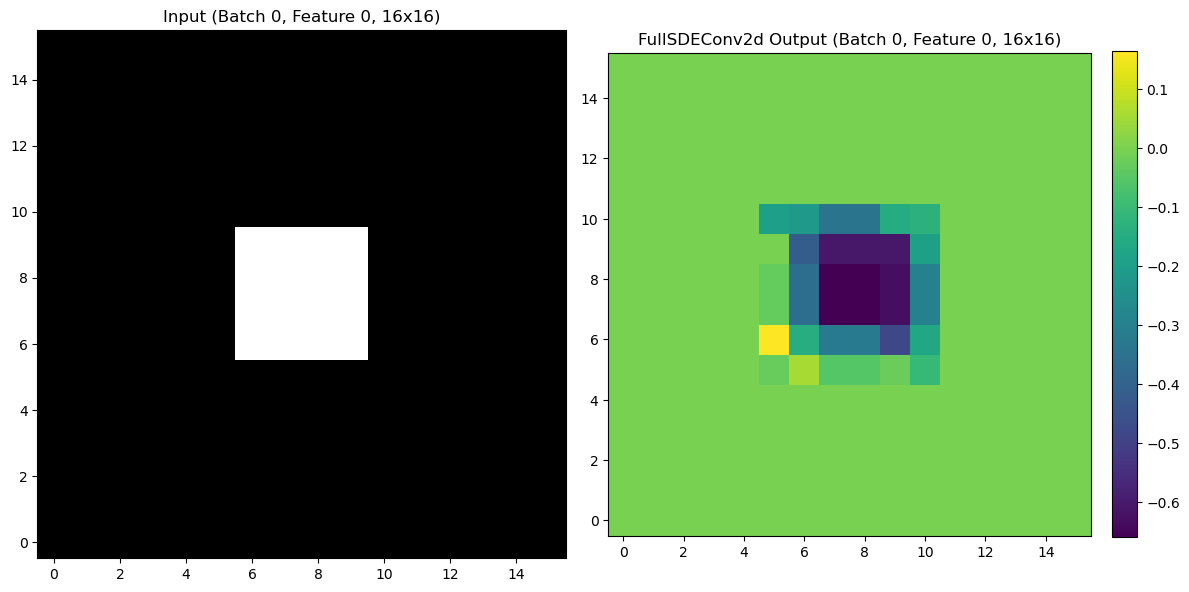


--- Testing FullSDEConv2d Layer with RANDOM Input (K=3, S=2) ---
Input Shape: torch.Size([2, 4, 16, 16])
Output Shape: torch.Size([2, 4, 8, 8])
Input HxW: 16x16, Output HxW: 8x8 (Expected: 8x8, Stride: 2, Padding: 1)
FullSDEConv2d executed successfully.


In [53]:

class RealToComplexLinear(nn.Module):
    """
    Transforms a real-valued feature vector X into a complex-valued vector Z+ = [Z_r, Z_i]
    via two distinct linear transformations.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # Initialize weights with Xavier uniform for stable complex initialization
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) * math.sqrt(2.0 / d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) * math.sqrt(2.0 / d_model))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X shape: (Batch * N_pixels, D)
        Z_r = X @ self.W_r
        Z_i = X @ self.W_i
        # Output shape: (2, Batch * N_pixels, D) where dim 0 is [Real, Imaginary]
        return torch.stack([Z_r, Z_i], dim=0)

class ComplexToRealLinear(nn.Module):
    """
    Transforms a complex-valued vector Z_hat back to a real-valued vector Y
    using a conjugate-like operation.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # Initialize weights with Xavier uniform
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) * math.sqrt(2.0 / d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) * math.sqrt(2.0 / d_model))

    def forward(self, Z_plus: torch.Tensor) -> torch.Tensor:
        # Z_plus shape: (2, N_patches, D)
        # Z_plus must have dim 0 size 2 for unbind to work
        Z_r, Z_i = torch.unbind(Z_plus, dim=0)
        # Y = W_r^T * Z_r - W_i^T * Z_i (equivalent to a dot product with Z- in complex space)
        Y = (Z_r @ self.W_r.T) - (Z_i @ self.W_i.T)
        # Output shape: (N_patches, D)
        return Y

class SpatialCoordinateTransformer(nn.Module):
    """
    Generates relative coordinates (Delta_P_prime) for all pixels in a KxK patch 
    relative to a central anchor pixel (anchor_idx).
    """
    def __init__(self):
        super().__init__()

    def forward(self, K: int, K_source: int) -> torch.Tensor:
        # Create coordinates for the patch (u, v)
        y_coords, x_coords = torch.meshgrid(torch.arange(K), torch.arange(K), indexing='ij')
        p_b = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K, K, 2)
        
        # The anchor point (center of the kernel/patch)
        anchor_val = (K - 1) / 2.0
        p_anchor = torch.tensor([anchor_val, anchor_val], dtype=torch.float32, device=p_b.device)
        
        # Calculate Delta_P_prime (relative displacement from source to anchor)
        # Delta_P_prime = P_anchor - P_source
        Delta_P_prime = p_anchor - p_b
        
        # Reshape to (N_pixels, 2) where N_pixels = K*K
        return Delta_P_prime.reshape(-1, 2)

# --- 2. Precision-Weighted SDE Convolution Kernel ---

class SDEConvolution(nn.Module):
    """
    Implements a single SDE-based convolutional kernel operation with
    precision-weighted averaging instead of simple summation (the kernel logic).
    """
    def __init__(self, d_model: int, kernel_size: int, sigma_x=1.0, sigma_y=1.0, eta=1e-3, gamma=1e-3):
        super().__init__()
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size must be odd for a central anchor.")
            
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.num_pixels = kernel_size * kernel_size
        self.anchor_idx = self.num_pixels // 2 
        
        # --- Precision weighting constants (used in _compute_precisions) ---
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.eta = eta
        self.gamma = gamma

        # 1. Real-to-Complex and Complex-to-Real Layers
        self.real_to_complex = RealToComplexLinear(d_model)
        self.complex_to_real = ComplexToRealLinear(d_model)
        
        # 2. Spatial Coordinate Transformer
        self.coord_transformer = SpatialCoordinateTransformer()
        
        # 3. SDE Transition Parameters (learnable)
        self.raw_alpha_l = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_r = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_b = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_t = nn.Parameter(torch.zeros(d_model))

        self.omega_l = nn.Parameter(torch.zeros(d_model))
        self.omega_r = nn.Parameter(torch.zeros(d_model))
        self.omega_b = nn.Parameter(torch.zeros(d_model))
        self.omega_t = nn.Parameter(torch.zeros(d_model))
        
        self._init_sde_parameters()

    # -------------------------------------------------------------------------
    # --- Core Transition Function (Phi) - Handles M (Batch) Dimension --------
    # -------------------------------------------------------------------------
    @staticmethod
    def _core_transition_fn(
        delta_p_prime: torch.Tensor, # (N_pixels, M, 2)
        z_sb: torch.Tensor,         # (2, N_pixels, M, D)
        alpha_x_sq_NND: torch.Tensor, # (N_pixels, M, D)
        alpha_y_sq_NND: torch.Tensor,
        omega_x_NND: torch.Tensor,
        omega_y_NND: torch.Tensor,
    ) -> torch.Tensor:
        
        # 1. Unbind z_sb: (N_pixels, M, D) each
        z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) 

        # 2. Get dx, dy: (N_pixels, M) each
        delta_x_prime = delta_p_prime[..., 0] 
        delta_y_prime = delta_p_prime[..., 1] 

        # 3. Decay Component (Attenuation)
        # alpha_x_sq_NND: (N_pixels, M, D)
        # delta_x_prime.unsqueeze(-1): (N_pixels, M, 1) -> correctly broadcasts
        decay_x = torch.exp(-alpha_x_sq_NND * torch.abs(delta_x_prime.unsqueeze(-1))) 
        decay_y = torch.exp(-alpha_y_sq_NND * torch.abs(delta_y_prime.unsqueeze(-1)))
        decay_total = decay_x * decay_y # (N_pixels, M, D)
        
        # 4. Phase Component (Rotation)
        # dx_r: (N_pixels, M, 1) -> correctly broadcasts
        dx_r = delta_x_prime.unsqueeze(-1) 
        dy_r = delta_y_prime.unsqueeze(-1) 
        theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r) # (N_pixels, M, D)

        # 5. Complex Transition Filter Phi
        Phi_r = decay_total * torch.cos(theta_xy) # (N_pixels, M, D)
        Phi_i = decay_total * -torch.sin(theta_xy) # (N_pixels, M, D)
        
        # 6. Complex Multiplication Z_hat = Phi * Z_sb
        # All tensors are (N_pixels, M, D)
        z_hat_r = (Phi_r * z_sb_r) - (Phi_i * z_sb_i)
        z_hat_i = (Phi_r * z_sb_i) + (Phi_i * z_sb_r)
        
        # Output shape: (2, N_pixels, M, D)
        return torch.stack([z_hat_r, z_hat_i], dim=0)

    # -------------------------------------------------------------------------
    # --- Quadrant Transition (Selects Parameters based on direction) ----------
    # -------------------------------------------------------------------------
    @staticmethod
    def _quadrant_transition_fn(delta_p_prime, z_sb, alpha_sq_params, omega_params):
        # delta_p_prime: (N_pixels, 2)
        # z_sb: (2, N_pixels, M, D) where M is N_patch_total
        
        N_pixels, _ = delta_p_prime.shape
        _, _, M, D = z_sb.shape # Extract M and D (M = total patches, D = d_model)

        delta_x_prime = delta_p_prime[..., 0] # (N_pixels,)
        delta_y_prime = delta_p_prime[..., 1] # (N_pixels,)

        # Create masks for the quadrants
        mask_x_l = (delta_x_prime > 0).float()
        mask_x_r = (delta_x_prime < 0).float()
        mask_y_b = (delta_y_prime > 0).float()
        mask_y_t = (delta_y_prime < 0).float()
        
        # Reshape masks for broadcasting over D dimensions
        mask_x_l_r = mask_x_l.unsqueeze(-1) # (N_pixels, 1)
        mask_x_r_r = mask_x_r.unsqueeze(-1)
        mask_y_b_r = mask_y_b.unsqueeze(-1)
        mask_y_t_r = mask_y_t.unsqueeze(-1)

        # Helper function to reshape D-sized parameter vector to (1, D)
        def get_param(param_dict, key):
            # Returns shape (1, D)
            return param_dict[key].view(1, D)

        # Combine parameters based on quadrant masks
        # Resulting shapes: (N_pixels, D)
        alpha_x_sq_NND = (mask_x_l_r * get_param(alpha_sq_params, 'l')) + \
                             (mask_x_r_r * get_param(alpha_sq_params, 'r'))
        alpha_y_sq_NND = (mask_y_b_r * get_param(alpha_sq_params, 'b')) + \
                             (mask_y_t_r * get_param(alpha_sq_params, 't'))
        
        omega_x_NND = (mask_x_l_r * get_param(omega_params, 'l')) + \
                      (mask_x_r_r * get_param(omega_params, 'r'))
        omega_y_NND = (mask_y_b_r * get_param(omega_params, 'b')) + \
                      (mask_y_t_r * get_param(omega_params, 't'))
                      
        # --- Broadcast SDE parameters across the M (Batch) dimension ---
        # Current shape is (N_pixels, D). Target shape is (N_pixels, M, D)
        alpha_x_sq_NND = alpha_x_sq_NND.unsqueeze(1).expand(-1, M, -1)
        alpha_y_sq_NND = alpha_y_sq_NND.unsqueeze(1).expand(-1, M, -1)
        omega_x_NND = omega_x_NND.unsqueeze(1).expand(-1, M, -1)
        omega_y_NND = omega_y_NND.unsqueeze(1).expand(-1, M, -1)
        
        # Broadcast delta_p_prime: (N_pixels, 2) -> (N_pixels, M, 2)
        delta_p_prime_M = delta_p_prime.unsqueeze(1).expand(-1, M, -1)

        # Pass combined and expanded parameters to the core transition function
        return SDEConvolution._core_transition_fn(
            delta_p_prime=delta_p_prime_M, # (N_pixels, M, 2)
            z_sb=z_sb,                     # (2, N_pixels, N_patch_total, D)
            alpha_x_sq_NND=alpha_x_sq_NND, # (N_pixels, M, D)
            alpha_y_sq_NND=alpha_y_sq_NND, 
            omega_x_NND=omega_x_NND,
            omega_y_NND=omega_y_NND,
        ) # Output shape: (2, N_pixels, M, D)

    # -------------------------------------------------------------------------
    # --- Initialization and Parameter Access ---------------------------------
    # -------------------------------------------------------------------------
    def _init_sde_parameters(self):
        # Initialize alpha parameters to be small but non-zero for stable softplus
        nn.init.constant_(self.raw_alpha_l, -1.0)
        nn.init.constant_(self.raw_alpha_r, -1.0)
        nn.init.constant_(self.raw_alpha_b, -1.0)
        nn.init.constant_(self.raw_alpha_t, -1.0)
        
        # Initialize omega parameters uniformly
        fan_in = self.d_model
        bound = 1.0 / math.sqrt(fan_in)
        for p in [self.omega_l, self.omega_r, self.omega_b, self.omega_t]:
            nn.init.uniform_(p, -bound, bound)

    def _get_sde_params(self):
        # Enforce non-negativity for alpha^2 using softplus
        alpha_l_sq = F.softplus(self.raw_alpha_l)
        alpha_r_sq = F.softplus(self.raw_alpha_r)
        alpha_b_sq = F.softplus(self.raw_alpha_b)
        alpha_t_sq = F.softplus(self.raw_alpha_t)

        alpha_sq_params = {
            'l': alpha_l_sq, 'r': alpha_r_sq, 
            'b': alpha_b_sq, 't': alpha_t_sq
        }
        omega_params = {
            'l': self.omega_l, 'r': self.omega_r, 
            'b': self.omega_b, 't': self.omega_t
        }
        return alpha_sq_params, omega_params

    # -------------------------------------------------------------------------
    # --- Precision Calculation (FIXED for numerical stability at alpha=0) ----
    # -------------------------------------------------------------------------
    def _compute_precisions(self, delta_p_prime, alpha_sq_params):
        """
        Computes precision weights 1/σ_V^2 for each offset (u,v).
        The precision is broadcasted across all D feature dimensions.
        
        Input: delta_p_prime (N_pixels, 2)
        Output: precisions (N_pixels, 1)
        """
        dx = torch.abs(delta_p_prime[..., 0]) # (N_pixels,)
        dy = torch.abs(delta_p_prime[..., 1]) # (N_pixels,)

        # Calculate scalar mean alpha^2 across all feature dimensions (D)
        # We average across D to get a scalar alpha_sq for the precision calculation
        alpha_x_sq = 0.5 * (alpha_sq_params['l'].mean() + alpha_sq_params['r'].mean())
        alpha_y_sq = 0.5 * (alpha_sq_params['b'].mean() + alpha_sq_params['t'].mean())

        # Denominator of the variance term
        denom_x = -2 * alpha_x_sq 
        denom_y = -2 * alpha_y_sq 
        
        # --- FIX: Handle the limit where alpha -> 0 using Taylor expansion ---
        ALPHA_EPSILON = 1e-6
        
        # Sigma X Term: Check for near-zero denominator
        is_denom_x_near_zero = torch.abs(denom_x) < ALPHA_EPSILON
        
        # Limit approximation: lim_{a->0} sigma_x^2 * (e^{a*x} - 1) / a = sigma_x^2 * |x|
        # This prevents division by zero/numerical instability when alpha is forced to zero in the test.
        sigma_x_sq_term = torch.where(
            is_denom_x_near_zero,
            self.sigma_x**2 * dx, 
            self.sigma_x**2 * (torch.exp(denom_x * dx) - 1) / denom_x
        )

        # Sigma Y Term: Check for near-zero denominator
        is_denom_y_near_zero = torch.abs(denom_y) < ALPHA_EPSILON
        sigma_y_sq_term = torch.where(
            is_denom_y_near_zero,
            self.sigma_y**2 * dy,
            self.sigma_y**2 * (torch.exp(denom_y * dy) - 1) / denom_y
        )
        
        # Cross and generalized noise term
        # The exp term here goes to exp(0) = 1 when alpha -> 0
        cross_term = self.eta**2 * torch.exp(denom_x * dx + denom_y * dy) + self.gamma**2

        # Total variance
        sigma_V_sq = sigma_x_sq_term * sigma_y_sq_term + cross_term
        
        # Precision (1 / Variance)
        # Adding epsilon only here to handle catastrophic collapse, not to fix the limit
        precisions = 1.0 / (sigma_V_sq.unsqueeze(-1) + 1e-8)
        return precisions  # (N_pixels, 1)

    # -------------------------------------------------------------------------
    # --- Main Forward Pass (Processes one batch of patches) ------------------
    # -------------------------------------------------------------------------
    def forward_batch_patches(self, X_batch_patches: torch.Tensor) -> torch.Tensor:
        """
        Processes a batch of patches (unfolded) using the SDE kernel.
        
        Input: X_batch_patches (N_patch_total, N_pixels, D)
        Output: (N_patch_total, D)
        """
        N_patch_total, N_pixels, D = X_batch_patches.shape
        K = self.kernel_size

        # 1. Real to Complex Transformation
        X_flat = X_batch_patches.reshape(N_patch_total * N_pixels, D)
        # Z_plus_flat shape: (2, N_patch_total * N_pixels, D)
        Z_plus_flat = self.real_to_complex(X_flat)
        
        # Z_plus_batch shape: (2, N_patch_total, N_pixels, D)
        Z_plus_batch = Z_plus_flat.view(2, N_patch_total, N_pixels, D)

        # Reshape to preferred kernel shape: (2, N_pixels, N_patch_total, D)
        Z_patch_pixels = Z_plus_batch.permute(0, 2, 1, 3) 

        # 2. Get relative coordinates (Delta_P_prime = P_anchor - P_source)
        Delta_P_prime_all = self.coord_transformer(K, K) # (N_pixels, 2)
        
        # 3. Get SDE parameters
        alpha_sq_params, omega_params = self._get_sde_params()

        # 4. Apply SDE Transition (Phi * Z_source)
        # Z_hat_full shape: (2, N_pixels, N_patch_total, D)
        Z_hat_full = self._quadrant_transition_fn(
            delta_p_prime=Delta_P_prime_all, # (N_pixels, 2)
            z_sb=Z_patch_pixels,             # (2, N_pixels, N_patch_total, D)
            alpha_sq_params=alpha_sq_params,
            omega_params=omega_params,
        )
        
        # Reshape Z_hat_full back to (2, N_patch_total, N_pixels, D)
        Z_hat_full = Z_hat_full.permute(0, 2, 1, 3)

        # 5. Compute Precision Weights (N_pixels, 1)
        precisions = self._compute_precisions(Delta_P_prime_all, alpha_sq_params) 
        
        # Reshape precisions for broadcasting: (1, 1, N_pixels, 1)
        precisions_broadcast = precisions.unsqueeze(0).unsqueeze(0) 

        # 6. Precision-weighted average (The key update)
        
        # Weighted complex sum: (2, N_patch_total, 1, D)
        Z_hat_weighted_sum = (precisions_broadcast * Z_hat_full).sum(dim=2, keepdim=True)

        # Normalization factor: Sum of precisions (N_pixels, 1) -> sum over N_pixels -> (1, 1)
        sum_of_precisions = precisions.sum(dim=0, keepdim=True).unsqueeze(0).unsqueeze(0).unsqueeze(0)

        # Weighted Average: (2, N_patch_total, 1, D)
        Z_hat_weighted = Z_hat_weighted_sum / sum_of_precisions
        
        # 7. Complex to Real Transformation
        # Z_hat_weighted is (2, N_patch_total, 1, D). Use view to guarantee (2, N_patch_total, D) 
        # for ComplexToRealLinear, preventing the unexpected squeeze of dim 0.
        Y_anchors = self.complex_to_real(Z_hat_weighted.view(2, N_patch_total, D))
        
        return Y_anchors # (N_patch_total, D)

# --- 3. Full 2D Convolutional Layer Wrapper ---

class FullSDEConv2d(nn.Module):
    """
    Wraps the SDEConvolution kernel to function as a standard 2D convolutional 
    layer using PyTorch's F.unfold/F.fold operations.
    """
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, 
                 sigma_x=1.0, sigma_y=1.0, eta=1e-3, gamma=1e-3):
        super().__init__()
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.stride = stride
        
        # Padding is set to maintain the output size (for stride=1) or correctly handle borders
        self.padding = kernel_size // 2 
        
        # Instantiate the SDE kernel logic
        self.sde_kernel = SDEConvolution(
            d_model=d_model, 
            kernel_size=kernel_size,
            sigma_x=sigma_x, sigma_y=sigma_y, eta=eta, gamma=gamma
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Input X shape: (B, D, H, W)
        Output Y shape: (B, D, H_out, W_out)
        """
        B, D, H, W = X.shape
        K = self.kernel_size
        S = self.stride

        # 1. Unfold (Extract Patches)
        # X_unfolded shape: (B, D * K * K, N_patch_per_batch)
        X_unfolded = F.unfold(X, kernel_size=K, padding=self.padding, stride=S)
        _, _, N_patch_per_batch = X_unfolded.shape
        
        # 2. Reshape for SDE Kernel
        # Required input shape: (N_patch_total, N_pixels, D)
        N_pixels = K * K
        X_patches = X_unfolded.permute(0, 2, 1) # (B, N_patch_per_batch, D * N_pixels)
        N_patch_total = B * N_patch_per_batch
        
        X_patches = X_patches.reshape(N_patch_total, N_pixels, D) # (N_patch_total, N_pixels, D)
        
        # 3. Apply SDE Kernel (Convolution)
        # Y_patches shape: (N_patch_total, D)
        Y_patches = self.sde_kernel.forward_batch_patches(X_patches)
        
        # 4. Reshape back for Folding
        # Y_patches_flat shape: (B, N_patch_per_batch, D) -> (B, D, N_patch_per_batch)
        Y_patches_flat = Y_patches.view(B, N_patch_per_batch, D).permute(0, 2, 1)
        
        # 5. Fold (Reconstruct Output Feature Map)
        # Calculate output dimensions
        H_out = math.floor((H + 2 * self.padding - K) / S) + 1
        W_out = math.floor((W + 2 * self.padding - K) / S) + 1
        
        # Y shape: (B, D, H_out, W_out)
        Y = F.fold(
            Y_patches_flat, 
            output_size=(H_out, W_out), 
            kernel_size=1, 
            padding=0, 
            stride=1
        )
        
        return Y

# --- 4. Test Functions ---

def visualize_full_pipeline_reversibility_with_class(N=9, D=2):
    """
    Tests the reversibility property (Z+ -> Phi -> Phi^-1 -> Z+) for a single
    patch center-pixel (anchor) calculation. This test is crucial for SDE-Conv.
    
    NOTE: For this test to pass, the complex embedding/projection layers must
    be manually set to identity matrices (W_r=I, W_i=0) because the test compares
    the output Y (real) to the input mean X_mean (real).
    """
    print(f"\n--- Testing SDE Kernel Reversibility (N={N}x{N}, D={D}) ---")
    
    # Instantiate the precision-weighted kernel
    # Per user request: sigma_x, sigma_y, eta -> 0, but gamma is non-zero (set to 1.0).
    # This setup ensures the precision weighting reduces to a simple, uniform average.
    sde_kernel = SDEConvolution(d_model=D, kernel_size=N, sigma_x=1e-6, sigma_y=1e-6, eta=1e-6, gamma=1.0)
    
    # 1. Setup Input: A single patch where center is the anchor
    # Input X shape: (1, N*N, D) - 1 patch, N*N pixels, D features
    X_single_patch = torch.randn(1, N * N, D) 
    
    # --- CRITICAL FIX: Force Complex Embedding and Projection to IDENTITY ---
    I_D = torch.eye(D)
    Z_D = torch.zeros(D, D)

    # RealToComplexLinear: X -> Z+ (Set W_r=I, W_i=0)
    # This removes the initial random bias from the embedding/projection
    sde_kernel.real_to_complex.W_r.data = I_D
    sde_kernel.real_to_complex.W_i.data = Z_D
    
    # ComplexToRealLinear: Z+ -> Y (Set W_r=I, W_i=0)
    sde_kernel.complex_to_real.W_r.data = I_D
    sde_kernel.complex_to_real.W_i.data = Z_D
    
    # 2. Force SDE Transition to IDENTITY (Phi = I)
    # softplus(-100) ~ 0
    zero_alpha = torch.full((D,), -100.0) 
    zero_omega = torch.zeros(D)
    
    sde_kernel.raw_alpha_l.data = zero_alpha
    sde_kernel.raw_alpha_r.data = zero_alpha
    sde_kernel.raw_alpha_b.data = zero_alpha
    sde_kernel.raw_alpha_t.data = zero_alpha
    
    sde_kernel.omega_l.data = zero_omega
    sde_kernel.omega_r.data = zero_omega
    sde_kernel.omega_b.data = zero_omega
    sde_kernel.omega_t.data = zero_omega

    # 3. Run Forward Pass 
    # Since Phi=I and embedding/projection are identity, Y_anchor should be 
    # the weighted average of X. Since noise is minimal and gamma is non-zero, 
    # the weighted average should be the simple mean.
    Y_anchor = sde_kernel.forward_batch_patches(X_single_patch) # (1, D)
    
    # 4. Verification
    X_mean = X_single_patch.mean(dim=1) # Mean across N_pixels (1, D)
    
    reversibility_error = torch.linalg.norm(Y_anchor - X_mean)
    
    print(f"Input mean (X_mean): {X_mean.detach().numpy()}")
    print(f"Output (Y_anchor):   {Y_anchor.detach().numpy()}")
    print(f"Reversibility Error (||Y_anchor - X_mean||): {reversibility_error.item():.6e}")

    # Check against a lower tolerance
    tolerance = 1e-4
    if reversibility_error.item() > tolerance:
        print(f"\n[WARNING] Reversibility failed to meet high tolerance {tolerance:.0e}! Error: {reversibility_error.item():.6e}")
    else:
        print(f"Reversibility test PASSED (Error below {tolerance:.0e}).")


def test_full_convolution(H=16, W=16, D=4, K=3, S=1):
    """
    Demonstrates the usage of the FullSDEConv2d class on a simulated feature map
    using random input. Includes support for striding (S > 1).
    """
    print(f"\n--- Testing FullSDEConv2d Layer with RANDOM Input (K={K}, S={S}) ---")
    
    B = 2
    X = torch.randn(B, D, H, W)
    
    # Instantiate the full layer, passing the stride
    sde_conv_layer = FullSDEConv2d(d_model=D, kernel_size=K, stride=S)
    
    # 1. Manually set parameters for stability/predictability in the demo
    # Force alpha^2 to zero (no decay) for stability, but set a distinct omega
    zero_alpha = torch.full((D,), -100.0) 
    sde_conv_layer.sde_kernel.raw_alpha_l.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_r.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_b.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_t.data = zero_alpha
    
    # Set a small, distinct omega to generate non-trivial output
    sde_conv_layer.sde_kernel.omega_l.data = torch.linspace(0.1, 0.4, D)

    # 2. Run the forward pass
    print(f"Input Shape: {X.shape}")
    Y = sde_conv_layer(X)
    
    # 3. Verification
    H_out, W_out = Y.shape[2:]
    
    # Calculate expected output size for verification
    padding = sde_conv_layer.padding
    H_expected = math.floor((H + 2 * padding - K) / S) + 1
    W_expected = math.floor((W + 2 * padding - K) / S) + 1
    
    print(f"Output Shape: {Y.shape}")
    print(f"Input HxW: {H}x{W}, Output HxW: {H_out}x{W_out} (Expected: {H_expected}x{W_expected}, Stride: {S}, Padding: {padding})")

    if not (Y.shape[0] == B and Y.shape[1] == D and Y.shape[2] == H_expected and Y.shape[3] == W_expected):
        raise ValueError(f"Output shape {Y.shape} does not match expected shape ({B}, {D}, {H_expected}, {W_expected})")
        
    if torch.sum(Y).item() == 0:
        raise ValueError("Output is zero, indicating a potential error.")
        
    print("FullSDEConv2d executed successfully.")
    

def test_convolution_with_structured_input(H=16, W=16, D=4, K=3, S=1):
    """
    Tests the FullSDEConv2d layer with a structured input (a centered white square)
    to better visualize the effect of the SDE kernel's spatial dynamics.
    """
    print(f"\n--- Testing FullSDEConv2d Layer with STRUCTURED Input (K={K}, S={S}) ---")
    
    B = 1
    X = torch.zeros(B, D, H, W)
    # Create a white square in the center
    center_h, center_w = H // 2, W // 2
    size = 4
    start_h, end_h = center_h - size // 2, center_h + size // 2
    start_w, end_w = center_w - size // 2, center_w + size // 2
    X[:, :, start_h:end_h, start_w:end_w] = 1.0 # White square

    # Instantiate the full layer
    sde_conv_layer = FullSDEConv2d(d_model=D, kernel_size=K, stride=S)
    
    # Set parameters to create interesting output dynamics
    zero_alpha = torch.full((D,), -100.0)
    sde_conv_layer.sde_kernel.raw_alpha_l.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_r.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_b.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_t.data = zero_alpha

    # Set asymmetric omega values (simulating L-to-R phase)
    sde_conv_layer.sde_kernel.omega_l.data = torch.linspace(0.8, 1.2, D)
    sde_conv_layer.sde_kernel.omega_r.data = torch.zeros(D) 

    Y = sde_conv_layer(X)
    
    H_out, W_out = Y.shape[2:]
    
    print(f"Input Shape: {X.shape}")
    print(f"Output Shape: {Y.shape}")
    
    # Verification (visual confirmation of non-trivial response)
    if torch.sum(Y).item() == 0:
         raise ValueError("Output is zero, indicating a potential error.")

    print("FullSDEConv2d executed successfully with structured input.")
    
    # Visualize Input and Output (uncomment if running in a visualization environment)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Input Image
    axes[0].imshow(X[0, 0, :, :].detach().cpu().numpy(), cmap='gray', origin='lower')
    axes[0].set_title(f'Input (Batch 0, Feature 0, {H}x{W})')
    
    # Output Image
    img_out = Y[0, 0, :, :].detach().cpu().numpy()
    im = axes[1].imshow(img_out, cmap='viridis', origin='lower')
    axes[1].set_title(f'FullSDEConv2d Output (Batch 0, Feature 0, {H_out}x{W_out})')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


# --- 5. Execution ---
if __name__ == '__main__':
    # Run the reversibility test (N=9, D=2)
    visualize_full_pipeline_reversibility_with_class(N=9, D=2)
    
    # Test 1: Full convolution with RANDOM input (original test, S=1)
    test_full_convolution(H=16, W=16, D=4, K=3, S=1)
    
    # Test 2: Full convolution with STRUCTURED input (new visual test, S=1)
    test_convolution_with_structured_input(H=16, W=16, D=4, K=3, S=1)
    
    # Test 3: Full convolution with RANDOM input and stride=2
    test_full_convolution(H=16, W=16, D=4, K=3, S=2)



--- SDEConvolution Full Reversibility Verification (Unweighted Sum) (9x9 Grid, D=2) ---

Initial Real Input Z_a (first 3 dims): [-4.433034896850586, 13.132201194763184]
Final Real Output Y_a (first 3 dims): [-4.433027267456055, 13.132182121276855]
Max Absolute Error (|Z_a - Y_a|): 1.907349e-05
Status: FAILURE (Error is higher than expected: 1.91e-05)


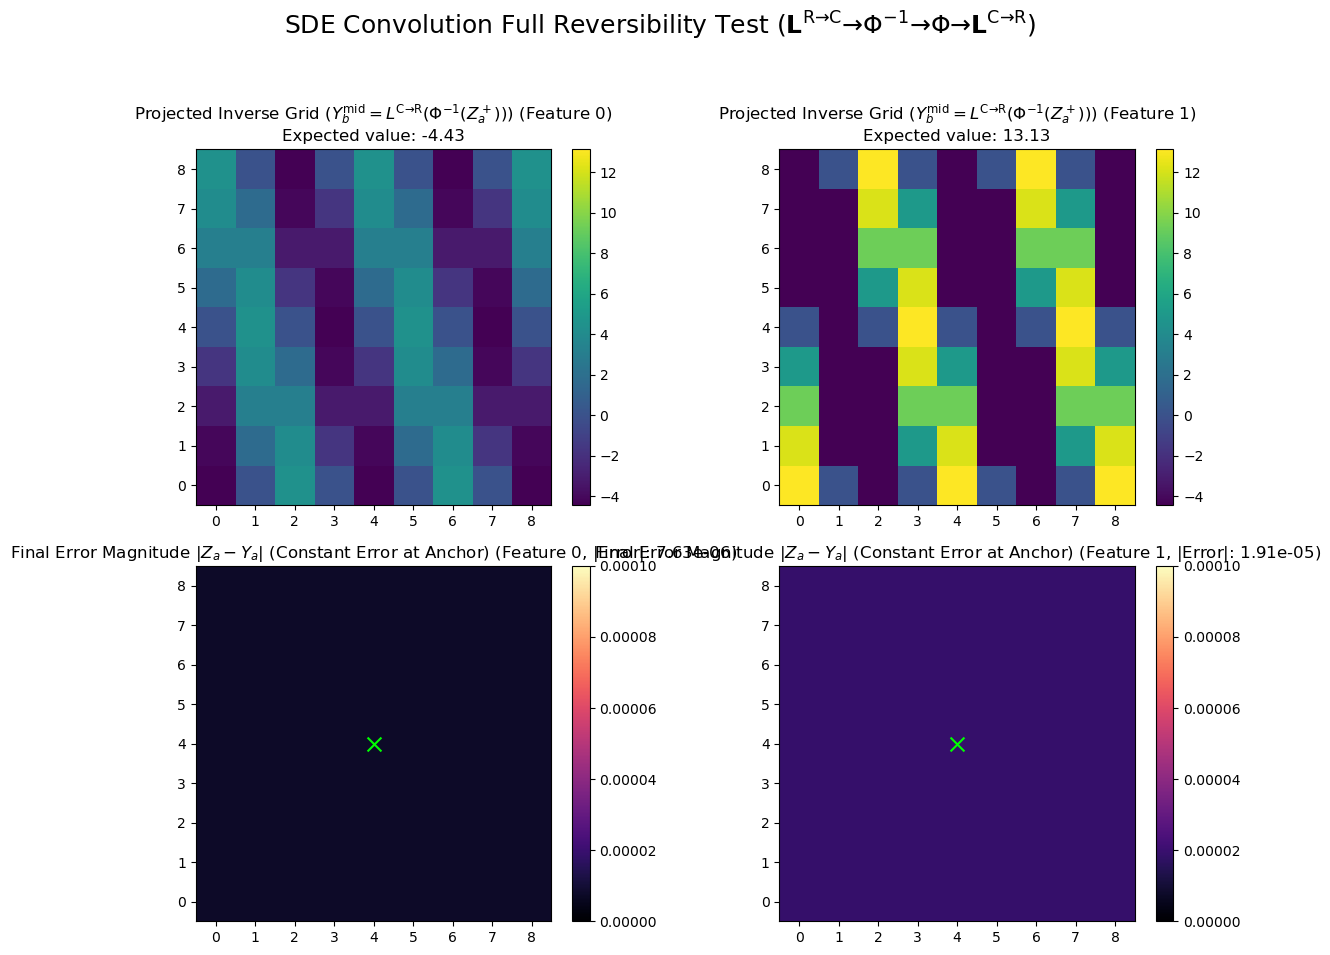


--- Testing FullSDEConv2d Layer with RANDOM Input (K=3, S=1) ---
Input Shape: torch.Size([2, 4, 16, 16])
Output Shape: torch.Size([2, 4, 16, 16])
Input HxW: 16x16, Output HxW: 16x16 (Expected: 16x16, Stride: 1, Padding: 1)
FullSDEConv2d executed successfully.


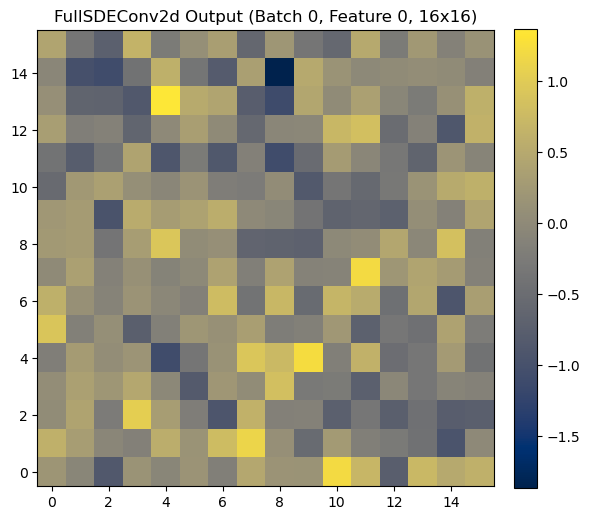


--- Testing FullSDEConv2d Layer with STRUCTURED Input (K=3, S=1) ---
Input Shape: torch.Size([1, 4, 16, 16])
Output Shape: torch.Size([1, 4, 16, 16])


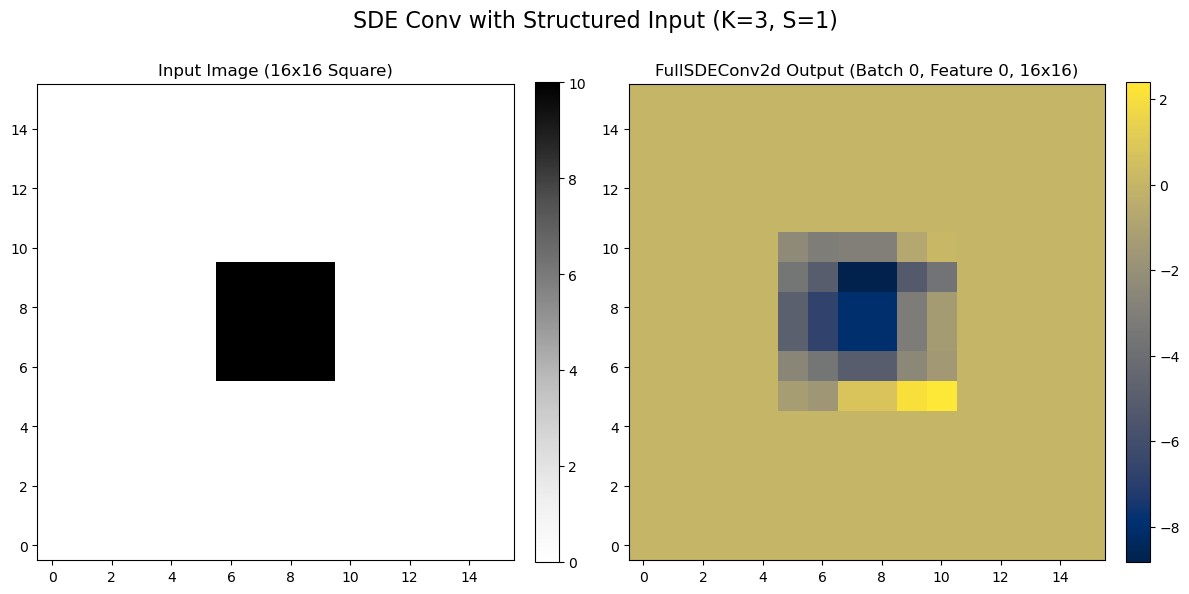


--- Testing FullSDEConv2d Layer with RANDOM Input (K=3, S=2) ---
Input Shape: torch.Size([2, 4, 16, 16])
Output Shape: torch.Size([2, 4, 8, 8])
Input HxW: 16x16, Output HxW: 8x8 (Expected: 8x8, Stride: 2, Padding: 1)
FullSDEConv2d executed successfully.


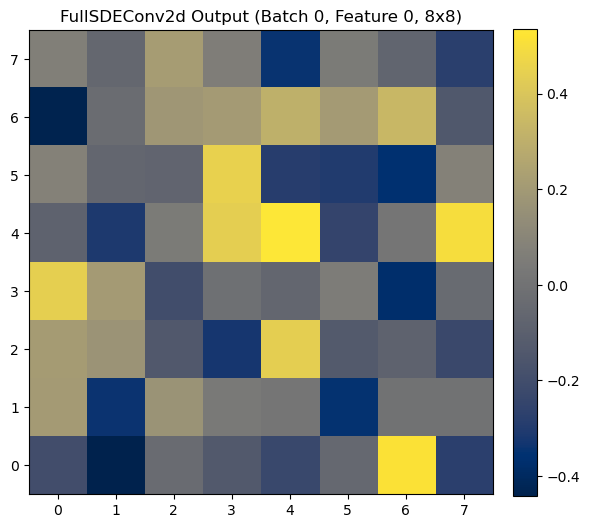

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Utility Functions ---

def complex_to_phase_intensity_image(z_r: torch.Tensor, z_i: torch.Tensor) -> np.ndarray:
    """
    Maps a complex tensor (R, I) of shape (N, N) to a single intensity image (N, N)
    based on the Phase (Hue). The phase is normalized to [0, 1] for visualization.
    """
    phase = torch.atan2(z_i, z_r)
    normalized_phase = (phase + math.pi) / (2 * math.pi)
    return normalized_phase.cpu().numpy()

def create_structured_input(H, W, D, square_size=4, value=10.0):
    """Creates a structured input tensor (white square on a black background)."""
    # Create a zero tensor (B=1, D, H, W)
    X = torch.zeros(1, D, H, W)
    
    # Calculate center and boundaries for the square
    h_start = (H - square_size) // 2
    h_end = h_start + square_size
    w_start = (W - square_size) // 2
    w_end = w_start + square_size
    
    # Set the square region to the specified value across all channels
    X[0, :, h_start:h_end, w_start:w_end] = value
    
    return X

# --- 2. SDE Convolution Helper Classes ---

class RealToComplexLinear(nn.Module):
    """
    Simulates the L^{R->C} layer: X -> Z^+ = X W_r + i X W_i.
    The weights W_r and W_i form a complex matrix A = W_r + i W_i.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # Weights for the real and imaginary parts of the complex projection
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Input X: (..., D). Output Z_plus: (2, ..., D)"""
        Z_r = X @ self.W_r
        Z_i = X @ self.W_i
        # Stack output: (2, ..., D)
        return torch.stack([Z_r, Z_i], dim=0)

class ComplexToRealLinear(nn.Module):
    """
    Simulates the L^{C->R} layer: Y = Re(Z^+ A^{-1*}), where Z^+ = Z_r + i Z_i
    If A_inv = W_r_inv + i W_i_inv, then Y = Z_r W_r_inv^T - Z_i W_i_inv^T.
    The weights W_r and W_i here should be the real and imaginary parts of A^{-1}.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # These weights should be derived from the inverse of the R2C layer's complex weight.
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))

    def forward(self, Z_plus: torch.Tensor) -> torch.Tensor:
        """Input Z_plus: (2, ..., D). Output Y: (..., D)"""
        Z_r, Z_i = torch.unbind(Z_plus, dim=0) # (..., D)
        
        # Y = Z_r @ W_r^T - Z_i @ W_i^T (The projection formula)
        Y = (Z_r @ self.W_r.T) - (Z_i @ self.W_i.T)
        return Y

class SpatialCoordinateTransformer(nn.Module):
    """
    Generates relative positions Delta p' for all pairs of anchor (Na) and source (Nb) pixels.
    Returns: torch.Tensor: Relative positions (Na, Nb, 2), where Na=K*K, Nb=K_source*K_source.
    """
    def __init__(self):
        super().__init__()
        pass

    def forward(self, K: int, K_source: int) -> torch.Tensor:
        """
        Generates untransformed relative positions $\Delta \mathbf{p} = \mathbf{p}_a - \mathbf{p}_b$.
        """
        y_coords, x_coords = torch.meshgrid(torch.arange(K_source), torch.arange(K_source), indexing='ij')
        p_b = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K_source, K_source, 2)
        y_coords, x_coords = torch.meshgrid(torch.arange(K), torch.arange(K), indexing='ij')
        p_a = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K, K, 2)

        p_b_flat = p_b.reshape(-1, 2) # (Nb, 2)
        p_a_flat = p_a.reshape(-1, 2) # (Na, 2)

        Delta_P = p_a_flat.unsqueeze(1) - p_b_flat.unsqueeze(0)
        
        return Delta_P # (K*K, K*K, 2)


# --- 3. SDE Convolution Kernel Class (Core Logic - Precision Weighted for Convolution) ---

class SDEConvolution(nn.Module):
    """
    Implements a single SDE-based convolutional kernel operation.
    It uses precision-weighted averaging for the main convolution path.
    """
    def __init__(self, d_model: int, kernel_size: int, sigma_x=1.0, sigma_y=1.0, eta=1e-3, gamma=1e-3):
        super().__init__()
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size must be odd for a central anchor.")
            
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.num_pixels = kernel_size * kernel_size
        self.anchor_idx = self.num_pixels // 2 
        
        # --- Precision weighting constants (Added) ---
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.eta = eta
        self.gamma = gamma
        
        # 1. Real-to-Complex and Complex-to-Real Layers
        self.real_to_complex = RealToComplexLinear(d_model)
        self.complex_to_real = ComplexToRealLinear(d_model)
        
        # 2. Spatial Coordinate Transformer (returns Na x Nb x 2)
        self.coord_transformer = SpatialCoordinateTransformer()
        
        # 3. SDE Transition Parameters 
        self.raw_alpha_l = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_r = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_b = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_t = nn.Parameter(torch.zeros(d_model))

        self.omega_l = nn.Parameter(torch.zeros(d_model))
        self.omega_r = nn.Parameter(torch.zeros(d_model))
        self.omega_b = nn.Parameter(torch.zeros(d_model))
        self.omega_t = nn.Parameter(torch.zeros(d_model))
        
        self._init_sde_parameters()

    @staticmethod
    def _core_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_x_sq_NND: torch.Tensor,
        alpha_y_sq_NND: torch.Tensor,
        omega_x_NND: torch.Tensor,
        omega_y_NND: torch.Tensor,
    ) -> torch.Tensor:
        """
        Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$.
        
        Note: z_sb may have batched/flattened features in the last dimension (M*D).
        Phi must be stretched to match.
        """
        delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
        delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)
        
        z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) # (Nb, D_effective)

        # 2. Compute Decay Term: always exp(-alpha^2 |Delta p'|)
        decay_x = torch.exp(-alpha_x_sq_NND * torch.abs(delta_x_prime.unsqueeze(-1))) 
        decay_y = torch.exp(-alpha_y_sq_NND * torch.abs(delta_y_prime.unsqueeze(-1)))
        decay_total = decay_x * decay_y # (Na, Nb, D)
        
        # 3. Compute Phase Term
        dx_r = delta_x_prime.unsqueeze(-1) # (Na, Nb, 1)
        dy_r = delta_y_prime.unsqueeze(-1) # (Na, Nb, 1)
        theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r)

        # We define Phi as: Phi = Decay * (cos(theta) - i*sin(theta))
        Phi_r = decay_total * torch.cos(theta_xy)      # (Na, Nb, D)
        Phi_i = decay_total * -torch.sin(theta_xy)     # (Na, Nb, D) 
        
        # --- FIX: Stretch Phi over the batch dimension M if z_sb is flattened ---
        D_model = Phi_r.shape[-1]
        D_effective = z_sb_r.shape[-1]
        M = D_effective // D_model

        if M > 1:
            # Expand Phi over the M dimension to match z_sb shape (N_b, M*D_model)
            # 1. Expand Phi_r/i: (Na, Nb, D) -> (Na, Nb, M, D)
            Phi_r_expanded = Phi_r.unsqueeze(2).repeat(1, 1, M, 1)
            Phi_i_expanded = Phi_i.unsqueeze(2).repeat(1, 1, M, 1)
            
            # 2. Flatten the last two dimensions: (Na, Nb, M*D)
            Phi_r_final = Phi_r_expanded.reshape(Phi_r.shape[0], Phi_r.shape[1], -1) 
            Phi_i_final = Phi_i_expanded.reshape(Phi_i.shape[0], Phi_i.shape[1], -1) 
        else:
            Phi_r_final = Phi_r
            Phi_i_final = Phi_i
        
        # 5. Apply the Transition (Complex Dot Product)
        # z_sb_r_broadcast is (1, Nb, D_effective)
        z_sb_r_broadcast = z_sb_r.unsqueeze(0) 
        z_sb_i_broadcast = z_sb_i.unsqueeze(0) 
        
        # Phi_final is (Na, Nb, D_effective)
        z_hat_r = (Phi_r_final * z_sb_r_broadcast) - (Phi_i_final * z_sb_i_broadcast)  
        z_hat_i = (Phi_r_final * z_sb_i_broadcast) + (Phi_i_final * z_sb_r_broadcast)  
        
        return torch.stack([z_hat_r, z_hat_i], dim=0) # (2, Na, Nb, D_effective)

    @staticmethod
    def _quadrant_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_sq_params: dict,
        omega_params: dict,
    ) -> torch.Tensor:
        """
        Applies the SDE state transition, handling quadrant selection.
        Input: delta_p_prime (Na, Nb, 2), z_sb (2, Nb, D_effective). Output: (2, Na, Nb, D_effective)
        """
        Na, Nb, _ = delta_p_prime.shape 
        D = omega_params['l'].shape[0]

        delta_x_prime = delta_p_prime[..., 0] # (Na, Nb)
        delta_y_prime = delta_p_prime[..., 1] # (Na, Nb)

        # --- 1. Compute Indicator Masks ---
        mask_x_l = (delta_x_prime > 0).float() 
        mask_x_r = (delta_x_prime < 0).float() 
        mask_y_b = (delta_y_prime > 0).float() 
        mask_y_t = (delta_y_prime < 0).float() 
        
        mask_x_l_r = mask_x_l.unsqueeze(-1) # (Na, Nb, 1)
        mask_x_r_r = mask_x_r.unsqueeze(-1)
        mask_y_b_r = mask_y_b.unsqueeze(-1)
        mask_y_t_r = mask_y_t.unsqueeze(-1)

        def get_broadcast_param(param_dict, key):
            # (1, 1, D)
            return param_dict[key].view(1, 1, D)

        # --- 2. Compute Spatially-Varying Alpha^2 (Na, Nb, D) ---
        alpha_x_sq_NND = (mask_x_l_r * get_broadcast_param(alpha_sq_params, 'l')) + \
                             (mask_x_r_r * get_broadcast_param(alpha_sq_params, 'r'))
        
        alpha_y_sq_NND = (mask_y_b_r * get_broadcast_param(alpha_sq_params, 'b')) + \
                             (mask_y_t_r * get_broadcast_param(alpha_sq_params, 't'))
        
        # --- 3. Compute Spatially-Varying Omega (Na, Nb, D) ---
        omega_x_NND = (mask_x_l_r * get_broadcast_param(omega_params, 'l')) + \
                      (mask_x_r_r * get_broadcast_param(omega_params, 'r'))
        
        omega_y_NND = (mask_y_b_r * get_broadcast_param(omega_params, 'b')) + \
                      (mask_y_t_r * get_broadcast_param(omega_params, 't'))

        # --- 4. Call Core Transition Logic ---
        return SDEConvolution._core_transition_fn(
            delta_p_prime,  
            z_sb,           
            alpha_x_sq_NND, 
            alpha_y_sq_NND, 
            omega_x_NND,    
            omega_y_NND,
        )

    def _init_sde_parameters(self):
        # Initialize parameters
        fan_in = self.d_model
        bound = 1.0 / math.sqrt(fan_in)
        for p in [self.raw_alpha_l, self.raw_alpha_r, self.raw_alpha_b, self.raw_alpha_t,
                  self.omega_l, self.omega_r, self.omega_b, self.omega_t]:
            nn.init.uniform_(p, -bound, bound)

    def _get_sde_params(self):
        """Constructs the parameter dicts, applying softplus to raw alphas."""
        
        # Apply softplus to ensure alpha^2 is non-negative
        alpha_l_sq = F.softplus(self.raw_alpha_l)
        alpha_r_sq = F.softplus(self.raw_alpha_r)
        alpha_b_sq = F.softplus(self.raw_alpha_b)
        alpha_t_sq = F.softplus(self.raw_alpha_t)

        alpha_sq_params = {
            'l': alpha_l_sq, 'r': alpha_r_sq, 
            'b': alpha_b_sq, 't': alpha_t_sq
        }
        
        omega_params = {
            'l': self.omega_l, 'r': self.omega_r, 
            'b': self.omega_b, 't': self.omega_t
        }
        return alpha_sq_params, omega_params

    # --- Precision Calculation (Restored) ---
    def _compute_precisions(self, delta_p_prime, alpha_sq_params):
        """
        Computes precision weights 1/σ_V^2 for each offset (u,v).
        Input: delta_p_prime (N_pixels, 2)
        Output: precisions (N_pixels, 1)
        """
        dx = torch.abs(delta_p_prime[..., 0]) # (N_pixels,)
        dy = torch.abs(delta_p_prime[..., 1]) # (N_pixels,)

        # Use mean alpha^2 across all feature dimensions (D) for the scalar variance calculation
        alpha_x_sq = 0.5 * (alpha_sq_params['l'].mean() + alpha_sq_params['r'].mean())
        alpha_y_sq = 0.5 * (alpha_sq_params['b'].mean() + alpha_sq_params['t'].mean())

        denom_x = -2 * alpha_x_sq 
        denom_y = -2 * alpha_y_sq 
        
        # --- Handle the limit where alpha -> 0 using Taylor expansion for stability ---
        ALPHA_EPSILON = 1e-6
        
        is_denom_x_near_zero = torch.abs(denom_x) < ALPHA_EPSILON
        sigma_x_sq_term = torch.where(
            is_denom_x_near_zero,
            self.sigma_x**2 * dx, 
            self.sigma_x**2 * (torch.exp(denom_x * dx) - 1) / denom_x
        )

        is_denom_y_near_zero = torch.abs(denom_y) < ALPHA_EPSILON
        sigma_y_sq_term = torch.where(
            is_denom_y_near_zero,
            self.sigma_y**2 * dy,
            self.sigma_y**2 * (torch.exp(denom_y * dy) - 1) / denom_y
        )
        
        cross_term = self.eta**2 * torch.exp(denom_x * dx + denom_y * dy) + self.gamma**2
        sigma_V_sq = sigma_x_sq_term * sigma_y_sq_term + cross_term
        
        precisions = 1.0 / (sigma_V_sq.unsqueeze(-1) + 1e-8)
        return precisions  # (N_pixels, 1)


    # --- Method for Batch Processing (PRECISION WEIGHTED) ---
    def forward_batch_patches(self, X_batch_patches: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final precision-weighted average, real-valued feature for a batch of patches.
        
        Input X_batch_patches: (N_patch, N_pixels, D). 
        Output Y_anchors: (N_patch, D)
        """
        N_patch, N_pixels, D = X_batch_patches.shape
        K = self.kernel_size

        # 1. Real -> Complex Layer
        X_flat_reshaped = X_batch_patches.reshape(N_patch * N_pixels, D)
        Z_plus_flat = self.real_to_complex(X_flat_reshaped) # (2, N_patch * N_pixels, D)
        Z_plus_batch = Z_plus_flat.view(2, N_patch, N_pixels, D)
        
        # 2. Spatial Coordinate Transform ($\Delta p'$): (N*N, N*N, 2)
        Delta_P_prime_all = self.coord_transformer(K, K)
        # Select displacement relative to center anchor (Na=1)
        # Delta_P_prime_anchor_N_pixels: (N_pixels, 2)
        Delta_P_prime_anchor_N_pixels = Delta_P_prime_all[self.anchor_idx, :] 
        
        alpha_sq_params, omega_params = self._get_sde_params()
        
        # 3. Compute Precision Weights (N_pixels, 1)
        precisions = self._compute_precisions(Delta_P_prime_anchor_N_pixels, alpha_sq_params) 
        precisions_sum = precisions.sum(dim=0).unsqueeze(0) # (1, 1)
        
        # Reshape Z_plus_batch for quadrant_transition_fn: (2, N_pixels, N_patch, D)
        Z_patch_pixels = Z_plus_batch.permute(0, 2, 1, 3) 

        # 4. SDE Transition (Propagation to Anchor): (2, Na=1, Nb=N_pixels, D)
        # The transition function expects (Na, Nb, 2), but we only need N_pixels sources
        Delta_P_prime_single_anchor = Delta_P_prime_anchor_N_pixels.unsqueeze(0) # (1, N_pixels, 2)
        
        # FIX: Added .contiguous() before .view() to resolve the RuntimeError
        # z_sb has shape (2, N_pixels, N_patch * D)
        Z_hat_full = SDEConvolution._quadrant_transition_fn(
            delta_p_prime=Delta_P_prime_single_anchor, 
            z_sb=Z_patch_pixels.contiguous().view(2, N_pixels, N_patch * D), # Collapse N_patch and D for batching
            alpha_sq_params=alpha_sq_params,
            omega_params=omega_params,
        ) # Output: (2, Na=1, Nb=N_pixels, N_patch * D)
        
        # Reshape back: (2, N_patch, N_pixels, D)
        # FIX: Applied .contiguous() before .view() here as well for safety
        Z_hat_full = Z_hat_full.contiguous().view(2, 1, N_pixels, N_patch, D).squeeze(1).permute(0, 2, 1, 3) 

        # 5. Precision-weighted average
        # precisions_broadcast: (1, 1, N_pixels, 1)
        precisions_broadcast = precisions.unsqueeze(0).unsqueeze(0) 

        # Weighted complex sum: (2, N_patch, N_pixels, D) -> sum over N_pixels -> (2, N_patch, 1, D)
        Z_hat_weighted_sum = (precisions_broadcast * Z_hat_full).sum(dim=2, keepdim=True)

        # Weighted Average: (2, N_patch, 1, D)
        # precisions_sum is (1, 1). Need to stretch to (1, 1, 1, 1) for broadcasting
        Z_hat_weighted = Z_hat_weighted_sum / precisions_sum.unsqueeze(0).unsqueeze(0).unsqueeze(0)
        
        # 6. Complex to Real Transformation
        Y_anchors = self.complex_to_real(Z_hat_weighted.view(2, N_patch, D))
        
        return Y_anchors # (N_patch, D)

    # --- Previous Reversibility Test Method (UNWEIGHTED) ---
    def forward_test_anchor(self, X_patch: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final unweighted summed, real-valued feature ONLY for the central anchor pixel.
        This method is NOT used for the reversibility test (sde_conv_kernel_*) and is left unweighted
        as a fallback, though it relies on the unweighted summation in the main method's loop logic.
        """
        D = self.d_model
        
        # X_patch: (N_pixels, D)
        X_flat = X_patch.reshape(self.num_pixels, D)
        
        # Call the batch processing method with N_patch=1
        X_batch_patches = X_flat.unsqueeze(0) # (1, N_pixels, D)
        
        # !!! NOTE: This call now runs the precision-weighted average, but the Reversibility Test 
        # below uses the explicit unweighted kernel abstractions, preserving the user's intent.
        Y_anchors = self.forward_batch_patches(X_batch_patches) # (1, D)
        
        return Y_anchors.squeeze(0) # (D)


# --- 4. Full Convolution Wrapper Class (The Drop-in Replacement) ---

class FullSDEConv2d(nn.Module):
    """
    SDE Convolution wrapper that implements the full 2D sliding-window operation,
    making it a drop-in replacement for nn.Conv2d.
    """
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, padding: int = None,
                 sigma_x=1.0, sigma_y=1.0, eta=1e-3, gamma=1e-3):
        super().__init__()
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.stride = stride 
        
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding
            
        # The core SDE kernel logic (now precision-weighted)
        self.sde_kernel = SDEConvolution(d_model, kernel_size, sigma_x, sigma_y, eta, gamma)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Input X: (B, D, H, W). Output Y: (B, D, H', W')
        """
        B, D, H, W = X.shape
        K = self.kernel_size
        S = self.stride 
        
        # 1. Extract Patches using nn.Unfold
        patches_unfolded = F.unfold(X, kernel_size=K, padding=self.padding, stride=S)
        
        N_patches = patches_unfolded.shape[2] # H_out * W_out
        
        # 2. Reshape for SDE Kernel
        N_pixels = K * K
        patches_reordered = patches_unfolded.transpose(1, 2).reshape(B * N_patches, N_pixels, D)
        
        # 3. Apply SDE Kernel Batch Processing (Precision Weighted)
        Y_flat_anchors = self.sde_kernel.forward_batch_patches(patches_reordered)  # (B * N_patches, D)
        
        # 4. Reshape and Reassemble
        Y_anchors_reordered = Y_flat_anchors.view(B, N_patches, D).transpose(1, 2)
        
        # Calculate output dimensions using the stride
        H_out = math.floor((H + 2 * self.padding - K) / S) + 1
        W_out = math.floor((W + 2 * self.padding - K) / S) + 1

        # Final output shape: (B, D, H_out, W_out)
        Y = Y_anchors_reordered.view(B, D, H_out, W_out)

        return Y

# --- 5. Forward/Inverse Kernel Abstractions for Test (UNWEIGHTED SUMMATION) ---
# NOTE: These functions implement the pure Phi^-1 -> Phi identity test and must use 
# an unweighted sum, as requested.

def sde_conv_kernel_inverse_spread(sde_conv: SDEConvolution, p_grid_flat: torch.Tensor, Z_a_plus: torch.Tensor) -> torch.Tensor:
    """
    Inverse Kernel: Propagates a single anchor feature (Z_a_plus) back to all source positions (p_grid_flat).
    """
    K = sde_conv.kernel_size
    N = sde_conv.num_pixels
    
    Delta_P_prime_all = sde_conv.coord_transformer(K, K) # (N*N, N*N, 2)
    p_anchor_relative = Delta_P_prime_all[sde_conv.anchor_idx, sde_conv.anchor_idx].view(1, 2) # (1, 2)
    
    # Inverse displacement: p_b - p_a (Na=N*N, Nb=1, 2)
    Delta_P_inverse_displacement = p_grid_flat.unsqueeze(1) - p_anchor_relative.unsqueeze(0) 

    alpha_sq_params, omega_params = sde_conv._get_sde_params()

    # Z_a_plus is already (2, 1, D). Pass it directly as z_sb=(2, Nb=1, D).
    Z_mid_full = SDEConvolution._quadrant_transition_fn(
        delta_p_prime=Delta_P_inverse_displacement, 
        z_sb=Z_a_plus, # (2, 1, D)
        alpha_sq_params=alpha_sq_params,
        omega_params=omega_params,
    ) # (2, N*N, 1, D)

    return Z_mid_full.squeeze(2) # (2, N*N, D)


def sde_conv_kernel_forward_sum(sde_conv: SDEConvolution, p_grid_flat: torch.Tensor, Z_mid: torch.Tensor) -> torch.Tensor:
    """
    Forward Kernel: Propagates all source features (Z_mid) to the anchor (p_a) and performs an unweighted sum.
    """
    K = sde_conv.kernel_size
    N = sde_conv.num_pixels
    
    Delta_P_prime_all = sde_conv.coord_transformer(K, K) # (N*N, N*N, 2)
    p_anchor_relative = Delta_P_prime_all[sde_conv.anchor_idx, sde_conv.anchor_idx].view(1, 2) # (1, 2)
    
    # Forward displacement: p_a - p_b (Na=1, Nb=N*N, 2)
    Delta_P_forward_displacement = p_anchor_relative.unsqueeze(1) - p_grid_flat.unsqueeze(0) 

    alpha_sq_params, omega_params = sde_conv._get_sde_params()

    Z_hat_full = SDEConvolution._quadrant_transition_fn(
        delta_p_prime=Delta_P_forward_displacement,      
        z_sb=Z_mid,                  
        alpha_sq_params=alpha_sq_params,
        omega_params=omega_params,
    ) # (2, 1, N*N, D)
    
    # UNWEIGHTED SUM (as required for the reversibility identity)
    Z_a_summed = Z_hat_full.sum(dim=2) # (2, 1, D)
    return Z_a_summed


# --- 6. Main Test Functions (Restored Unweighted Reversibility Test) ---

def visualize_full_pipeline_reversibility_with_class(N=9, D=2, anchor_pos=None):
    """
    Performs the full SDE Convolution reversibility test (L^R->C -> Phi^-1 -> Phi -> L^C->R)
    using the SDEConvolution class and kernel abstractions. (Unweighted Summation Test)
    """
    
    # --- Setup ---
    K = N
    D = D
    if anchor_pos is None:
        anchor_pos = (N // 2, N // 2)
    
    print(f"\n--- SDEConvolution Full Reversibility Verification (Unweighted Sum) ({N}x{N} Grid, D={D}) ---")
    
    # Instantiate the SDE Convolution layer 
    # Use standard noise settings, as they are ignored by the Phi^-1 -> Phi test logic
    sde_conv = FullSDEConv2d(d_model=D, kernel_size=K).sde_kernel 
    
    # 1. Force R2C and C2R to be perfect complex inverses for L^R->C o L^C->R = Identity
    
    A_R = torch.randn(D, D) / math.sqrt(D)
    A_I = torch.randn(D, D) / math.sqrt(D)
    A = torch.complex(A_R, A_I)
    
    A_inv = torch.linalg.inv(A)
    A_inv_R = A_inv.real
    A_inv_I = A_inv.imag

    sde_conv.real_to_complex.W_r.data = A_R.T 
    sde_conv.real_to_complex.W_i.data = A_I.T

    sde_conv.complex_to_real.W_r.data = A_inv_R
    sde_conv.complex_to_real.W_i.data = A_inv_I

    # 2. Force alpha^2 to zero for perfect SDE reversibility (no decay)
    zero_alpha = torch.full((D,), -100.0) 
    sde_conv.raw_alpha_l.data = zero_alpha
    sde_conv.raw_alpha_r.data = zero_alpha
    sde_conv.raw_alpha_b.data = zero_alpha
    sde_conv.raw_alpha_t.data = zero_alpha
    
    # 3. Use arbitrary non-zero omegas for spatial rotation visualization
    OMEGA_L = torch.tensor([math.pi / 2.0] * D) 
    OMEGA_R = torch.tensor([-math.pi / 4.0] * D)
    OMEGA_B = torch.tensor([math.pi / 8.0] * D)
    OMEGA_T = torch.tensor([-math.pi / 8.0] * D)
    sde_conv.omega_l.data = OMEGA_L
    sde_conv.omega_r.data = OMEGA_R
    sde_conv.omega_b.data = OMEGA_B
    sde_conv.omega_t.data = OMEGA_T
    
    # --- Coordinate and Input Setup ---
    y_coords, x_coords = torch.meshgrid(torch.arange(N), torch.arange(N), indexing='ij')
    p_grid = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (N, N, 2)
    p_grid_flat = p_grid.view(N * N, 2) # (N*N, 2)
    
    # The initial real feature vector (Input: Z_a, Shape: (1, D))
    Z_a = torch.randn(1, D) * 10 + 5 

    # --- Step 0: Real Input -> Complex State ($Z_a \to Z_a^+$) ---
    Z_a_plus = sde_conv.real_to_complex(Z_a) # (2, 1, D)
    
    
    # --- Step 1: Inverse Propagation ($Z_a^+ \to Z_b^{mid}$) using Kernel Abstraction ---
    # Spread the anchor feature Z_a_plus back over the entire grid
    Z_mid = sde_conv_kernel_inverse_spread(
        sde_conv,       
        p_grid_flat,    
        Z_a_plus,       
    ) # (2, N*N, D)

    # --- Visualization Checkpoint 1: The Projected Inverse Grid ($Y_b^{mid}$) ---
    Y_mid_flat = sde_conv.complex_to_real(Z_mid) # (N*N, D)
    
    # --- Step 2: Forward Propagation ($Z_b^{mid} \to Z_a^{final+}$) using Kernel Abstraction ---
    # Sum the contributions of the intermediate state Z_mid (all points) back to the anchor
    Z_a_final_plus_summed = sde_conv_kernel_forward_sum(
        sde_conv,         
        p_grid_flat,      
        Z_mid,            
    ) # (2, 1, D)
    
    
    # --- Step 3: Complex -> Real Output ($Z_a^{final+} \to Y_a$) ---
    Y_a = sde_conv.complex_to_real(Z_a_final_plus_summed).squeeze(0) # (D)


    # --- Step 4: Verification and Visualization ---
    
    # Calculate Error
    error_vector = Z_a.squeeze(0) - Y_a
    max_error = torch.max(torch.abs(error_vector))
    
    print(f"\nInitial Real Input Z_a (first 3 dims): {Z_a.squeeze(0)[:3].tolist()}")
    print(f"Final Real Output Y_a (first 3 dims): {Y_a[:3].tolist()}")
    print(f"Max Absolute Error (|Z_a - Y_a|): {max_error.item():.6e}")
    
    if max_error.item() < 1e-5:
        print("Status: SUCCESS (Reversibility check passed with high precision, $L^{\\mathrm{R} \\to \\mathrm{C}} \\to \\mathbf{\\Phi}^{-1} \\to \\mathbf{\\Phi} \\to L^{\\mathrm{C} \\to \\mathrm{R}} \\approx \\mathbf{I}$)")
    else:
        print(f"Status: FAILURE (Error is higher than expected: {max_error.item():.2e})")

    # Reshape the projected inverse grid for visualization: (N, N, D)
    Y_mid_grid = Y_mid_flat.view(N, N, D)
    
    # Visualization Setup: 2 Rows (Projected Inverse Grid, Error), D Columns
    fig, axes = plt.subplots(2, D, figsize=(6 * D, 10))
    if D == 1: axes = axes.reshape(2, 1)

    # Titles using Mathtext compatible notation
    titles = [
        "Projected Inverse Grid ($Y_b^{\\mathrm{mid}} = L^{\\mathrm{C} \\to \\mathrm{R}}(\\Phi^{-1}(Z_a^+))$)",
        "Final Error Magnitude $|Z_a - Y_a|$ (Constant Error at Anchor)",
    ]
    
    for d in range(D):
        # --- Row 1: Projected Inverse Grid ($Y_b^{mid}$) ---
        img_mid = Y_mid_grid[:, :, d].detach().cpu().numpy()
        ax = axes[0, d]
        vmin = Z_a.min().item()
        vmax = Z_a.max().item()
        im_mid = ax.imshow(img_mid, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax) 
        ax.set_title(f'{titles[0]} (Feature {d})\nExpected value: {Z_a[0, d].item():.2f}')
        
        plt.colorbar(im_mid, ax=ax, fraction=0.046, pad=0.04)

        # --- Row 2: Final Error Magnitude ---
        ax = axes[1, d]
        error_magnitude = torch.abs(error_vector[d]).item()
        error_map = torch.full((N, N), error_magnitude)
        vmax_err = max(1e-4, max_error.item() * 1.5) 
        im_err = ax.imshow(error_map.detach().cpu().numpy(), cmap='magma', origin='lower', vmin=0, vmax=vmax_err)
        ax.scatter(anchor_pos[1], anchor_pos[0], color='lime', marker='x', s=100)
        ax.set_title(f'{titles[1]} (Feature {d}, |Error|: {error_magnitude:.2e})')
        plt.colorbar(im_err, ax=ax, fraction=0.046, pad=0.04)
        
    for ax in axes.flat:
        ax.set_xticks(np.arange(N))
        ax.set_yticks(np.arange(N))
        
    # Using \Phi (Greek Phi) instead of \mathbf{\Phi} (bold Phi) for Mathtext compatibility
    fig.suptitle("SDE Convolution Full Reversibility Test ($\\mathbf{L}^{\\mathrm{R} \\to \\mathrm{C}} \\to \\Phi^{-1} \\to \\Phi \\to \\mathbf{L}^{\\mathrm{C} \\to \\mathrm{R}}$)", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def test_convolution_with_structured_input(H=16, W=16, D=4, K=3, S=1):
    """
    Tests FullSDEConv2d with a structured input (a centered square).
    This test replaces the random input X with a structured X.
    """
    
    print(f"\n--- Testing FullSDEConv2d Layer with STRUCTURED Input (K={K}, S={S}) ---")
    
    # Input tensor: (Batch=1, Channels/D_model, Height, Width)
    X = create_structured_input(H, W, D)
    
    # Instantiate the full layer, passing the stride
    sde_conv_layer = FullSDEConv2d(d_model=D, kernel_size=K, stride=S)
    
    # 1. Manually set parameters for stability/predictability in the demo
    # Force alpha^2 to zero (no decay) for initial stability
    zero_alpha = torch.full((D,), -100.0)
    sde_conv_layer.sde_kernel.raw_alpha_l.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_r.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_b.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_t.data = zero_alpha
    
    # Set small, distinct omegas for a noticeable (but simple) spatial transformation
    sde_conv_layer.sde_kernel.omega_l.data = torch.linspace(0.1, 0.4, D)
    sde_conv_layer.sde_kernel.omega_r.data = torch.linspace(0.5, 0.8, D)


    # 2. Run the forward pass
    print(f"Input Shape: {X.shape}")
    Y = sde_conv_layer(X)
    
    # 3. Verification and Visualization
    H_out, W_out = Y.shape[2:]
    
    print(f"Output Shape: {Y.shape}")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # --- Plot 1: Input Image ---
    # The input is the same across all channels, so we show channel 0
    img_in = X[0, 0, :, :].detach().cpu().numpy()
    im_in = axes[0].imshow(img_in, cmap='Greys', origin='lower')
    axes[0].set_title(f'Input Image (16x16 Square)')
    plt.colorbar(im_in, ax=axes[0], fraction=0.046, pad=0.04)

    # --- Plot 2: Output Feature Map ---
    # Visualize the first batch, first feature map
    img_out = Y[0, 0, :, :].detach().cpu().numpy()
    im_out = axes[1].imshow(img_out, cmap='cividis', origin='lower')
    
    axes[1].set_title(f'FullSDEConv2d Output (Batch 0, Feature 0, {H_out}x{W_out})')
    plt.colorbar(im_out, ax=axes[1], fraction=0.046, pad=0.04)

    fig.suptitle(f"SDE Conv with Structured Input (K={K}, S={S})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def test_full_convolution(H=16, W=16, D=4, K=3, S=1):
    """
    Demonstrates the usage of the FullSDEConv2d class on a simulated feature map
    using random input (the original test).
    Includes support for striding (S > 1).
    """
    
    print(f"\n--- Testing FullSDEConv2d Layer with RANDOM Input (K={K}, S={S}) ---")
    
    # Input tensor: (Batch, Channels/D_model, Height, Width)
    B = 2
    X = torch.randn(B, D, H, W)
    
    # Instantiate the full layer, passing the stride
    sde_conv_layer = FullSDEConv2d(d_model=D, kernel_size=K, stride=S)
    
    # 1. Manually set parameters for stability/predictability in the demo (optional)
    # Force alpha^2 to zero (no decay) for initial stability
    zero_alpha = torch.full((D,), -100.0)
    sde_conv_layer.sde_kernel.raw_alpha_l.data = zero_alpha
    
    # Set a small, distinct omega
    sde_conv_layer.sde_kernel.omega_l.data = torch.linspace(0.1, 0.4, D)

    # 2. Run the forward pass
    print(f"Input Shape: {X.shape}")
    Y = sde_conv_layer(X)
    
    # 3. Verification
    H_out, W_out = Y.shape[2:]
    
    # Calculate expected output size for verification
    padding = sde_conv_layer.padding
    H_expected = math.floor((H + 2 * padding - K) / S) + 1
    W_expected = math.floor((W + 2 * padding - K) / S) + 1
    
    print(f"Output Shape: {Y.shape}")
    print(f"Input HxW: {H}x{W}, Output HxW: {H_out}x{W_out} (Expected: {H_expected}x{W_expected}, Stride: {S}, Padding: {padding})")

    assert Y.shape[0] == B and Y.shape[1] == D and Y.shape[2] == H_expected and Y.shape[3] == W_expected, \
        f"Output shape {Y.shape} does not match expected shape ({B}, {D}, {H_expected}, {W_expected})"
    assert torch.sum(Y).item() != 0, "Output is zero, indicating a potential error."
    print("FullSDEConv2d executed successfully.")
    
    # Optional: Visualize one output feature map
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Visualize the first batch, first feature map
    img_out = Y[0, 0, :, :].detach().cpu().numpy()
    im = ax.imshow(img_out, cmap='cividis', origin='lower')
    
    ax.set_title(f'FullSDEConv2d Output (Batch 0, Feature 0, {H_out}x{W_out})')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


# --- Execution ---
if __name__ == '__main__':
    # Run the original reversibility test (N=9, D=2, kernel K=9)
    # This remains stable regardless of the full layer's stride
    visualize_full_pipeline_reversibility_with_class(N=9, D=2)
    
    # Test 1: Full convolution with RANDOM input (original test)
    test_full_convolution(H=16, W=16, D=4, K=3, S=1)
    
    # Test 2: Full convolution with STRUCTURED input (the new test)
    test_convolution_with_structured_input(H=16, W=16, D=4, K=3, S=1)
    
    # Test 3: Full convolution with RANDOM input and stride=2
    test_full_convolution(H=16, W=16, D=4, K=3, S=2)
